In [2]:
from ipywidgets import interact, FloatSlider, RadioButtons,Dropdown,SelectMultiple,FloatRangeSlider
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import h5py
import os
import scipy
import sklearn
from scipy.stats import pearsonr
from sklearn.metrics import roc_curve,roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact, FloatSlider,IntSlider, RadioButtons,Dropdown,Tab,Text
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from  sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
tableau20 = np.array([(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)])/255.

Populating the interactive namespace from numpy and matplotlib


In [18]:
pwd

'/home/chenxupeng/projects/training'

In [4]:
wholeannotation = pd.read_table("wholeannotation.csv",sep=',')
wholeannotation.head()

,Unnamed: 0,Sample_ID,Disease_status,Sex,Age,Tumor_size(cm),Multiple_tumor,Vascular_invasion,Satellite_nonules,AFP(ng/ml),...,PT,Stage-BCLC,RNA_mass(ng/mlplasma),Batch,spike-in,Seq-mode,DNase1,use,sampleuse,Disease_status_formal
0,0,lulab_249136_B,HCC_before_surgery,M,43,2.8,No,No,0,559.6,...,10.1,A,27.63,7th_201803,NaN,NaN,NaN,1,1,HCC
1,1,lulab_385247_B,HCC_before_surgery,M,54,4,No,No,1,19.61,...,12,A,33.45,4th_201801,NaN,NaN,NaN,1,1,HCC
2,2,lulab_423976_B,HCC_before_surgery,F,60,_,No,Yes,0,4.58,...,15,C,32.66,3nd_201801,NaN,NaN,NaN,1,1,HCC
3,3,lulab_497411_B,HCC_before_surgery,F,70,8,No,No,0,3.45,...,11.3,A,28.32,2nd_201712,0,PE150,N,1,1,HCC
4,4,lulab_497497_B,HCC_before_surgery,M,44,12.3,Yes,No,0,3155,...,11.2,B,34.24,1st_201711,0,PE150,N,1,1,HCC


# feature selection
use after normalization

## prepare data
- main and top20
- preprocess

In [344]:
##注意： 经过检验，normalization步骤的sample use是没问题的，在前64个sample中去掉三个sample，这里wholeanno是66个sample，
##在前64个有三个去掉，再去掉post的即为需要的
sampleinduse = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,14,  15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 58, 59, 60])

In [345]:
np.where(wholeannotation['sampleuse'] ==1)[0][:-2]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

#### 需要的43个sample的table！

In [7]:
#需要的43个sample的table！
usetable = wholeannotation.iloc[np.where(wholeannotation['sampleuse'] ==1)[0][:-2]].iloc[sampleinduse]

In [8]:
np.sum(usetable['Disease_status_formal'] =='HCC')

30

In [9]:
def get_data(full=True):
    if full:
        featuretable=  pd.read_table('05.matrix/forfeatureselectionbynorm_61samplefull.csv',sep=',').iloc[:,1:].iloc[sampleinduse,:]
        featuretable['lables'][featuretable['lables'] ==2]=0
        return featuretable
    else:
        featuretable =  pd.read_table('05.matrix/forfeatureselectionbynorm_61samplebinned.csv',sep=',').iloc[:,1:].iloc[sampleinduse,:]
        featuretable['lables'][featuretable['lables'] ==2]=0
        return featuretable
def top20_data(full=True):
    if full:
        return np.array(pd.read_table('05.matrix/forfeatureselectionbynorm_61samplefulltop20.csv',sep=',').iloc[:,1:].iloc[:,sampleinduse]).T
    else:
        return np.array(pd.read_table('05.matrix/forfeatureselectionbynorm_61samplebinnedtop20.csv',sep=',').iloc[:,1:].iloc[:,sampleinduse]).T
def get_concat_data(top20,main):
    main[np.isnan(main)] =0
    print (preprocessing.scale(top20).shape)
    print (preprocessing.scale(main).shape)
    fullfeaturesarray =np.concatenate((preprocessing.scale(main),
                               preprocessing.scale(top20),
                ),axis=1)
    print (fullfeaturesarray.shape)
    return fullfeaturesarray   

In [10]:
fullfeaturename = np.concatenate((get_data(full=True).columns[2:],
                np.array(pd.read_table('05.matrix/forfeatureselectionbynorm_61samplefulltop20.csv',sep=',').iloc[:,0])))
binfeaturename = np.concatenate((get_data(full=False).columns[2:],
                np.array(pd.read_table('05.matrix/forfeatureselectionbynorm_61samplebinnedtop20.csv',sep=',').iloc[:,0])))
mixfeaturename = np.concatenate((fullfeaturename,binfeaturename))

In [331]:
np.array(pd.read_table('binnedtop20.csv'))[i][0]

'3,"Y_RNA_ENSG00000201778.1__157153578__157153608"'

In [340]:
np.savetxt('top20featurebin_full.txt',np.concatenate((np.array([np.array(pd.read_table('binnedtop20.csv'))[i][0].split(',')[1][1:-1] for i in range(20)]).reshape(-1,1),
np.array([np.array(pd.read_table('fulltop20.csv'))[i][0].split(',')[1][1:-1] for i in range(20)]).reshape(-1,1)),axis=1),fmt='%s')



In [11]:
binfeaturenamesplit = np.array([binfeaturename[i].split('__')[0] for i in range(binfeaturename.shape[0])]).astype('object')
mixfeaturenamesplit = np.concatenate((fullfeaturename,binfeaturenamesplit)).astype('object')

In [12]:
fullfeaturesarray = get_concat_data(top20_data(full=True),np.array(get_data(full=True).iloc[:,2:]))
binfeaturesarray = get_concat_data(top20_data(full=False),np.array(get_data(full=False).iloc[:,2:]))

(43, 20)
(43, 10269)
(43, 10289)
(43, 20)
(43, 45726)
(43, 45746)


In [341]:
np.max(fullfeaturesarray)

5.733181512876258

In [342]:
np.min(fullfeaturesarray)

-6.1738859176107885

(array([2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        5.000e+00, 9.000e+00, 8.000e+00, 1.400e+01, 1.000e+01, 3.200e+01,
        3.000e+01, 5.800e+01, 5.600e+01, 8.200e+01, 1.260e+02, 1.890e+02,
        2.660e+02, 5.620e+02, 1.058e+03, 1.885e+03, 2.178e+03, 1.592e+03,
        7.900e+02, 4.770e+02, 2.810e+02, 1.910e+02, 1.180e+02, 8.800e+01,
        5.000e+01, 2.600e+01, 2.800e+01, 2.500e+01, 1.200e+01, 9.000e+00,
        1.300e+01, 6.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-7.23865412e-14, -6.91380286e-14, -6.58895161e-14, -6.26410035e-14,
        -5.93924909e-14, -5.61439784e-14, -5.28954658e-14, -4.96469532e-14,
        -4.63984406e-14, -4.31499281e-14, -3.99014155e-14, -3.66529029e-14,
        -3.34043904e-14, -3.01558778e-14, -2.69073652e-14, -2.36588527e-14,
        -2.04103401e-14, -1.71618275e-14, -1.39133149e-14, -1.06648024e-

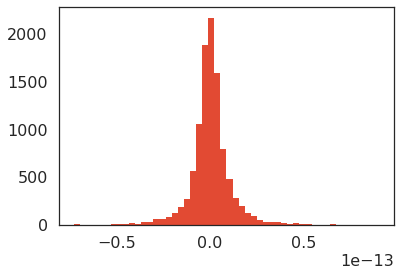

In [268]:
hist(np.sum(fullfeaturesarray,axis=0),bins=50)

In [285]:
testdisarr =np.array(pd.read_table('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/05.matrix/hcc_lulab.sequentialMap.featureCounts.merged.noshort.mx'))

In [286]:
np.sum(testdisarr,axis=1).shape

(40542,)

(array([4.0541e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.00000000e+00, 1.90444665e+07, 3.80889330e+07, 5.71333994e+07,
        7.61778659e+07, 9.52223324e+07, 1.14266799e+08, 1.33311265e+08,
        1.52355732e+08, 1.71400198e+08, 1.90444665e+08, 2.09489131e+08,
        2.28533598e+08, 2.47578064e+08, 2.66622531e+08, 2.85666997e+08,
        3.04711464e+08, 3.2375

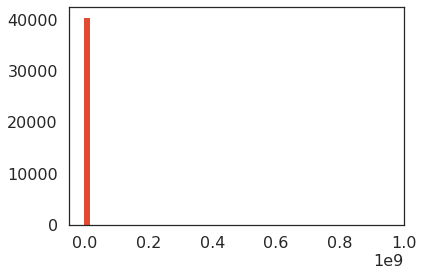

In [278]:
hist(np.sum(testdisarr,axis=1),bins=50)

In [280]:
def is_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

(array([8782., 2934., 2115., 1555., 1354., 1295., 1025.,  891.,  789.,
         721.,  799.,  636.,  562.,  515.,  540.,  593.,  493.,  486.,
         427.,  414.,  384.,  352.,  312.,  352.,  279.,  318.,  261.,
         264.,  287.,  264.,  263.,  197.,  216.,  234.,  214.,  177.,
         178.,  160.,  184.,  160.,  171.,  139.,  133.,  156.,  144.,
         161.,  117.,  125.,  122.,  118.]),
 array([  0. ,   9.2,  18.4,  27.6,  36.8,  46. ,  55.2,  64.4,  73.6,
         82.8,  92. , 101.2, 110.4, 119.6, 128.8, 138. , 147.2, 156.4,
        165.6, 174.8, 184. , 193.2, 202.4, 211.6, 220.8, 230. , 239.2,
        248.4, 257.6, 266.8, 276. , 285.2, 294.4, 303.6, 312.8, 322. ,
        331.2, 340.4, 349.6, 358.8, 368. , 377.2, 386.4, 395.6, 404.8,
        414. , 423.2, 432.4, 441.6, 450.8, 460. ]),
 <a list of 50 Patch objects>)

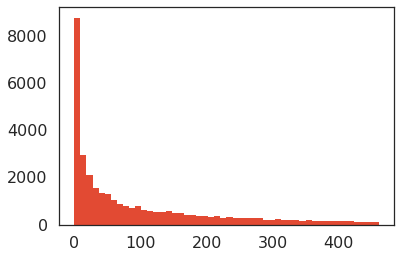

In [289]:
hist(np.sum(testdisarr,axis=1)[~is_outlier(np.sum(testdisarr,axis=1))],bins=50)

In [295]:
np.sort(np.sum(testdisarr,axis=1))[-20:]

array([  1900588,   1960362,   2050803,   2086526,   2375429,   2608950,
         2724162,   2988702,   3142824,   3322911,   3492576,   3555614,
         3583600,   3634429,   3706456,   4050537,   4063755,   4969130,
         5134953, 952223324])

(array([2.5744e+04, 5.3340e+03, 2.5530e+03, 1.5950e+03, 1.0010e+03,
        6.6000e+02, 4.9300e+02, 3.7900e+02, 3.2700e+02, 1.8100e+02,
        1.8700e+02, 1.4300e+02, 1.0700e+02, 1.1200e+02, 9.0000e+01,
        8.4000e+01, 7.0000e+01, 6.5000e+01, 5.1000e+01, 4.6000e+01,
        4.8000e+01, 4.2000e+01, 3.6000e+01, 3.9000e+01, 3.3000e+01,
        2.9000e+01, 4.4000e+01, 3.9000e+01, 3.0000e+01, 2.1000e+01,
        2.6000e+01, 1.8000e+01, 2.3000e+01, 2.8000e+01, 2.7000e+01,
        1.8000e+01, 8.0000e+00, 1.2000e+01, 1.7000e+01, 7.0000e+00,
        1.3000e+01, 1.1000e+01, 1.5000e+01, 6.0000e+00, 9.0000e+00,
        1.4000e+01, 8.0000e+00, 1.9000e+01, 9.0000e+00, 6.7100e+02]),
 array([   0.,  160.,  320.,  480.,  640.,  800.,  960., 1120., 1280.,
        1440., 1600., 1760., 1920., 2080., 2240., 2400., 2560., 2720.,
        2880., 3040., 3200., 3360., 3520., 3680., 3840., 4000., 4160.,
        4320., 4480., 4640., 4800., 4960., 5120., 5280., 5440., 5600.,
        5760., 5920., 6080., 6240.

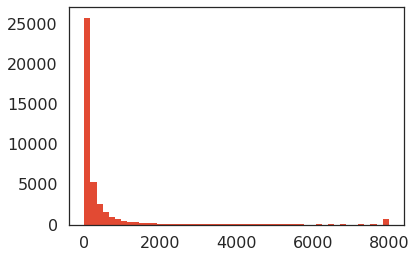

In [300]:
hist(np.clip(np.sum(testdisarr,axis=1),0,8000),bins=50)

In [13]:
mixfeaturesarray = np.concatenate((fullfeaturesarray,binfeaturesarray),axis=1)
mixfeaturesarray.shape

(43, 56035)

In [51]:
fullfeaturetable = get_data(full=True)
fullfeaturearray = np.array(fullfeaturetable.iloc[:,2:])
top20full = top20_data(full=True)
top20full.shape

In [621]:
np.array(featuretable['lables']).reshape(1,-1).shape

(1, 43)

### 直接feature selection full fit挑gene！

#### 准备数据供feature selection
- 三种数据格式*(stageA vs control, stageB vs control, stageC vs control, HCC vs control，同时区分三个stage和control)
- 共15种数据
从fullfeaturesarray,binfeaturesarray,mixfeaturesarray加上索引获得
- **目前先做stage A vs normal，HCC vs normal两种**

In [14]:
np.array(usetable['Stage-BCLC'])

array(['A', 'A', 'C', 'A', 'B', 'B', 'B', 'A', 'A', 'B', 'A', 'B', 'A',
       'A', 'B', 'A', 'A', 'C', 'B', 'A', 'B', 'C', 'A', 'B', 'A', 'A',
       'B', 'C', 'A', 'A', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-'], dtype=object)

In [15]:
def produce_sample_ind():
    '''
    generate five types of sample ind
    '''
    inda = np.where(usetable['Stage-BCLC'] =='A')[0]
    indb = np.where(usetable['Stage-BCLC'] =='B')[0]
    indc = np.where(usetable['Stage-BCLC'] =='C')[0]
    indnormal = np.where(usetable['Stage-BCLC'] =='-')[0]
    indhcc = np.concatenate((inda,indb,indc))
    return inda,indb,indc,indnormal,indhcc

In [16]:
indA,indB,indC,indnormal,indhcc = produce_sample_ind()

In [17]:
print (indA)
print (indB)
print (indC)
print (indnormal)
print (indhcc)

[ 0  1  3  7  8 10 12 13 15 16 19 22 24 25 28 29]
[ 4  5  6  9 11 14 18 20 23 26]
[ 2 17 21 27]
[30 31 32 33 34 35 36 37 38 39 40 41 42]
[ 0  1  3  7  8 10 12 13 15 16 19 22 24 25 28 29  4  5  6  9 11 14 18 20
 23 26  2 17 21 27]


In [22]:
sampleclass = np.zeros([43]).astype('int') #各种类别的
binaryind = np.zeros([43]).astype('int') #hcc vs normal
binaryind[indhcc] = 1
sampleclass[indA] = 1
sampleclass[indB] = 2
sampleclass[indC] = 3

In [23]:
sampleclass

array([1, 1, 3, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 3, 2, 1, 2, 3,
       1, 2, 1, 1, 2, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
sampleclass[np.concatenate((indA,indnormal))]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [25]:
binaryind[np.concatenate((indhcc,indnormal))]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [19]:
def generate_featurearr(featurekind,featureclass):
    '''
    featurekind: full,bin,mix
    featureclass: A,B,C,hcc(hccvsnormal),all(allkinds)
    '''
    stageindAnorm = np.concatenate((indA,indnormal))
    hccnorm = np.concatenate((indhcc,indnormal))
    if featurekind == 'full':
        if featureclass == 'A':
            return fullfeaturesarray[stageindAnorm],sampleclass[stageindAnorm].astype('int')
        elif featureclass == 'hcc':
            return fullfeaturesarray[hccnorm],binaryind[hccnorm].astype('int')
    elif featurekind =='bin':
        if featureclass == 'A':
            return binfeaturesarray[stageindAnorm],sampleclass[stageindAnorm].astype('int')
        elif featureclass == 'hcc':
            return binfeaturesarray[hccnorm],binaryind[hccnorm]  .astype('int')  
    elif featurekind =='mix':
        if featureclass == 'A':
            return mixfeaturesarray[stageindAnorm],sampleclass[stageindAnorm].astype('int')
        elif featureclass == 'hcc':
            return mixfeaturesarray[hccnorm],binaryind[hccnorm].astype('int')

### 先获得六种feature
以full A为例进行尝试

In [346]:
datatype = ['full','bin','mix']
dataclass = ['A','hcc']
dataset = {}
labelset = {} 
for i in range(3):
    dataset[datatype[i]],labelset[datatype[i]] = {},{}
    for j in range(2):
        dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]] = generate_featurearr(datatype[i],dataclass[j])

In [27]:
dataset['full']['A']
labelset['full']['A']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [347]:
labelset

{'bin': {'A': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0]),
  'hcc': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])},
 'full': {'A': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0]),
  'hcc': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])},
 'mix': {'A': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0]),
  'hcc': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}}

In [794]:
sampleclass

array([1, 1, 3, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 3, 2, 1, 2, 3,
       1, 2, 1, 1, 2, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [796]:
dataset['full']['A'].shape

(29, 10289)

In [806]:
for i in range(3):
    for j in [1]:
        with h5py.File('feature/'+datatype[i]+'_'+dataclass[j]+'feature.h5') as f:
            f.create_dataset('feature',data=dataset[datatype[i]][dataclass[j]])
            f.create_dataset('binary_label',data=labelset['full']['hcc'])
            f.create_dataset('class_label',data=sampleclass)
            print (datatype[i],dataclass[j])
            print (dataset[datatype[i]][dataclass[j]].shape)

full hcc
(43, 10289)
bin hcc
(43, 45746)
mix hcc
(43, 56035)


In [802]:
labelset['full']['hcc']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### 特征选择
- logistic regression 加上L1正则化，画图显示不同正则化参数选出的feature
- MRMR

In [543]:
def logistic_selection(feature,label,penalty=1):
    logmodel = LogisticRegression(penalty='l1',C=penalty)
    logmodel.fit(feature,label)
    return logmodel.coef_

In [29]:
binfeaturename[i].split('__')

['miRNA_ENSG00000278267.1', '17429', '17436']

In [38]:
def get_featurename(coef,featurename):
    selectfeatureind = np.where(np.abs(coef)>=0.00001)[0]
    selectfeatureind_ =selectfeatureind[np.argsort(-np.abs(coef[selectfeatureind]))[:np.where(coef!=0)[0].shape[0]]]
    ttttesttab =  pd.DataFrame(np.concatenate((featurename[selectfeatureind_].reshape(-1,1),
                                coef[np.argsort(-np.abs(coef))
                             [:np.where(coef!=0)[0].shape[0]]].reshape(-1,1)),axis=1),
                columns=['ID','importance'])
    countlist_ = []
    print (ttttesttab.shape)
    num = int(ttttesttab.shape[0]/5)*5
    if num >=50: 
        num =50 
    print (num)
    for i in range(num):
        countlist_.append(ttttesttab.iloc[i,0]+': '+str(np.round(ttttesttab.iloc[i,1],4)))
    display(pd.DataFrame(np.array(countlist_).reshape(-1,5)))
    fig,ax=plt.subplots(1,figsize=(int(num/5),5))
    ax.plot(np.abs(np.array(ttttesttab.iloc[:,1])))
    ax.set_xticks(np.arange(0,ttttesttab.shape[0],5))
    ax.set_title('feature importance: logistic regression L1')
    return ttttesttab

In [169]:
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_style(styles[0])
sns.set_context(contexts[2])

(43, 2)
40


,0,1,2,3,4
0,piRNA_piR.hsa.21148_60: 0.5603,Y_RNA_ENSG00000201676.1: 0.5106,miRNA_ENSG00000221586.1: 0.4749,lncRNA_ENSG00000256642.1: -0.4627,lncRNA_ENSG00000280059.1: 0.4585
1,lncRNA_ENSG00000229388.1: -0.33,tRNA_12975: 0.2939,Y_RNA_ENSG00000202255.1: 0.2753,Y_RNA_ENSG00000238783.1: 0.2371,piRNA_piR.hsa.21148_10: 0.236
2,snoRNA_ENSG00000201025.1: -0.1838,tRNA_36015: 0.1627,lncRNA_ENSG00000253647.1: 0.151,lncRNA_ENSG00000264112.1: 0.1414,lncRNA_ENSG00000258844.1: 0.1403
3,lncRNA_ENSG00000274341.1: 0.1218,lncRNA_ENSG00000259118.5: -0.1138,snRNA_ENSG00000272020.1: 0.1111,snRNA_ENSG00000201386.1: -0.0949,lncRNA_ENSG00000268573.1: 0.0913
4,snRNA_ENSG00000222724.1: 0.0823,lncRNA_ENSG00000279488.1: -0.0705,piRNA_piR.hsa.2621_50: 0.0701,srpRNA_ENSG00000243420.3: 0.0695,miRNA_ENSG00000207954.1: 0.06
5,lncRNA_ENSG00000255243.1: -0.0538,lncRNA_ENSG00000274092.1: -0.0476,lncRNA_ENSG00000236485.1: 0.0454,tRNA_13009: 0.0448,lncRNA_ENSG00000280136.2: 0.0388
6,lncRNA_ENSG00000279043.1: 0.0377,lncRNA_ENSG00000255202.1: 0.0375,miRNA_ENSG00000211583.3: 0.0333,tRNA_26898: 0.0289,miRNA_ENSG00000283858.1: 0.0285
7,lncRNA_ENSG00000249628.2: 0.0225,lncRNA_ENSG00000230424.1: 0.0195,lncRNA_ENSG00000241158.5: -0.0109,srpRNA_ENSG00000241789.3: 0.0096,miRNA_ENSG00000283728.1: 0.0084


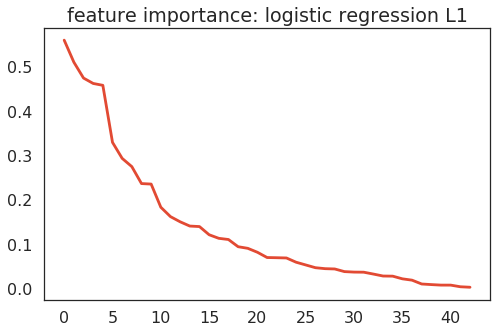

In [170]:
logfullAtable = get_featurename(logistic_selection(dataset['full']['A'],labelset['full']['A'],penalty=2),fullfeaturename)

(40, 2)
40


,0,1,2,3,4
0,snoRNA_ENSG00000201025.1: -0.718,lncRNA_ENSG00000256642.1: -0.4438,Y_RNA_ENSG00000202255.1: 0.4228,Y_RNA_ENSG00000201676.1: 0.4122,miRNA_ENSG00000211583.3: 0.3522
1,tRNA_36015: 0.2573,miRNA_ENSG00000283540.1: 0.2552,lncRNA_ENSG00000250186.3: -0.2283,piRNA_piR.hsa.21148_67: 0.2265,lncRNA_ENSG00000248550.3: 0.2106
2,snRNA_ENSG00000206629.1: 0.2022,snoRNA_ENSG00000252337.1: 0.1977,lncRNA_ENSG00000167912.5: 0.184,piRNA_piR.hsa.21148_10: 0.1674,srpRNA_ENSG00000243420.3: 0.1648
3,lncRNA_ENSG00000264112.1: 0.1646,lncRNA_ENSG00000241772.2: 0.1525,lncRNA_ENSG00000250781.1: 0.1349,tRNA_22351: 0.1298,lncRNA_ENSG00000279302.3: 0.1269
4,lncRNA_ENSG00000226240.1: -0.1155,lncRNA_ENSG00000280136.2: 0.111,lncRNA_ENSG00000223546.6: 0.1104,piRNA_piR.hsa.2621_68: 0.1099,miRNA_ENSG00000207738.1: 0.0904
5,piRNA_piR.hsa.6496: 0.0788,srpRNA_ENSG00000241789.3: 0.0704,lncRNA_ENSG00000255202.1: 0.0666,snRNA_ENSG00000272020.1: 0.0609,lncRNA_ENSG00000249169.1: 0.0586
6,lncRNA_ENSG00000185433.8: 0.0535,lncRNA_ENSG00000264660.2: -0.0502,lncRNA_ENSG00000204283.3: 0.0439,lncRNA_ENSG00000259623.1: 0.0419,lncRNA_ENSG00000233008.5: 0.0414
7,lncRNA_ENSG00000274341.1: 0.0372,lncRNA_ENSG00000235972.1: -0.034,piRNA_piR.hsa.21148_60: 0.0196,lncRNA_ENSG00000227492.1: 0.0162,lncRNA_ENSG00000280059.1: 0.0051


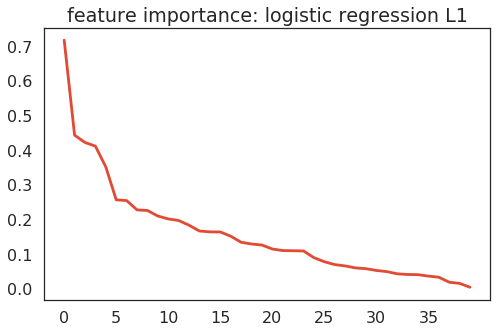

In [171]:
logfullhcctable = get_featurename(logistic_selection(dataset['full']['hcc'],labelset['full']['hcc'],penalty=2),fullfeaturename)

In [172]:
binfeaturenamesplit

array(['miRNA_ENSG00000278267.1', 'miRNA_ENSG00000278267.1',
       'miRNA_ENSG00000278267.1', ..., 'Y_RNA_ENSG00000201778.1',
       'Y_RNA_ENSG00000201778.1', 'Y_RNA_ENSG00000201778.1'], dtype=object)

(83, 2)
50


,0,1,2,3,4
0,tRNA_12975: 0.3877,lncRNA_ENSG00000277837.1: 0.3535,tRNA_12975: 0.3304,piRNA_piR.hsa.20572_3700: -0.3164,lncRNA_ENSG00000276308.1: 0.2452
1,piRNA_piR.hsa.20572_3700: -0.2246,snoRNA_ENSG00000206688.1: 0.2034,snoRNA_ENSG00000206688.1: 0.1775,lncRNA_ENSG00000281344.1: 0.1749,miRNA_ENSG00000276029.1: 0.1595
2,piRNA_piR.hsa.20572_3700: -0.1496,lncRNA_ENSG00000230424.1: 0.1471,snoRNA_ENSG00000206688.1: 0.1343,snoRNA_ENSG00000201025.1: -0.129,snoRNA_ENSG00000206688.1: 0.1067
3,snoRNA_ENSG00000207421.1: 0.1063,lncRNA_ENSG00000280800.1: -0.1044,snRNA_ENSG00000201291.1: 0.0931,lncRNA_ENSG00000233358.2: 0.0834,piRNA_piR.hsa.20572_3700: -0.082
4,lncRNA_ENSG00000230424.1: 0.0815,snoRNA_ENSG00000207344.1: 0.0805,snRNA_ENSG00000252468.1: 0.0803,lncRNA_ENSG00000277837.1: 0.0803,lncRNA_ENSG00000236532.5: 0.0789
5,lncRNA_ENSG00000279738.1: 0.0789,lncRNA_ENSG00000177822.7: 0.0787,lncRNA_ENSG00000280614.1: -0.0773,lncRNA_ENSG00000281181.1: -0.0772,lncRNA_ENSG00000280800.1: -0.0684
6,lncRNA_ENSG00000280800.1: -0.0663,snoRNA_ENSG00000281859.1: 0.0634,snoRNA_ENSG00000201025.1: -0.0633,lncRNA_ENSG00000230606.10: 0.0562,lncRNA_ENSG00000261824.6: 0.043
7,lncRNA_ENSG00000280800.1: -0.0419,lncRNA_ENSG00000281181.1: -0.0419,lncRNA_ENSG00000280800.1: -0.0384,lncRNA_ENSG00000250791.1: 0.0347,lncRNA_ENSG00000229807.10: 0.0326
8,lncRNA_ENSG00000277837.1: 0.0323,lncRNA_ENSG00000260793.2: 0.0319,lncRNA_ENSG00000279738.1: 0.0319,lncRNA_ENSG00000236532.5: 0.0317,lncRNA_ENSG00000229807.10: 0.0307
9,piRNA_piR.hsa.20572_3700: -0.0304,lncRNA_ENSG00000233358.2: 0.0289,snoRNA_ENSG00000281859.1: 0.0274,lncRNA_ENSG00000265179.6: 0.0268,snoRNA_ENSG00000201025.1: -0.0265


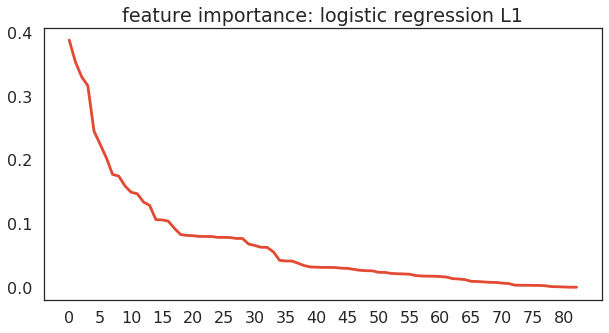

In [173]:
logbinAtable =get_featurename(logistic_selection(dataset['bin']['A'],labelset['bin']['A'],penalty=2),binfeaturenamesplit)

(85, 2)
50


,0,1,2,3,4
0,snoRNA_ENSG00000206688.1: 0.329,snoRNA_ENSG00000206688.1: 0.2271,snoRNA_ENSG00000201025.1: -0.2252,piRNA_piR.hsa.20572_3700: -0.2193,snoRNA_ENSG00000207421.1: 0.1943
1,miRNA_ENSG00000207957.1: 0.1837,piRNA_piR.hsa.20572_3700: -0.1751,snoRNA_ENSG00000281859.1: 0.1651,lncRNA_ENSG00000223387.6: 0.1638,tRNA_24305: 0.1615
2,snoRNA_ENSG00000201025.1: -0.1605,lncRNA_ENSG00000229807.10: 0.1535,snoRNA_ENSG00000201025.1: -0.1517,lncRNA_ENSG00000280800.1: -0.1419,lncRNA_ENSG00000223387.6: 0.14
3,snoRNA_ENSG00000206688.1: 0.1383,lncRNA_ENSG00000226203.1: 0.1371,lncRNA_ENSG00000240405.6: -0.1245,snoRNA_ENSG00000239002.3: 0.1241,lncRNA_ENSG00000280800.1: -0.1229
4,lncRNA_ENSG00000256124.5: -0.1209,lncRNA_ENSG00000229807.10: 0.1171,snRNA_ENSG00000252468.1: 0.1158,piRNA_piR.hsa.20572_3700: -0.1076,tRNA_12975: 0.1002
5,lncRNA_ENSG00000229807.10: 0.0962,lncRNA_ENSG00000279738.1: 0.0957,snoRNA_ENSG00000252337.1: 0.091,lncRNA_ENSG00000279738.1: 0.0905,lncRNA_ENSG00000229807.10: 0.0862
6,snoRNA_ENSG00000206688.1: 0.0848,lncRNA_ENSG00000280184.2: 0.0848,lncRNA_ENSG00000277837.1: 0.0651,lncRNA_ENSG00000228566.1: 0.063,lncRNA_ENSG00000277837.1: 0.0618
7,lncRNA_ENSG00000229807.10: 0.0595,miRNA_ENSG00000207957.1: 0.0586,lncRNA_ENSG00000279738.1: 0.0576,lncRNA_ENSG00000240405.6: -0.0555,lncRNA_ENSG00000248360.7: 0.0549
8,snRNA_ENSG00000276027.1: 0.0499,lncRNA_ENSG00000229807.10: 0.0495,snoRNA_ENSG00000201129.1: 0.0495,tRNA_22351: 0.0491,lncRNA_ENSG00000279670.1: 0.0466
9,lncRNA_ENSG00000229807.10: 0.0464,lncRNA_ENSG00000223387.6: 0.0441,piRNA_piR.hsa.20572_3700: -0.0433,lncRNA_ENSG00000281181.1: -0.0432,lncRNA_ENSG00000280614.1: -0.0414


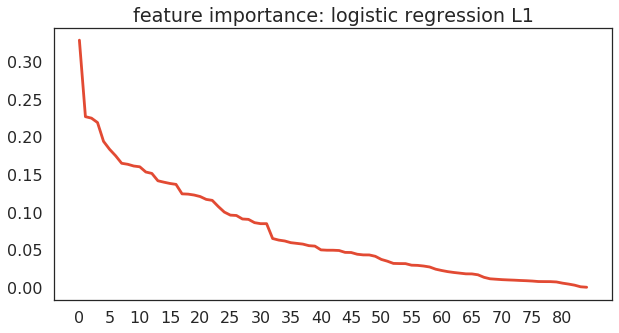

In [174]:
logbinhcctable =get_featurename(logistic_selection(dataset['bin']['hcc'],labelset['bin']['hcc'],penalty=2),binfeaturenamesplit)

(76, 2)
50


,0,1,2,3,4
0,lncRNA_ENSG00000280059.1: 0.2975,lncRNA_ENSG00000229388.1: -0.286,piRNA_piR.hsa.20572_3700: -0.2814,miRNA_ENSG00000221586.1: 0.2795,tRNA_12975: 0.2538
1,tRNA_12975: 0.2202,piRNA_piR.hsa.21148_60: 0.1964,lncRNA_ENSG00000277837.1: 0.1857,lncRNA_ENSG00000212766.9: 0.1822,lncRNA_ENSG00000280800.1: -0.1794
2,snoRNA_ENSG00000206688.1: 0.1644,lncRNA_ENSG00000277837.1: 0.1578,piRNA_piR.hsa.20572_3700: -0.149,piRNA_piR.hsa.21148_10: 0.1437,lncRNA_ENSG00000268573.1: 0.1408
3,snoRNA_ENSG00000206688.1: 0.1243,piRNA_piR.hsa.24000: 0.1121,lncRNA_ENSG00000279488.1: -0.1099,lncRNA_ENSG00000258844.1: 0.1099,lncRNA_ENSG00000280719.1: 0.1089
4,snRNA_ENSG00000222724.1: 0.1086,piRNA_piR.hsa.20572_3700: -0.1071,lncRNA_ENSG00000280800.1: -0.1025,snoRNA_ENSG00000252337.1: 0.0982,lncRNA_ENSG00000279738.1: 0.0844
5,lncRNA_ENSG00000258944.1: 0.0818,lncRNA_ENSG00000277837.1: 0.0766,lncRNA_ENSG00000233358.2: 0.0744,tRNA_12975: 0.0718,lncRNA_ENSG00000281344.1: 0.0644
6,lncRNA_ENSG00000264112.1: 0.0642,snoRNA_ENSG00000207421.1: 0.064,Y_RNA_ENSG00000238783.1: 0.0623,lncRNA_ENSG00000280800.1: -0.0622,lncRNA_ENSG00000277837.1: 0.0621
7,Y_RNA_ENSG00000201676.1: 0.0577,Y_RNA_ENSG00000202255.1: 0.0545,lncRNA_ENSG00000253647.1: 0.0533,lncRNA_ENSG00000280800.1: -0.0518,snoRNA_ENSG00000281859.1: 0.0419
8,lncRNA_ENSG00000229807.10: 0.0412,lncRNA_ENSG00000241158.5: -0.0376,Y_RNA_ENSG00000207401.1: 0.0375,snoRNA_ENSG00000207421.1: 0.0373,lncRNA_ENSG00000227906.7: 0.0354
9,miRNA_ENSG00000207954.1: 0.0324,lncRNA_ENSG00000278924.1: 0.0287,lncRNA_ENSG00000254119.5: 0.025,snoRNA_ENSG00000207313.1: 0.0249,lncRNA_ENSG00000279738.1: 0.0245


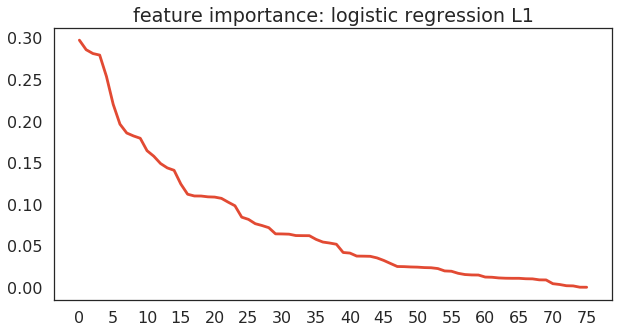

In [175]:
logmixAtable = get_featurename(logistic_selection(dataset['mix']['A'],labelset['mix']['A'],penalty=2),mixfeaturenamesplit)

(95, 2)
50


,0,1,2,3,4
0,lncRNA_ENSG00000259439.2: 0.5447,snoRNA_ENSG00000206688.1: 0.2789,piRNA_piR.hsa.20572_3700: -0.2334,miRNA_ENSG00000207738.1: 0.2228,piRNA_piR.hsa.20572_3700: -0.212
1,snoRNA_ENSG00000201025.1: -0.1923,lncRNA_ENSG00000226240.1: -0.1919,snoRNA_ENSG00000206688.1: 0.1804,lncRNA_ENSG00000280719.1: 0.1786,lncRNA_ENSG00000273149.1: -0.1771
2,snoRNA_ENSG00000206688.1: 0.1546,Y_RNA_ENSG00000202255.1: 0.1529,snoRNA_ENSG00000206688.1: 0.1394,snoRNA_ENSG00000281859.1: 0.134,lncRNA_ENSG00000256642.1: -0.1225
3,miRNA_ENSG00000211583.3: 0.1165,lncRNA_ENSG00000280136.2: 0.1116,lncRNA_ENSG00000279738.1: 0.1026,snoRNA_ENSG00000201025.1: -0.1024,miRNA_ENSG00000283540.1: 0.0998
4,snoRNA_ENSG00000252337.1: 0.0891,lncRNA_ENSG00000277837.1: 0.087,snoRNA_ENSG00000239002.3: 0.0815,snoRNA_ENSG00000252337.1: 0.0814,piRNA_piR.hsa.2621_68: 0.0809
5,lncRNA_ENSG00000240405.6: -0.077,tRNA_12975: 0.0759,piRNA_piR.hsa.20572_3700: -0.0753,lncRNA_ENSG00000280614.1: -0.0745,lncRNA_ENSG00000167912.5: 0.0739
6,lncRNA_ENSG00000280184.2: 0.0733,lncRNA_ENSG00000223387.6: 0.0713,snRNA_ENSG00000272020.1: 0.0695,lncRNA_ENSG00000240405.6: -0.0693,snoRNA_ENSG00000207421.1: 0.0638
7,lncRNA_ENSG00000226203.1: 0.0635,lncRNA_ENSG00000279738.1: 0.061,snRNA_ENSG00000222414.1: 0.0583,lncRNA_ENSG00000223387.6: 0.0534,lncRNA_ENSG00000228566.1: 0.0523
8,srpRNA_ENSG00000243591.3: 0.0523,piRNA_piR.hsa.28186_5: 0.051,lncRNA_ENSG00000280800.1: -0.0469,lncRNA_ENSG00000248550.3: 0.0464,lncRNA_ENSG00000278867.1: 0.046
9,piRNA_piR.hsa.21148_24: 0.0373,snoRNA_ENSG00000201129.1: 0.0371,lncRNA_ENSG00000280184.2: 0.0369,lncRNA_ENSG00000276422.1: 0.0363,lncRNA_ENSG00000264112.1: 0.0339


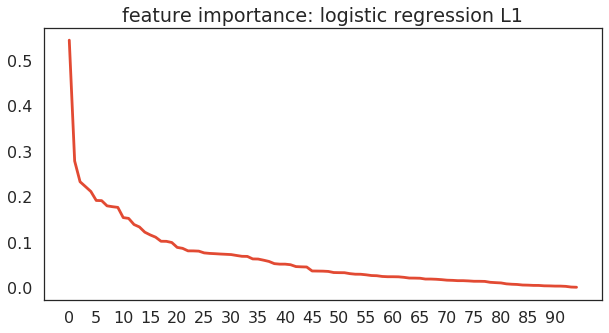

In [176]:
logmixhcctable = get_featurename(logistic_selection(dataset['mix']['hcc'],labelset['mix']['hcc'],penalty=2),mixfeaturenamesplit)

##### 基于树的特征选择

In [46]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
#基于树模型进行模型选择


In [47]:
def get_feature_ind_tree(feature,label):
    clf = ExtraTreesClassifier()
    clf = clf.fit(feature,label)
#特征重要性(数值越高特征越重要)
    return clf.feature_importances_

In [321]:
featurettt = get_feature_ind_tree(dataset['full']['A'],labelset['full']['A'])
dataset['full']['A'][:,np.where(featurettt!=0)[0]].shape

(29, 54)

In [322]:
dataset['full']['A'].shape

(29, 10289)

In [310]:
np.unique(get_feature_ind_tree(dataset['full']['A'],labelset['full']['A']),return_counts=True)

(array([0.        , 0.00365156, 0.00580929, 0.00697115, 0.00929487,
        0.00929487, 0.00929487, 0.01045673, 0.01062271, 0.01081423,
        0.01115385, 0.01122024, 0.01195055, 0.0122044 , 0.0122044 ,
        0.01239316, 0.01267483, 0.01278045, 0.01294643, 0.01294643,
        0.01301282, 0.01420118, 0.01510417, 0.01742788, 0.01991758,
        0.02091346, 0.02103795, 0.02150662, 0.02171783, 0.02188336,
        0.02245858, 0.02263386, 0.02323718, 0.02323718, 0.02788462,
        0.02790876, 0.02966508, 0.03155594, 0.03210702, 0.03384107,
        0.03485577, 0.03916084, 0.0399257 , 0.04134851, 0.04231712,
        0.05200629]),
 array([10238,     1,     1,     1,     4,     1,     1,     2,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     2,     1,     1,     1,
           

In [ ]:
def get_selected_feature(feature,label,method='log'):
    '''
    dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]]
    '''
    if method=='log':
        tmpfeaturecoef = logistic_selection(feature,label,penalty=2)
        tmpind = np.where(tmpfeaturecoef!=0)[0]
        return feature[:,tmpind]
    elif method=='tree':
        tmpfeaturecoef =get_feature_ind_tree(feature,label)
        tmpind = np.where(tmpfeaturecoef!=0)[0]
        return feature[:,tmpind]
    elif method=='mrmr':
        skip

In [69]:
def get_featurename_tree(coef,featurename):
    selectfeatureind = np.where(np.abs(coef)>=0.00001)[0]
    selectfeatureind_ =selectfeatureind[np.argsort(-np.abs(coef[selectfeatureind]))[:np.where(coef!=0)[0].shape[0]]]
    ttttesttab =  pd.DataFrame(np.concatenate((featurename[selectfeatureind_].reshape(-1,1),
                                coef[np.argsort(-np.abs(coef))
                             [:np.where(coef!=0)[0].shape[0]]].reshape(-1,1)),axis=1),
                columns=['ID','importance'])
    countlist_ = []
    if selectfeatureind.shape[0] >=50:
        for i in range(50):
            countlist_.append(ttttesttab.iloc[i,0]+': '+str(np.round(ttttesttab.iloc[i,1],4)))
        display(pd.DataFrame(np.array(countlist_).reshape(-1,5)))
        fig,ax=plt.subplots(1,figsize=(10,5))
        ax.plot(np.abs(np.array(ttttesttab.iloc[:,1])))
        ax.set_xticks(np.arange(0,ttttesttab.shape[0],5))
        ax.set_title('feature importance: Tree based feature selection')
    else:
        numtmp = selectfeatureind.shape[0]
        numtmp_ = int(numtmp/5)*5
        print (numtmp_)
        for i in range(numtmp_):
            countlist_.append(ttttesttab.iloc[i,0]+': '+str(np.round(ttttesttab.iloc[i,1],4)))
        display(pd.DataFrame(np.array(countlist_).reshape(-1,5)))
        fig,ax=plt.subplots(1,figsize=(numtmp/5,5))
        ax.plot(np.abs(np.array(ttttesttab.iloc[:,1])))
        ax.set_xticks(np.arange(0,ttttesttab.shape[0],5))
        ax.set_title('feature importance: Tree based feature selection')
    return ttttesttab

,0,1,2,3,4
0,miRNA_ENSG00000211583.3: 0.0558,tRNA_26898: 0.038,Y_RNA_ENSG00000202255.1: 0.0366,piRNA_piR.hsa.21148_67: 0.0338,snRNA_ENSG00000251748.1: 0.0316
1,lncRNA_ENSG00000175147.11: 0.031,piRNA_piR.hsa.28841: 0.0263,lncRNA_ENSG00000215417.12: 0.0261,piRNA_piR.hsa.20664_50: 0.026,lncRNA_ENSG00000243715.1: 0.026
2,piRNA_piR.hsa.4047_3: 0.0232,lncRNA_ENSG00000227039.6: 0.0232,tRNA_21365: 0.0231,lncRNA_ENSG00000231453.1: 0.0229,lncRNA_ENSG00000275120.2: 0.0223
3,miRNA_ENSG00000283469.1: 0.0213,lncRNA_ENSG00000278611.1: 0.0209,lncRNA_ENSG00000167912.5: 0.0209,tRNA_30953: 0.0207,lncRNA_ENSG00000257891.1: 0.0205
4,lncRNA_ENSG00000257452.1: 0.0201,lncRNA_ENSG00000265477.1: 0.02,lncRNA_ENSG00000248544.2: 0.0199,srpRNA_ENSG00000242764.3: 0.0188,tRNA_21907: 0.0185
5,miRNA_ENSG00000277904.1: 0.0185,lncRNA_ENSG00000228526.6: 0.0174,Y_RNA_ENSG00000202144.1: 0.0171,srpRNA_ENSG00000244357.3: 0.0169,lncRNA_ENSG00000270141.3: 0.0162
6,lncRNA_ENSG00000170161.6: 0.0157,Y_RNA_ENSG00000201548.1: 0.0156,lncRNA_ENSG00000204283.3: 0.0149,lncRNA_ENSG00000270111.2: 0.0139,lncRNA_ENSG00000280080.2: 0.0133
7,lncRNA_ENSG00000224799.1: 0.0129,lncRNA_ENSG00000279593.1: 0.0128,Y_RNA_ENSG00000206690.1: 0.0128,tRNA_28020: 0.0127,Y_RNA_ENSG00000202100.1: 0.0127
8,snoRNA_ENSG00000252011.1: 0.0125,lncRNA_ENSG00000256642.1: 0.0116,miRNA_ENSG00000266104.1: 0.0116,lncRNA_ENSG00000273486.1: 0.0112,tRNA_36095: 0.0105
9,lncRNA_ENSG00000260377.1: 0.0105,lncRNA_ENSG00000283078.1: 0.0103,miRNA_ENSG00000278328.1: 0.0093,lncRNA_ENSG00000260271.1: 0.0093,lncRNA_ENSG00000250436.1: 0.007


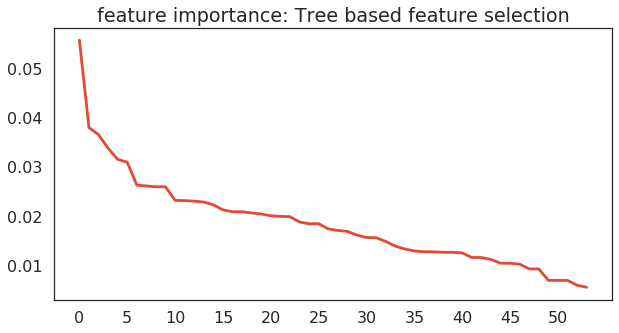

In [177]:
treefullAtable = get_featurename_tree(get_feature_ind_tree(dataset['full']['A'],labelset['full']['A']),fullfeaturename)

,0,1,2,3,4
0,lncRNA_ENSG00000268030.1: 0.0374,piRNA_piR.hsa.2621_24: 0.0312,snoRNA_ENSG00000207233.1: 0.0305,miRNA_ENSG00000199072.3: 0.0304,srpRNA_ENSG00000243420.3: 0.0304
1,lncRNA_ENSG00000272368.2: 0.0301,miRNA_ENSG00000283385.1: 0.0284,lncRNA_ENSG00000235790.7: 0.026,snoRNA_ENSG00000206947.1: 0.0248,lncRNA_ENSG00000279302.3: 0.0232
2,Y_RNA_ENSG00000202255.1: 0.0227,Y_RNA_ENSG00000200600.1: 0.0217,miRNA_ENSG00000266017.1: 0.0217,lncRNA_ENSG00000225399.4: 0.0212,srpRNA_ENSG00000240490.3: 0.0207
3,lncRNA_ENSG00000253553.5: 0.0193,lncRNA_ENSG00000283029.1: 0.0191,snoRNA_ENSG00000201772.1: 0.0188,lncRNA_ENSG00000226240.1: 0.0184,lncRNA_ENSG00000278390.4: 0.0173
4,lncRNA_ENSG00000283341.1: 0.0168,miRNA_ENSG00000207789.1: 0.016,lncRNA_ENSG00000259048.1: 0.0159,tRNA_26896: 0.0158,lncRNA_ENSG00000232956.8: 0.0152
5,lncRNA_ENSG00000280719.1: 0.0152,lncRNA_ENSG00000279122.1: 0.0148,piRNA_piR.hsa.23387_82331: 0.0147,lncRNA_ENSG00000248540.2: 0.0147,lncRNA_ENSG00000228714.2: 0.0143
6,piRNA_piR.hsa.7193_3: 0.0139,lncRNA_ENSG00000280113.2: 0.0139,lncRNA_ENSG00000236255.1: 0.0134,lncRNA_ENSG00000243155.1: 0.0132,lncRNA_ENSG00000260188.1: 0.0124
7,piRNA_piR.hsa.6917: 0.0118,piRNA_piR.hsa.27283: 0.0113,lncRNA_ENSG00000257677.1: 0.0106,lncRNA_ENSG00000246339.5: 0.0106,lncRNA_ENSG00000224794.2: 0.0105
8,miRNA_ENSG00000211991.4: 0.0101,miRNA_ENSG00000207933.3: 0.0099,srpRNA_ENSG00000240306.2: 0.0098,lncRNA_ENSG00000273784.4: 0.0095,srpRNA_ENSG00000265170.2: 0.0095
9,Y_RNA_ENSG00000239823.2: 0.0093,Y_RNA_ENSG00000212448.1: 0.0092,lncRNA_ENSG00000280362.1: 0.0092,miRNA_ENSG00000275518.1: 0.0092,miRNA_ENSG00000264141.1: 0.0092


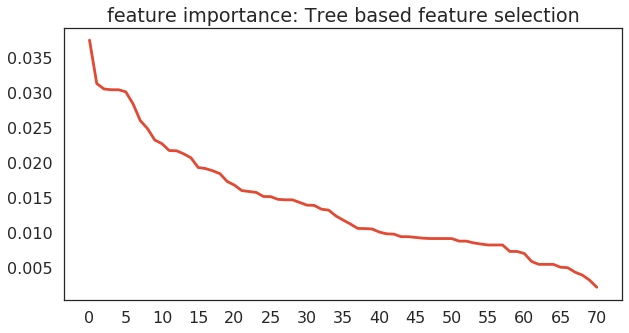

In [178]:
treefullhcctable = get_featurename_tree(get_feature_ind_tree(dataset['full']['hcc'],labelset['full']['hcc']),fullfeaturename)

40


,0,1,2,3,4
0,lncRNA_ENSG00000229807.10: 0.0752,lncRNA_ENSG00000229807.10: 0.0752,lncRNA_ENSG00000225746.9: 0.0554,lncRNA_ENSG00000259439.2: 0.0525,lncRNA_ENSG00000271806.1: 0.0469
1,snoRNA_ENSG00000200087.1: 0.04,tRNA_35059: 0.0378,lncRNA_ENSG00000277837.1: 0.0352,piRNA_piR.hsa.20572_3700: 0.034,lncRNA_ENSG00000260814.2: 0.0338
2,lncRNA_ENSG00000276476.2: 0.0338,lncRNA_ENSG00000251562.7: 0.0281,lncRNA_ENSG00000280011.1: 0.0263,lncRNA_ENSG00000226674.8: 0.0256,lncRNA_ENSG00000280025.1: 0.0248
3,lncRNA_ENSG00000280614.1: 0.0244,lncRNA_ENSG00000272094.1: 0.024,piRNA_piR.hsa.30937_27091: 0.0239,lncRNA_ENSG00000245532.7: 0.0223,piRNA_piR.hsa.31238_3: 0.0211
4,snoRNA_ENSG00000207112.1: 0.021,lncRNA_ENSG00000251562.7: 0.0195,snRNA_ENSG00000222414.1: 0.0195,lncRNA_ENSG00000272702.1: 0.0169,piRNA_piR.hsa.20572_3700: 0.0155
5,lncRNA_ENSG00000280614.1: 0.0153,piRNA_piR.hsa.20572_3700: 0.0131,lncRNA_ENSG00000223949.6: 0.0129,lncRNA_ENSG00000263938.1: 0.0128,lncRNA_ENSG00000277954.1: 0.0127
6,miRNA_ENSG00000207771.1: 0.0127,Y_RNA_ENSG00000201228.1: 0.0127,lncRNA_ENSG00000279266.1: 0.012,lncRNA_ENSG00000280399.1: 0.0105,lncRNA_ENSG00000245526.10: 0.0105
7,lncRNA_ENSG00000232774.7: 0.0105,lncRNA_ENSG00000256955.2: 0.0093,lncRNA_ENSG00000213057.5: 0.0093,lncRNA_ENSG00000231890.7: 0.007,lncRNA_ENSG00000283445.1: 0.0061


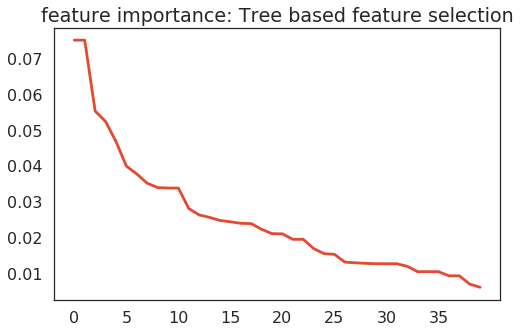

In [179]:
treebinAtable = get_featurename_tree(get_feature_ind_tree(dataset['bin']['A'],labelset['bin']['A']),binfeaturenamesplit)

,0,1,2,3,4
0,piRNA_piR.hsa.20572_3700: 0.0481,lncRNA_ENSG00000278920.1: 0.0449,lncRNA_ENSG00000246695.7: 0.0405,snoRNA_ENSG00000252337.1: 0.0368,lncRNA_ENSG00000226674.8: 0.0355
1,lncRNA_ENSG00000197099.8: 0.0335,lncRNA_ENSG00000274317.1: 0.0304,lncRNA_ENSG00000267943.1: 0.0294,srpRNA_ENSG00000241789.3: 0.0294,lncRNA_ENSG00000226487.1: 0.0293
2,snoRNA_ENSG00000201025.1: 0.0286,Y_RNA_ENSG00000199398.1: 0.0283,lncRNA_ENSG00000220256.3: 0.0251,lncRNA_ENSG00000260604.2: 0.0238,piRNA_piR.hsa.20572_3700: 0.0237
3,lncRNA_ENSG00000259439.2: 0.023,lncRNA_ENSG00000273149.1: 0.0227,lncRNA_ENSG00000277954.1: 0.0227,lncRNA_ENSG00000258711.2: 0.0215,lncRNA_ENSG00000259439.2: 0.0205
4,tRNA_26876: 0.0194,lncRNA_ENSG00000258338.1: 0.019,miRNA_ENSG00000278791.1: 0.0178,tRNA_25611: 0.0176,lncRNA_ENSG00000281344.1: 0.0167
5,lncRNA_ENSG00000235706.7: 0.0165,lncRNA_ENSG00000279738.1: 0.0158,lncRNA_ENSG00000226674.8: 0.0149,lncRNA_ENSG00000281181.1: 0.0147,tRNA_12958: 0.0146
6,lncRNA_ENSG00000225914.1: 0.0132,snoRNA_ENSG00000221381.1: 0.0118,lncRNA_ENSG00000237352.3: 0.0106,lncRNA_ENSG00000279714.1: 0.0106,lncRNA_ENSG00000186019.10: 0.0106
7,lncRNA_ENSG00000226674.8: 0.0106,lncRNA_ENSG00000230536.1: 0.0106,lncRNA_ENSG00000253287.1: 0.0099,lncRNA_ENSG00000250938.5: 0.0099,lncRNA_ENSG00000279912.1: 0.0098
8,miRNA_ENSG00000252466.1: 0.0098,lncRNA_ENSG00000281344.1: 0.0096,lncRNA_ENSG00000234741.7: 0.0096,lncRNA_ENSG00000241956.9: 0.0093,miRNA_ENSG00000198984.1: 0.0092
9,lncRNA_ENSG00000261654.1: 0.009,lncRNA_ENSG00000222041.10: 0.0088,lncRNA_ENSG00000279442.1: 0.0088,lncRNA_ENSG00000284607.1: 0.0083,piRNA_piR.hsa.15404_37259: 0.0083


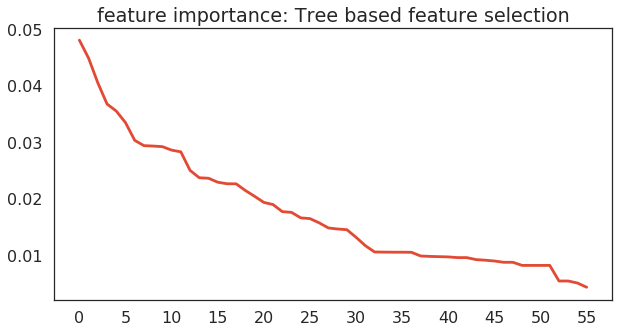

In [180]:
treebinhcctable = get_featurename_tree(get_feature_ind_tree(dataset['bin']['hcc'],labelset['bin']['hcc']),binfeaturenamesplit)

30


,0,1,2,3,4
0,lncRNA_ENSG00000246695.7: 0.0752,lncRNA_ENSG00000253287.1: 0.0554,lncRNA_ENSG00000279217.1: 0.0554,lncRNA_ENSG00000277837.1: 0.0554,lncRNA_ENSG00000280614.1: 0.0434
1,lncRNA_ENSG00000184809.12: 0.0431,lncRNA_ENSG00000237057.2: 0.0399,lncRNA_ENSG00000226674.8: 0.0392,lncRNA_ENSG00000255076.2: 0.0388,lncRNA_ENSG00000234456.7: 0.0353
2,lncRNA_ENSG00000280244.1: 0.0329,piRNA_piR.hsa.21148_60: 0.0324,lncRNA_ENSG00000281344.1: 0.0321,lncRNA_ENSG00000284237.1: 0.0285,lncRNA_ENSG00000255135.3: 0.028
3,lncRNA_ENSG00000240405.6: 0.026,lncRNA_ENSG00000237352.3: 0.0248,miRNA_ENSG00000207954.1: 0.0248,snoRNA_ENSG00000207493.1: 0.0243,lncRNA_ENSG00000246695.7: 0.0239
4,lncRNA_ENSG00000280163.1: 0.0236,lncRNA_ENSG00000224924.6: 0.0236,tRNA_36231: 0.0211,lncRNA_ENSG00000242086.8: 0.0209,lncRNA_ENSG00000203362.2: 0.0209
5,snRNA_ENSG00000206702.1: 0.0207,lncRNA_ENSG00000267520.2: 0.0199,lncRNA_ENSG00000228857.2: 0.0186,piRNA_piR.hsa.20572_3700: 0.0131,piRNA_piR.hsa.22380: 0.0125


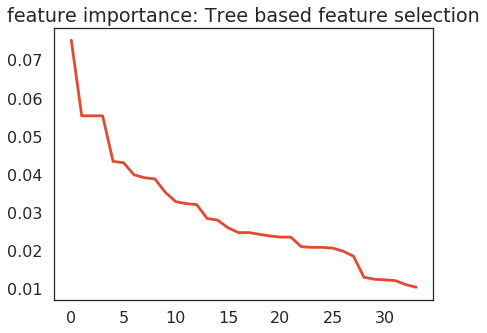

In [181]:
treemixAtable = get_featurename_tree(get_feature_ind_tree(dataset['mix']['A'],labelset['mix']['A']),mixfeaturenamesplit)

,0,1,2,3,4
0,lncRNA_ENSG00000273492.5: 0.0463,lncRNA_ENSG00000234456.7: 0.0432,lncRNA_ENSG00000226674.8: 0.0432,snoRNA_ENSG00000272034.1: 0.0374,lncRNA_ENSG00000284716.1: 0.0374
1,lncRNA_ENSG00000272008.1: 0.0368,lncRNA_ENSG00000281181.1: 0.031,srpRNA_ENSG00000263941.2: 0.0304,lncRNA_ENSG00000263938.1: 0.0304,miRNA_ENSG00000278449.1: 0.0299
2,snoRNA_ENSG00000201998.1: 0.0289,snoRNA_ENSG00000206688.1: 0.0263,Y_RNA_ENSG00000207420.1: 0.0253,piRNA_piR.hsa.15404_37259: 0.0248,lncRNA_ENSG00000260816.2: 0.0241
3,lncRNA_ENSG00000281392.1: 0.0237,snoRNA_ENSG00000200564.1: 0.0232,lncRNA_ENSG00000224905.6: 0.0227,lncRNA_ENSG00000279217.1: 0.0222,lncRNA_ENSG00000280800.1: 0.0205
4,piRNA_piR.hsa.20572_3700: 0.0204,piRNA_piR.hsa.20572_3700: 0.0203,lncRNA_ENSG00000225914.1: 0.0192,lncRNA_ENSG00000280156.1: 0.0181,miRNA_ENSG00000207800.3: 0.017
5,lncRNA_ENSG00000235706.7: 0.0156,lncRNA_ENSG00000280156.1: 0.0156,srpRNA_ENSG00000265052.2: 0.0149,lncRNA_ENSG00000226674.8: 0.0131,Y_RNA_ENSG00000222395.2: 0.0124
6,snoRNA_ENSG00000207297.1: 0.0121,snoRNA_ENSG00000206622.1: 0.0113,piRNA_piR.hsa.20572_3700: 0.0107,lncRNA_ENSG00000226674.8: 0.0107,lncRNA_ENSG00000276449.1: 0.0107
7,lncRNA_ENSG00000220256.3: 0.0106,lncRNA_ENSG00000259895.1: 0.0106,piRNA_piR.hsa.20572_3700: 0.01,snoRNA_ENSG00000202269.1: 0.01,lncRNA_ENSG00000234290.2: 0.0098
8,lncRNA_ENSG00000227195.10: 0.0098,snoRNA_ENSG00000274266.1: 0.0096,lncRNA_ENSG00000226674.8: 0.0093,piRNA_piR.hsa.20572_3700: 0.009,lncRNA_ENSG00000268555.1: 0.0088
9,lncRNA_ENSG00000279296.1: 0.0088,piRNA_piR.hsa.20572_3700: 0.0088,miRNA_ENSG00000277138.1: 0.0083,lncRNA_ENSG00000269821.1: 0.0083,lncRNA_ENSG00000275512.1: 0.0083


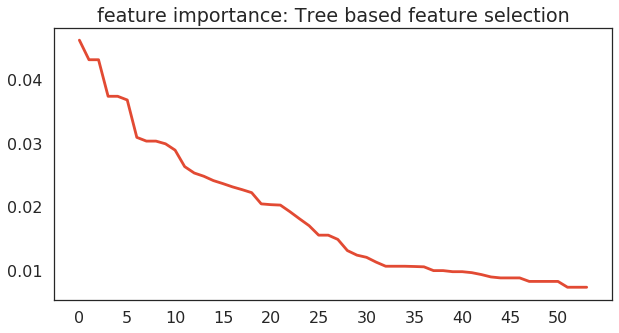

In [182]:
treemixhcctable = get_featurename_tree(get_feature_ind_tree(dataset['mix']['hcc'],labelset['mix']['hcc']),mixfeaturenamesplit)

#### MRMR

##### 准备csv文件
先用差异表达选前一万！
/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/edgeR.result
- HCC_HD+HBV.edgeR.result
- stageA_HD+HBV.edgeR.result

##### 利用方差选特征

##### DE first 10000、5000

##### 不用DE选了，MRMR可以用10000以上的

In [430]:
def get_de_top_name(num,datatype='full',dataclass='hcc'):
    if datatype=='bin':
        if dataclass=='hcc':
            return pd.read_table('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/0.name/edgeR.result/HCC_HD+HBV.edgeR.result')['genes'][:num]
        elif dataclass =='stageA':
            return pd.read_table('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/0.name/edgeR.result/stageA_HD+HBV.edgeR.result')['genes'][:num]
    elif datatype=='full':
        if dataclass=='hcc':
            return pd.read_table('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/1.name_full/HCC_HD+HBV.edgeR.result')['genes'][:num]
        elif dataclass =='stageA':
            return pd.read_table('/Share/home/caojingyi/exRNA/process/18.new_hcc_lulab/06.DE/1.name_full/stageA_HD+HBV.edgeR.result')['genes'][:num]

In [288]:
np.where(np.array(get_de_top_name(10000,datatype='bin',dataclass='hcc'))==np.array(get_de_top_name(10000,datatype='bin',dataclass='hcc')))

(array([   0,    1,    2, ..., 9997, 9998, 9999]),)

In [281]:
np.sum(np.isin(binfeaturename,np.array(get_de_top_name(10000,datatype='bin',dataclass='hcc'))))

8494

In [421]:
np.arange(0,binfeaturename.shape[0])[np.isin(binfeaturename,np.array(get_de_top_name(10000,datatype='bin',
                                                                                     dataclass='hcc')))]

array([   44,    45,    54, ..., 64030, 64031, 64032])

In [376]:
dataset[datatype[i]][dataclass[j]][:,index].shape

(43, 89514)

In [441]:
def extract_feature_after_de(i,j,extractnum):
    '''
    i = 0,1 extractnum=9900
    i=2 extractnum=4950
    '''
    dattype=['full','bin','mix']
    clastype=['hcc','stageA']
    if i <2:
        toparr = np.array(get_de_top_name(extractnum,datatype=dattype[i],dataclass=clastype[j]))
    elif i==2:
        toparr = np.concatenate((np.array(get_de_top_name(extractnum,datatype=dattype[0],dataclass=clastype[j])),
                                np.array(get_de_top_name(extractnum,datatype=dattype[1],dataclass=clastype[j]))))
    if dattype[i] =='full':
        originarr = fullfeaturename
    elif dattype[i] =='bin':
        originarr = binfeaturename
    elif dattype[i] =='mix':
        originarr = mixfeaturename
    index = np.arange(0,originarr.shape[0])[np.isin(originarr,toparr)]
    return dataset[datatype[i]][dataclass[j]][:,index],index

In [ ]:
#注意六种数据的index和dataset都不一样

In [459]:
datafromde = {}
for i in range(2):
    datafromde[i] = {}
    for j in range(2):
        datafromde[i][j] = extract_feature_after_de(i,j,10000)[0]
for i in [2]:
    datafromde[i] = {}
    for j in range(2):
        datafromde[i][j] = extract_feature_after_de(i,j,5000)[0]

In [491]:
np.sum(np.isin(namefromde[0][0], namefromde[0][1]))

4229

array([    2,     3,     4, ..., 25254, 25255, 25256])

In [485]:
dataset[datatype[0]][dataclass[0]].shape

(29, 25257)

In [486]:
dataset[datatype[0]][dataclass[1]].shape

(43, 25257)

In [483]:
dataset[datatype[0]][dataclass[0]][:,namefromde[0][1]].shape

(29, 4229)

In [434]:
def savefeature_tocsv(i,j):
    dataclass= ['hcc','A']
    tmpdataframe= pd.DataFrame(np.concatenate((labelset[datatype[i]][dataclass[j]].reshape(-1,1).astype('int'),
                             datafromde[i][j]),axis=1),
             columns=np.concatenate((np.array(['class']),
                                     np.array(['v'+str(i) for i in np.arange(1,1+datafromde[i][j].shape[1])]))))
    tmpdataframe.iloc[:,0] = tmpdataframe.iloc[:,0].astype('int')
    tmpdataframe.to_csv('featurecsv/'+datatype[i]+dataclass[j]+'.csv')

In [497]:
dataclass

['A', 'hcc']

In [435]:
for i in range(3):
    for j in range(2):
        savefeature_tocsv(i,j)

#### 跳过DE

In [343]:
dataclass

['A', 'hcc']

In [378]:
dataset[datatype[i]][dataclass[j]]*10000

array([[ -9541.63982471, -15546.71434405,  -3376.14776193, ...,
          7292.24992726,   7292.44514241,   1792.90567985],
       [ 11608.00734545,  10517.03436629,   -363.39749434, ...,
         -5931.82097115,  -5931.78842397,  -6661.19110178],
       [ -4604.47755226,   1930.57972042,  -3317.16461724, ...,
         -8670.04395009,  -8669.96515997, -10154.775021  ],
       ...,
       [  5741.94350202,   7438.66663988,  -1699.66245687, ...,
         23999.84762105,  24000.09393318,  20501.47477285],
       [-23747.88838876, -22281.97082944, -20198.33810392, ...,
         -8258.72934504,  -8258.69211275,  -9324.61428199],
       [ -6374.01166877, -15108.99615446,    772.40561953, ...,
          9650.84891707,   9651.05232892,  10576.52576996]])

In [379]:
def savefeature_tocsv_(i,j):
    #dataclass= ['hcc','A']
    tmpdataframe= pd.DataFrame(np.concatenate((labelset[datatype[i]][dataclass[j]].reshape(-1,1).astype('int'),
                             dataset[datatype[i]][dataclass[j]]*10000),axis=1),
             columns=np.concatenate((np.array(['class']),
                                     np.array(['v'+str(i) for i in np.arange(1,1+dataset[datatype[i]][dataclass[j]].shape[1])]))))
    tmpdataframe.iloc[:,0] = tmpdataframe.iloc[:,0].astype('int')
    tmpdataframe.to_csv('featurecsv/'+datatype[i]+dataclass[j]+'node.csv')

In [721]:
def savefeature_tocsv_class(i,j):
    #dataclass= ['hcc','A']
    tmpdataframe= pd.DataFrame(  dataset[datatype[i]][dataclass[j]],
             columns=np.array(  ['v'+str(i) for i in np.arange(1,1+dataset[datatype[i]][dataclass[j]].shape[1]) ]))
    tmpdataframe.set_index(sampleclass.reshape(-1,1).astype('str')  )                         
    tmpdataframe.iloc[:,0] = tmpdataframe.iloc[:,0].astype('int')
    tmpdataframe.to_csv('featurecsv/'+datatype[i]+dataclass[j]+'nodeclass.csv')
    print ('featurecsv/'+datatype[i]+dataclass[j]+'nodeclass.csv') 

In [722]:
for i in range(3):
    for j in range(2):
        if j %2 ==1:
            savefeature_tocsv_class(i,j)

featurecsv/fullhccnodeclass.csv
featurecsv/binhccnodeclass.csv
featurecsv/mixhccnodeclass.csv


In [349]:
for i in range(3):
    for j in range(2):
        print (datatype[i]+dataclass[j])

fullA
fullhcc
binA
binhcc
mixA
mixhcc


In [ ]:
labelset[datatype[i]][dataclass[j]]

In [82]:
datatype

['full', 'bin', 'mix']

In [88]:
dataset['mix']['hcc'].shape

(43, 56035)

In [89]:
dataset['full']['hcc'].shape

(43, 10289)

In [90]:
dataset['bin']['hcc'].shape

(43, 45746)

In [91]:
dataset['bin']['A'].shape

(29, 45746)

In [ ]:
labelset['full']['A']

MRMR 使用

	 -i <dataset>    maxmum variable:10000
	 -t <threshold> a float number of the discretization threshold; non-specifying this parameter means no discretizaton (i.e. data is already integer); 0 to make binarization.
	 -n <number of features>   a natural number, default is 50.
	 -m <selection method>    either "MID" or "MIQ" (Capital case), default is MID.
	 -s <MAX number of samples>   a natural number, default is 1000. Note that if you don't have or don't need big memory, set this value small, as this program will use this value to pre-allocate memory in data file reading.
	 -v <MAX number of variables/attibutes in data>   a natural number, default is 10000. Note that if you don't have or don't need big memory, set this value small, as this program will use this value to pre-allocate memory in data file reading.
	 [-h] print this message.

In [672]:
pwd

'/home/chenxupeng/projects/training'

In [691]:
pd.read_table('featurecsv/fullhccnodeclass.csv',sep=',')

,Unnamed: 0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v10280,v10281,v10282,v10283,v10284,v10285,v10286,v10287,v10288,v10289
0,0,0,-1.554671,-0.337615,1.133496,0.991877,1.541264,-1.075221,-0.582518,-1.130457,...,-0.399916,-1.056625,0.974866,-0.882281,-1.415994,0.816505,0.302380,-1.221969,-0.543647,0.729225
1,1,1,1.051703,-0.036340,-0.461632,-0.619777,-0.374730,-0.148785,0.439594,0.295231,...,0.549383,3.378979,2.319448,1.487339,1.778927,1.535327,-0.608672,1.051044,2.431194,-0.593182
2,2,0,0.193058,-0.331716,0.245621,0.205201,0.547271,0.126188,0.553399,-1.707645,...,-0.613014,0.892671,1.412708,0.608797,-0.119990,0.893499,-0.332309,0.549830,0.163566,-0.867004
3,3,0,-0.071877,-1.061653,-0.404115,-0.320595,-0.321275,0.657787,0.953264,-0.830801,...,0.441055,-0.471486,-0.645411,-0.743546,-0.328507,-0.495668,-0.609181,-0.303892,-0.412368,0.144023
4,4,0,0.400782,1.642292,-0.299177,-0.336754,-0.248961,0.212185,0.306973,0.122520,...,0.876594,0.872923,0.375471,0.054139,1.639900,0.267265,-0.325681,1.346746,0.249086,0.101589
5,5,0,0.012739,-0.254381,0.768681,0.850496,1.111177,-0.854953,-0.070200,0.080778,...,-0.920716,-0.994833,0.972817,-0.726830,-0.538768,-0.011602,2.030008,-1.053746,-0.884015,-0.942653
6,6,0,0.889255,-1.312551,-0.525367,-0.393089,-0.168374,0.320761,0.346006,0.523161,...,-0.555148,0.343000,1.171995,3.501003,2.437708,-0.252729,-0.281652,2.684744,-0.808897,-0.613238
7,7,0,1.236441,-1.301752,0.698115,0.930735,0.476209,0.661898,0.175442,0.991656,...,-1.020496,-0.381801,-0.853930,0.247049,-0.636613,-0.317265,-0.535829,0.736770,0.569193,-1.047130
8,8,0,0.277837,-1.199437,-0.112568,0.014599,0.022455,1.289591,-0.201549,0.548361,...,0.878878,-0.185921,-0.365783,0.146602,-0.619250,0.275839,-0.574610,-0.682029,0.363537,0.355357
9,9,0,0.006574,-0.472840,0.240846,0.285363,0.365060,0.596253,-0.597777,-0.813323,...,0.246155,0.335780,0.366045,1.934253,1.604434,-0.312238,-0.152017,2.382647,-0.389408,-0.395831


In [ ]:
./mrmr -i ../featurecsv/fullhccnode.csv -m MID -n 100 -t 0.5 -v 12000 >../mrmrout/fullhcc.out
./mrmr -i ../featurecsv/fullAnode.csv -m MID -n 100 -t 0.5 -v 12000 >../mrmrout/fullA.out
./mrmr -i ../featurecsv/binhccnode.csv -m MID -n 100 -t 0.5 -v 46000 >../mrmrout/binhcc.out
./mrmr -i ../featurecsv/mixhccnode.csv -m MID -n 100 -t 0.5 -v 57000 >../mrmrout/mixhcc.out
./mrmr -i ../featurecsv/binAnode.csv -m MID -n 100 -t 0.5 -v 46000 >../mrmrout/binA.out
./mrmr -i ../featurecsv/mixAnode.csv -m MID -n 100 -t 0.5 -v 57000 >../mrmrout/mixA.out

In [ ]:
./mrmr -i featurecsv/fullhccnode.csv -m MIQ -n 100 -t 0.5 -v 12000 >mrmrout7.25/fullhcc.out

In [ ]:
./mrmr -i featurecsv/fullhccnodenclass.csv -m MIQ -n 100 -v 12000 >mrmrout/fullhcc.out.txt
./mrmr -i featurecsv/fullAnodeclass.csv -m MIQ -n 100 -v 12000 >mrmrout7.25/fullA.out.txt
./mrmr -i featurecsv/binhccnodeclass.csv -m MIQ -n 100 -v 46000 >mrmrout7.25/binhcc.out.txt
./mrmr -i featurecsv/mixhccnodeclass.csv -m MIQ -n 100 -v 57000 >mrmrout7.25/mixhcc.out.txt
./mrmr -i featurecsv/binAnodeclass.csv -m MIQ -n 100  -v 46000 >mrmrout7.25/binA.out.txt
./mrmr -i featurecsv/mixAnodeclass.csv -m MIQ -n 100 -v 57000 >mrmrout7.25/mixA.out.txt

./mrmr -i fullhccnodenclass.csv -m MIQ -n 100 -v 12000 >mrmrout/fullhcc.out.txt

In [460]:
namefromde = {}
for i in range(2):
    namefromde[i] = {}
    for j in range(2):
        namefromde[i][j] = extract_feature_after_de(i,j,10000)[1]
for i in [2]:
    namefromde[i] = {}
    for j in range(2):
        namefromde[i][j] = extract_feature_after_de(i,j,5000)[1]

In [ ]:
fullfeaturename[namefromde[0][0]]

In [698]:
tttmrmrind = np.loadtxt('mrmrout7.25/fullhcc.out.txt',dtype='str')[1:,1].astype('int')

In [726]:
dattype=['full','bin','mix']
clastype=['A','hcc']
indfrommrmr = {}
coeffrommrmr = {}
for i in range(2,3):
    indfrommrmr[i],coeffrommrmr[i] = {},{}
    for j in range(1,2):
        indfrommrmr[i][j] = np.loadtxt('mrmrout7.25/'+dattype[i]+clastype[j]+'.out.txt',dtype='str')[1:,1].astype('int')
        coeffrommrmr[i][j] = np.loadtxt('mrmrout7.25/'+dattype[i]+clastype[j]+'.out.txt',dtype='str')[1:,3].astype('float')

In [383]:
indfrommrmr

{0: {0: array([ 1629,  1857,  2334,  7888,  3450,  9796,  2950,  9476,  7973,
          7715,  8497,  6301,  4703,  3253,  6215,  1446,  9405,  3354,
          7338,  1920,  8378,  7773,  8854,  1837,  1869,  8327,  9432,
          5518,   575,   915,   981,  8343,  7011,  8255,  8124,  8502,
          1815,   180,  8129,  4664,  4533,  1927,  9942,  7805,  3487,
          8225,  3526,  7136,  8127,  7096,  5581,  9143,  1330,  4827,
          1769,  9491,  9918,  3296,  9818,  9237,  6288,  9966, 10002,
          3927,  1074,   686,  1676,  8392,  1187,  9070,  7967,   780,
          7110,   863,  9444,   502,  4339,  6516,  8361,   504,  8591,
          5579,  8433,  3430,  1027,  9490,  8109,   253,  6323,  5496,
          9264,  3189,  4492,  6426,  5513,  4507,  8003,  5535,  9061,
           592]),
  1: array([ 6652,  2644,  8653,  6864,  8361,   463,  9285,  9624,   321,
          3430,  9795,  7804,  5249, 10243,   207,  2834,  9714,  3296,
          5364,  3761,  5142,   508, 

In [98]:
def get_featurename_mrmr(name,coef):
    
    ttttesttab =  pd.DataFrame(np.concatenate((name.reshape(-1,1),
                                coef.reshape(-1,1)),axis=1),
                columns=['ID','importance'])
    countlist_ = []
    if ttttesttab.shape[0] >=50:
        for i in range(50):
            countlist_.append(ttttesttab.iloc[i,0]+': '+str(np.round(ttttesttab.iloc[i,1],4)))
        display(pd.DataFrame(np.array(countlist_).reshape(-1,5)))
        fig,ax=plt.subplots(1,figsize=(10,5))
        ax.plot(np.abs(np.array(ttttesttab.iloc[:,1])))
        ax.set_xticks(np.arange(0,ttttesttab.shape[0],5))
        ax.set_title('feature importance: DE and MRMR combined selection')
    else:
        numtmp = ttttesttab.shape[0]
        numtmp_ = numtmp/5*5
        for i in range(numtmp_):
            countlist_.append(ttttesttab.iloc[i,0]+': '+str(np.round(ttttesttab.iloc[i,1],4)))
        display(pd.DataFrame(np.array(countlist_).reshape(-1,5)))
        fig,ax=plt.subplots(1,figsize=(numtmp/5,5))
        ax.plot(np.abs(np.array(ttttesttab.iloc[:,1])))
        ax.set_xticks(np.arange(0,ttttesttab.shape[0],5))
        ax.set_title('feature importance: MRMR Score')
    return ttttesttab

,0,1,2,3,4
0,lncRNA_ENSG00000254377.5: 1.584,snRNA_ENSG00000199562.1: 1.58,lncRNA_ENSG00000240498.6: 1.573,lncRNA_ENSG00000234255.8: 1.566,Y_RNA_ENSG00000207218.1: 1.561
1,lncRNA_ENSG00000250920.1: 1.553,tRNA_31861: 1.546,lncRNA_ENSG00000274272.1: 1.546,lncRNA_ENSG00000238121.5: 1.542,lncRNA_ENSG00000197322.3: 1.542
2,lncRNA_ENSG00000279971.1: 1.536,lncRNA_ENSG00000268621.5: 1.537,snRNA_ENSG00000212541.1: 1.538,lncRNA_ENSG00000250208.6: 1.535,lncRNA_ENSG00000282798.1: 1.533
3,lncRNA_ENSG00000280132.1: 1.53,lncRNA_ENSG00000280309.1: 1.531,lncRNA_ENSG00000258443.1: 1.528,miRNA_ENSG00000284585.1: 1.528,srpRNA_ENSG00000239211.3: 1.526
4,lncRNA_ENSG00000258545.5: 1.527,lncRNA_ENSG00000234155.1: 1.526,lncRNA_ENSG00000236209.1: 1.524,srpRNA_ENSG00000239822.3: 1.523,lncRNA_ENSG00000235824.4: 1.524
5,lncRNA_ENSG00000258283.1: 1.524,lncRNA_ENSG00000277448.1: 1.524,lncRNA_ENSG00000237126.8: 1.522,lncRNA_ENSG00000230185.4: 1.522,lncRNA_ENSG00000262298.1: 1.521
6,lncRNA_ENSG00000232855.6: 1.522,lncRNA_ENSG00000269937.1: 1.52,lncRNA_ENSG00000243836.5: 1.519,miRNA_ENSG00000284176.1: 1.519,lncRNA_ENSG00000273213.1: 1.521
7,miRNA_ENSG00000207952.1: 1.521,tRNA_28620: 1.52,lncRNA_ENSG00000265666.1: 1.521,lncRNA_ENSG00000257242.7: 1.52,miRNA_ENSG00000265669.1: 1.518
8,piRNA_piR.hsa.4047_12: 1.518,piRNA_piR.hsa.30958_23: 1.516,snRNA_ENSG00000201021.1: 1.517,lncRNA_ENSG00000267149.2: 1.518,miRNA_ENSG00000283764.1: 1.518
9,lncRNA_ENSG00000246339.5: 1.516,snRNA_ENSG00000200378.1: 1.516,lncRNA_ENSG00000259771.1: 1.517,srpRNA_ENSG00000274168.1: 1.516,lncRNA_ENSG00000276855.1: 1.517


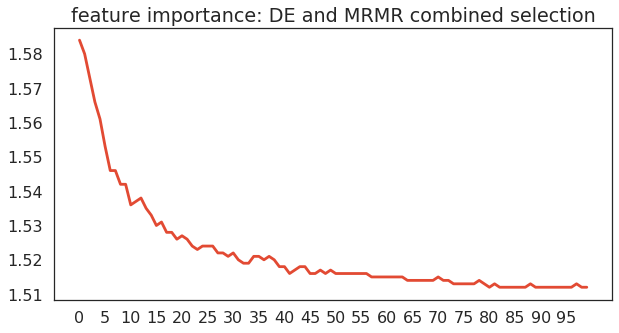

In [183]:
mrmrfullhcctable = get_featurename_mrmr(fullfeaturename[indfrommrmr[0][0]],coeffrommrmr[0][0])

,0,1,2,3,4
0,piRNA_piR.hsa.2621_35: 1.583,lncRNA_ENSG00000116883.8: 1.575,lncRNA_ENSG00000188660.3: 1.558,lncRNA_ENSG00000258977.1: 1.558,lncRNA_ENSG00000260751.2: 1.544
1,srpRNA_ENSG00000241064.3: 1.541,snoRNA_ENSG00000212195.2: 1.534,piRNA_piR.hsa.30715_4140: 1.535,srpRNA_ENSG00000244642.3: 1.532,miRNA_ENSG00000207804.1: 1.52
2,lncRNA_ENSG00000269807.1: 1.51,Y_RNA_ENSG00000206690.1: 1.508,srpRNA_ENSG00000241162.3: 1.507,srpRNA_ENSG00000263426.2: 1.507,lncRNA_ENSG00000237126.8: 1.503
3,lncRNA_ENSG00000267519.5: 1.505,lncRNA_ENSG00000284710.1: 1.496,piRNA_piR.hsa.15399_8: 1.495,miRNA_ENSG00000264725.1: 1.496,lncRNA_ENSG00000237596.6: 1.495
4,lncRNA_ENSG00000266256.1: 1.494,lncRNA_ENSG00000231083.1: 1.492,lncRNA_ENSG00000280136.2: 1.492,lncRNA_ENSG00000272695.1: 1.489,piRNA_piR.hsa.10453_15: 1.489
5,lncRNA_ENSG00000276166.1: 1.488,piRNA_piR.hsa.28527_5: 1.487,lncRNA_ENSG00000236069.1: 1.489,lncRNA_ENSG00000262094.1: 1.491,srpRNA_ENSG00000263672.2: 1.488
6,lncRNA_ENSG00000279901.1: 1.489,lncRNA_ENSG00000249574.1: 1.489,lncRNA_ENSG00000277675.1: 1.485,srpRNA_ENSG00000239744.3: 1.486,lncRNA_ENSG00000251637.6: 1.486
7,lncRNA_ENSG00000234380.1: 1.485,lncRNA_ENSG00000279905.1: 1.484,piRNA_piR.hsa.23387_86860: 1.483,miRNA_ENSG00000284155.1: 1.482,Y_RNA_ENSG00000201412.1: 1.482
8,lncRNA_ENSG00000231992.1: 1.482,lncRNA_ENSG00000235295.1: 1.484,lncRNA_ENSG00000279758.1: 1.482,lncRNA_ENSG00000280152.1: 1.482,lncRNA_ENSG00000231955.1: 1.482
9,snoRNA_ENSG00000201264.1: 1.483,lncRNA_ENSG00000264954.1: 1.482,srpRNA_ENSG00000244107.3: 1.481,lncRNA_ENSG00000205018.2: 1.481,piRNA_piR.hsa.4047_12: 1.482


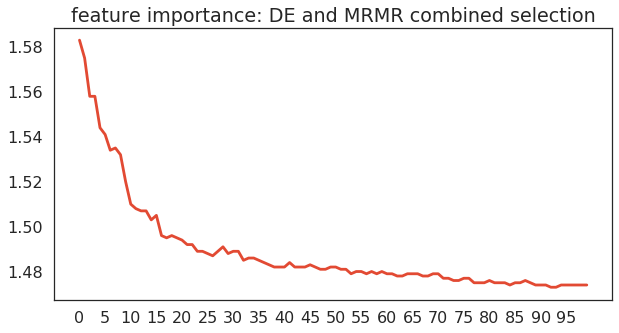

In [184]:
mrmrfullAtable = get_featurename_mrmr(fullfeaturename[indfrommrmr[0][1]],coeffrommrmr[0][1])

,0,1,2,3,4
0,miRNA_ENSG00000284464.1: 1.584,lncRNA_ENSG00000227456.7: 1.58,piRNA_piR.hsa.20572_3700: 1.56,lncRNA_ENSG00000225489.6: 1.55,lncRNA_ENSG00000187621.14: 1.536
1,lncRNA_ENSG00000275226.1: 1.537,miRNA_ENSG00000266107.1: 1.537,lncRNA_ENSG00000245532.7: 1.527,lncRNA_ENSG00000279300.1: 1.53,lncRNA_ENSG00000254166.2: 1.522
2,srpRNA_ENSG00000263669.2: 1.524,lncRNA_ENSG00000225914.1: 1.521,lncRNA_ENSG00000236830.6: 1.518,lncRNA_ENSG00000268592.3: 1.519,lncRNA_ENSG00000230606.10: 1.518
3,piRNA_piR.hsa.20572_3700: 1.517,tRNA_36084: 1.518,srpRNA_ENSG00000264933.2: 1.517,srpRNA_ENSG00000277483.1: 1.516,lncRNA_ENSG00000274762.1: 1.515
4,srpRNA_ENSG00000263608.2: 1.513,lncRNA_ENSG00000249267.6: 1.513,lncRNA_ENSG00000257891.1: 1.508,lncRNA_ENSG00000268416.1: 1.511,srpRNA_ENSG00000276200.1: 1.51
5,srpRNA_ENSG00000264041.2: 1.511,lncRNA_ENSG00000187621.14: 1.508,tRNA_24592: 1.51,lncRNA_ENSG00000264247.1: 1.509,piRNA_piR.hsa.20572_3700: 1.51
6,lncRNA_ENSG00000280156.1: 1.508,lncRNA_ENSG00000273213.1: 1.508,lncRNA_ENSG00000245532.7: 1.508,miRNA_ENSG00000199024.1: 1.508,piRNA_piR.hsa.20572_3700: 1.506
7,tRNA_20561: 1.506,lncRNA_ENSG00000253510.1: 1.505,piRNA_piR.hsa.20572_3700: 1.506,lncRNA_ENSG00000231683.6: 1.505,tRNA_20656: 1.503
8,lncRNA_ENSG00000231365.5: 1.503,lncRNA_ENSG00000245532.7: 1.503,lncRNA_ENSG00000246273.6: 1.502,srpRNA_ENSG00000264573.2: 1.504,tRNA_36092: 1.504
9,srpRNA_ENSG00000265052.2: 1.504,lncRNA_ENSG00000228784.7: 1.503,miRNA_ENSG00000207638.1: 1.502,srpRNA_ENSG00000264530.2: 1.502,miRNA_ENSG00000264616.1: 1.501


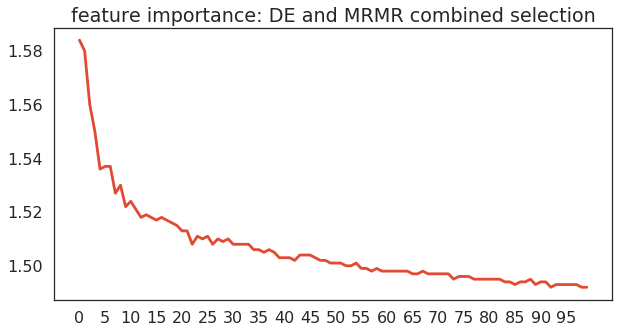

In [185]:
mrmrbinhcctable = get_featurename_mrmr(binfeaturenamesplit[indfrommrmr[1][0]],coeffrommrmr[1][0])

,0,1,2,3,4
0,lncRNA_ENSG00000235781.1: 1.583,lncRNA_ENSG00000272054.1: 1.575,Y_RNA_ENSG00000200742.1: 1.55,srpRNA_ENSG00000263669.2: 1.544,lncRNA_ENSG00000220891.1: 1.523
1,lncRNA_ENSG00000280156.1: 1.518,piRNA_piR.hsa.27728_2: 1.519,srpRNA_ENSG00000242158.3: 1.505,Y_RNA_ENSG00000200060.1: 1.495,lncRNA_ENSG00000263938.1: 1.496
2,lncRNA_ENSG00000226375.1: 1.488,srpRNA_ENSG00000265735.2: 1.487,lncRNA_ENSG00000280128.1: 1.483,lncRNA_ENSG00000225914.1: 1.476,srpRNA_ENSG00000276653.1: 1.482
3,lncRNA_ENSG00000203362.2: 1.476,lncRNA_ENSG00000241288.7: 1.473,lncRNA_ENSG00000280156.1: 1.471,lncRNA_ENSG00000273365.1: 1.472,lncRNA_ENSG00000187621.14: 1.468
4,piRNA_piR.hsa.30937_27091: 1.468,srpRNA_ENSG00000243845.3: 1.467,lncRNA_ENSG00000270894.1: 1.466,srpRNA_ENSG00000242158.3: 1.466,srpRNA_ENSG00000244642.3: 1.468
5,srpRNA_ENSG00000264423.2: 1.461,lncRNA_ENSG00000249348.1: 1.462,lncRNA_ENSG00000281344.1: 1.463,Y_RNA_ENSG00000206751.1: 1.461,piRNA_piR.hsa.21148_17: 1.462
6,srpRNA_ENSG00000264352.2: 1.461,lncRNA_ENSG00000280156.1: 1.463,piRNA_piR.hsa.2155: 1.462,lncRNA_ENSG00000246089.3: 1.459,lncRNA_ENSG00000187621.14: 1.458
7,lncRNA_ENSG00000260604.2: 1.458,lncRNA_ENSG00000253505.1: 1.458,lncRNA_ENSG00000213373.7: 1.455,srpRNA_ENSG00000264041.2: 1.453,lncRNA_ENSG00000242767.1: 1.451
8,piRNA_piR.hsa.7718_3: 1.453,lncRNA_ENSG00000281344.1: 1.454,lncRNA_ENSG00000225226.1: 1.452,lncRNA_ENSG00000270977.1: 1.453,lncRNA_ENSG00000237484.5: 1.454
9,lncRNA_ENSG00000212978.6: 1.454,srpRNA_ENSG00000242696.3: 1.454,srpRNA_ENSG00000242158.3: 1.454,srpRNA_ENSG00000244357.3: 1.452,srpRNA_ENSG00000264573.2: 1.451


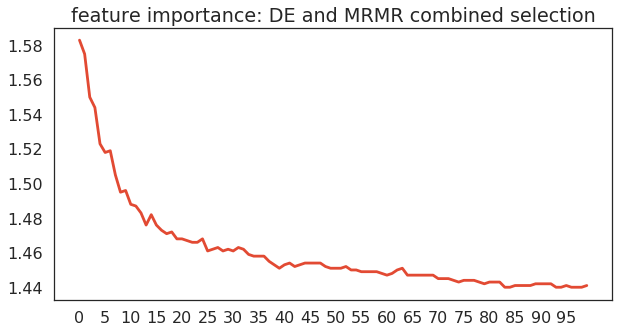

In [186]:
mrmrbinAtable = get_featurename_mrmr(binfeaturenamesplit[indfrommrmr[1][1]],coeffrommrmr[1][1])

,0,1,2,3,4
0,lncRNA_ENSG00000213963.6: 1.584,tRNA_30985: 1.58,srpRNA_ENSG00000264423.2: 1.555,lncRNA_ENSG00000233061.1: 1.551,tRNA_26447: 1.553
1,srpRNA_ENSG00000264530.2: 1.554,srpRNA_ENSG00000264250.2: 1.543,srpRNA_ENSG00000263558.2: 1.538,lncRNA_ENSG00000230606.10: 1.534,lncRNA_ENSG00000234264.1: 1.535
2,tRNA_26876: 1.532,lncRNA_ENSG00000228150.1: 1.53,tRNA_36059: 1.527,tRNA_28530: 1.529,lncRNA_ENSG00000230768.7: 1.528
3,srpRNA_ENSG00000264438.2: 1.525,lncRNA_ENSG00000236948.2: 1.523,lncRNA_ENSG00000236209.1: 1.525,tRNA_21360: 1.522,tRNA_17594: 1.521
4,lncRNA_ENSG00000226476.3: 1.52,tRNA_28620: 1.522,lncRNA_ENSG00000279179.1: 1.519,lncRNA_ENSG00000229956.10: 1.516,srpRNA_ENSG00000263608.2: 1.516
5,lncRNA_ENSG00000267520.2: 1.516,srpRNA_ENSG00000243591.3: 1.515,lncRNA_ENSG00000235123.5: 1.516,lncRNA_ENSG00000283635.1: 1.515,miRNA_ENSG00000264406.1: 1.513
6,lncRNA_ENSG00000278966.2: 1.511,lncRNA_ENSG00000279348.1: 1.512,miRNA_ENSG00000265435.1: 1.513,srpRNA_ENSG00000263669.2: 1.512,tRNA_19842: 1.511
7,lncRNA_ENSG00000116883.8: 1.512,lncRNA_ENSG00000279443.1: 1.512,miRNA_ENSG00000207590.1: 1.512,lncRNA_ENSG00000196096.3: 1.512,tRNA_31861: 1.512
8,miRNA_ENSG00000221754.1: 1.51,lncRNA_ENSG00000230606.10: 1.509,tRNA_20656: 1.509,lncRNA_ENSG00000225963.7: 1.51,lncRNA_ENSG00000233922.2: 1.508
9,lncRNA_ENSG00000203620.2: 1.509,lncRNA_ENSG00000237126.8: 1.51,lncRNA_ENSG00000239415.1: 1.509,lncRNA_ENSG00000206552.4: 1.507,srpRNA_ENSG00000277483.1: 1.507


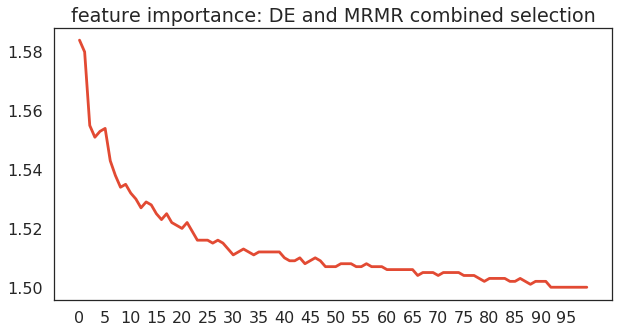

In [187]:
mrmrmixhcctable = get_featurename_mrmr(mixfeaturenamesplit[indfrommrmr[2][0]],coeffrommrmr[2][0])

,0,1,2,3,4
0,lncRNA_ENSG00000280156.1: 1.583,lncRNA_ENSG00000281344.1: 1.575,miRNA_ENSG00000266531.1: 1.558,srpRNA_ENSG00000242509.3: 1.544,lncRNA_ENSG00000280623.1: 1.532
1,miRNA_ENSG00000221410.1: 1.515,srpRNA_ENSG00000244642.3: 1.513,tRNA_35946: 1.515,srpRNA_ENSG00000239702.3: 1.505,lncRNA_ENSG00000279789.1: 1.499
2,miRNA_ENSG00000272458.1: 1.5,srpRNA_ENSG00000242863.3: 1.501,miRNA_ENSG00000266148.1: 1.496,lncRNA_ENSG00000259460.1: 1.49,miRNA_ENSG00000278223.1: 1.491
3,lncRNA_ENSG00000276216.1: 1.489,lncRNA_ENSG00000280156.1: 1.493,lncRNA_ENSG00000234715.1: 1.488,tRNA_26644: 1.486,srpRNA_ENSG00000243366.3: 1.488
4,lncRNA_ENSG00000283265.1: 1.491,miRNA_ENSG00000264314.1: 1.485,lncRNA_ENSG00000237513.1: 1.486,tRNA_25611: 1.484,lncRNA_ENSG00000273284.1: 1.484
5,lncRNA_ENSG00000281344.1: 1.485,lncRNA_ENSG00000220891.1: 1.481,lncRNA_ENSG00000240990.9: 1.48,lncRNA_ENSG00000280156.1: 1.482,tRNA_36393: 1.477
6,lncRNA_ENSG00000260751.2: 1.478,srpRNA_ENSG00000239744.3: 1.48,tRNA_28527: 1.476,miRNA_ENSG00000221745.3: 1.476,lncRNA_ENSG00000280136.2: 1.477
7,lncRNA_ENSG00000226476.3: 1.479,lncRNA_ENSG00000279440.1: 1.478,srpRNA_ENSG00000243738.3: 1.472,miRNA_ENSG00000277784.1: 1.473,miRNA_ENSG00000277904.1: 1.472
8,lncRNA_ENSG00000231876.7: 1.474,lncRNA_ENSG00000234741.7: 1.474,lncRNA_ENSG00000228005.1: 1.47,lncRNA_ENSG00000280156.1: 1.47,tRNA_25599: 1.471
9,lncRNA_ENSG00000275512.1: 1.471,lncRNA_ENSG00000234913.1: 1.473,lncRNA_ENSG00000260121.1: 1.471,srpRNA_ENSG00000242894.3: 1.472,tRNA_19842: 1.472


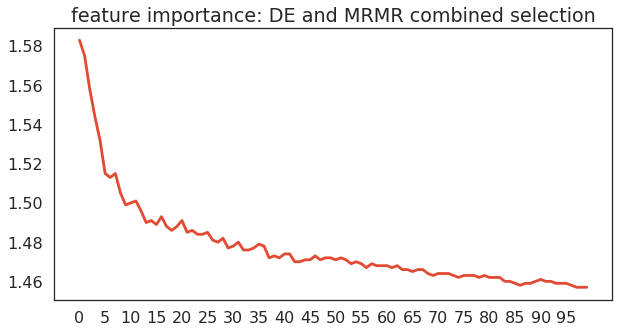

In [188]:
mrmrmixAtable = get_featurename_mrmr(mixfeaturenamesplit[indfrommrmr[2][1]],coeffrommrmr[2][1])

In [105]:
dataset[datatype[0]][dataclass[1]][:,namefromde[0][1][indfrommrmr[0][1]]]

NameError: name 'namefromde' is not defined

##### 画logistic不同正则化参数的曲线和hist  smaller values specify stronger regularization.

In [55]:
penaltycoefresult = {}
penaltycoef = np.array([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5])
for i in range(penaltycoef.shape[0]):
    tmpcoef = logistic_selection(dataset['full']['A'],labelset['full']['A'],penalty=penaltycoef[i])
    penaltycoefresult[i] = tmpcoef[np.where(tmpcoef!=0)]
countlogshape = np.zeros([penaltycoef.shape[0]])
for i in range(penaltycoef.shape[0]):
    countlogshape[i] = penaltycoefresult[i].shape[0]

[Text(0,0,'0.2'),
 Text(0,0,'0.3'),
 Text(0,0,'0.4'),
 Text(0,0,'0.5'),
 Text(0,0,'0.6'),
 Text(0,0,'0.7'),
 Text(0,0,'0.8'),
 Text(0,0,'0.9'),
 Text(0,0,'1.0'),
 Text(0,0,'2.0'),
 Text(0,0,'3.0'),
 Text(0,0,'4.0'),
 Text(0,0,'5.0')]

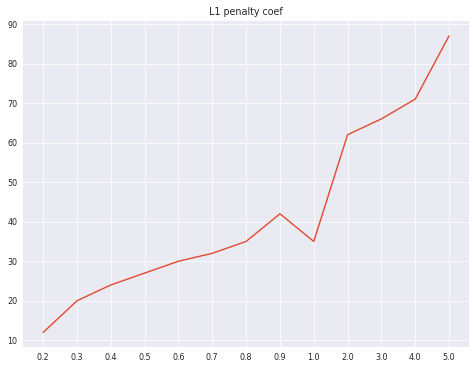

In [75]:
sns.set_context(contexts[0])
sns.set_style(styles[3])
fig,ax=plt.subplots(1,figsize=(8,6))
ax.plot(countlogshape)
ax.set_title('L1 penalty coef')
ax.set_xticks(range(penaltycoef.shape[0]))
ax.set_xticklabels(penaltycoef)

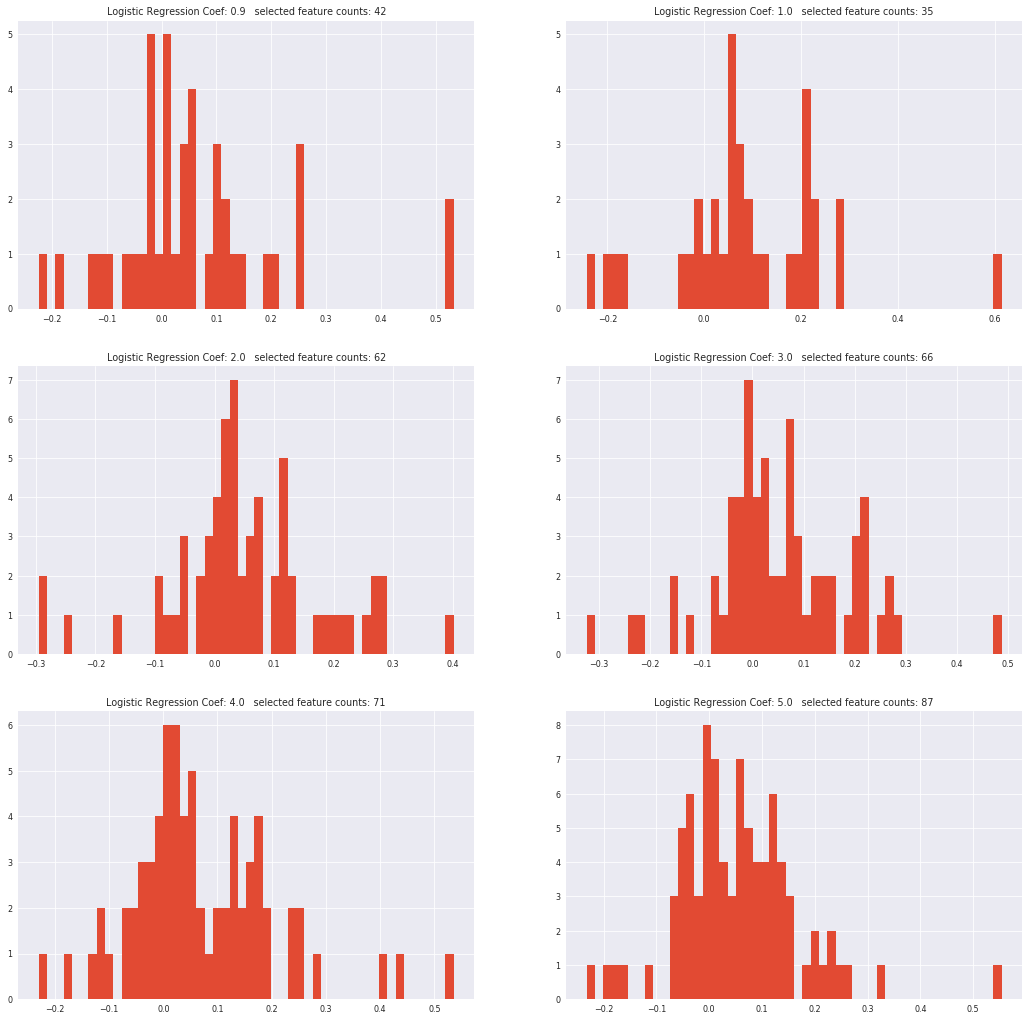

In [79]:
fig,ax=plt.subplots(3,2,figsize=(18,18))
for i in range(3):
    for j in range(2):
        ax[i,j].hist(penaltycoefresult[7+i*2+j],bins=50)
        ax[i,j].set_title('Logistic Regression Coef: '+str(penaltycoef[7+i*2+j])+'   selected feature counts: '+
                         str(penaltycoefresult[7+i*2+j].shape[0]))

### 验证特征选择的结果
- 做ROC
- PCA/tSNE

### 1，用logistic regression

Text(0.5,1,'Receiver operating characteristic example')

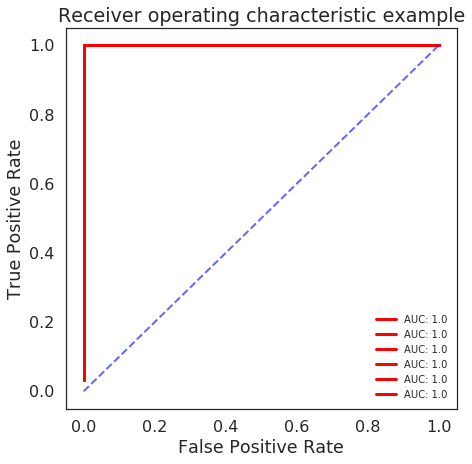

In [189]:
def logistic_roc(feature,label,penalty=2):
    logmodel = LogisticRegression(penalty='l1',C=penalty)
    y_score = logmodel.fit(feature,label).decision_function(feature)
    fpr, tpr, _ = roc_curve(label, y_score)
    roc_auc = auc(fpr, tpr)
    return roc_auc,fpr, tpr,logmodel.predict(feature)
roc,fpr,tpr,predict = {},{},{},{}
for i in range(3):
    for j in range(2):
        roc[i*2+j],fpr[i*2+j],tpr[i*2+j],predict[i*2+j]= \
        logistic_roc(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]],penalty=2)
fig,ax=plt.subplots(1,figsize=(7,7))
for i in range(3):
    for j in range(2):
        ax.plot(fpr[i*2+j],tpr[i*2+j],linewidth=3,color='r',label='AUC: '+str(roc[i*2+j]))
ax.legend(prop={'size': 10})
ax.plot([0,1],[0,1], linewidth=2,alpha=0.6,color='b',linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')

## logistic regression

#### PCA and tSNE

In [500]:
def get_selected_feature(feature,label,method='log'):
    '''
    dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]]
    '''
    if method=='log':
        tmpfeaturecoef = logistic_selection(feature,label,penalty=2)
        tmpind = np.where(tmpfeaturecoef!=0)[0]
        return feature[:,tmpind],tmpind
    elif method=='tree':
        tmpfeaturecoef =get_feature_ind_tree(feature,label)
        tmpind = np.where(tmpfeaturecoef!=0)[0]
        return feature[:,tmpind]
    elif method=='mrmr':
        skip

In [108]:
get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]]).shape

(43, 69)

In [419]:
from collections import OrderedDict

In [469]:
from sklearn.decomposition import PCA
def plot_PCA(data_whole,labels,title,dataclass='stage'):
    pca = PCA(n_components=2)
    pca.fit(data_whole+0.00001)
    x_2d = pca.transform(data_whole+0.00001)
    plt.figure(figsize=(10,8))
    #ratio = pca.explained_variance_ratio_[:2]
    if dataclass=='stage':
        labs = ['stageA','Normal']
        for i, c, label in zip(np.arange(0,len(labs)), tableau20[:len(labs)], labs):
            plt.scatter(x_2d[labels == i, 0], x_2d[labels == i, 1], c=c, label=label,s=70)
            plt.legend(bbox_to_anchor=(1.3,0.55),fontsize=20)
            plt.title(title)
    elif dataclass=='hcc':
        labs = ['HCC','Normal']
    elif dataclass =='allstage':
        labs = np.array(['Normal','Stage A','Stage B','Stage C'])
        fig,ax=plt.subplots(1,3,figsize = (3*6,6))
        by_label = {}
        for j in range(3):
            for i, c, label in zip(np.array([0,j+1]), tableau20[np.array([0,3,2,6])][np.array([0,j+1])], labs[np.array([0,j+1])]):
                ax[j].scatter(x_2d[labels == i, 0], x_2d[labels == i, 1], c=c, label=label,s=70,alpha=1, edgecolors=tableau20[10:][j])
                ax[j].legend(loc="upper right",fontsize=10)
                #ax[j].set_title(title)
            #handles, labes = plt.gca().get_legend_handles_labels()
            #by_label[j] = OrderedDict(zip(labes, handles))

        #fig.legend(by_label[0].values(), by_label.keys(),bbox_to_anchor=(0.8,0.55),fontsize=10)    
        #plt.show()
        return by_label
    return x_2d

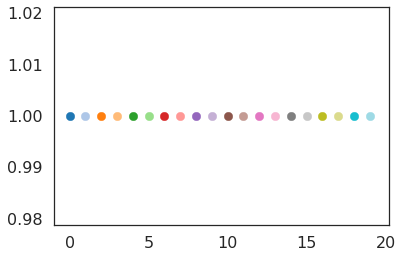

In [457]:
for i, c, label in zip(range(20), tableau20,range(20)):
    plt.scatter(i,1,c=c,label=label,s=70)

In [ ]:
plot_PCA(get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]]),
         sampleclass,'PCA: selected feature of: data '+datatype[i]+' '+dataclass[j],'allstage')


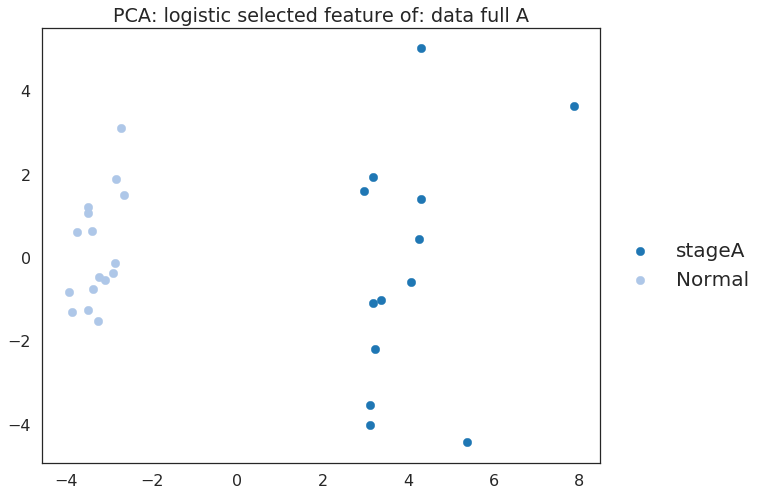

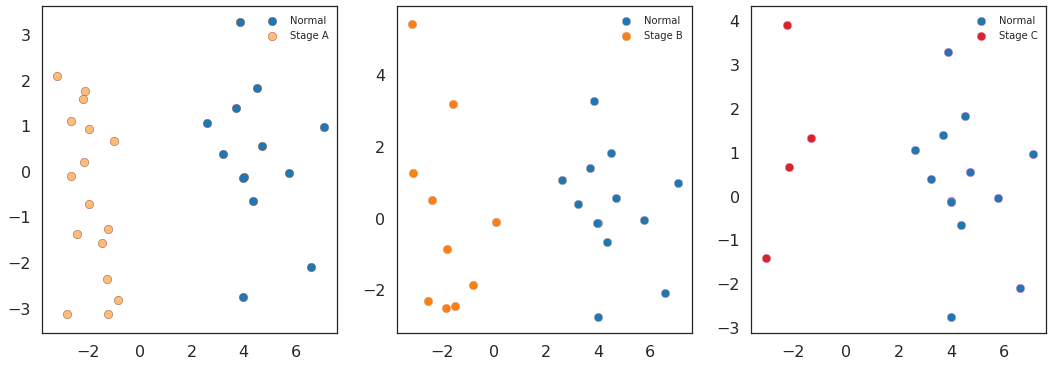

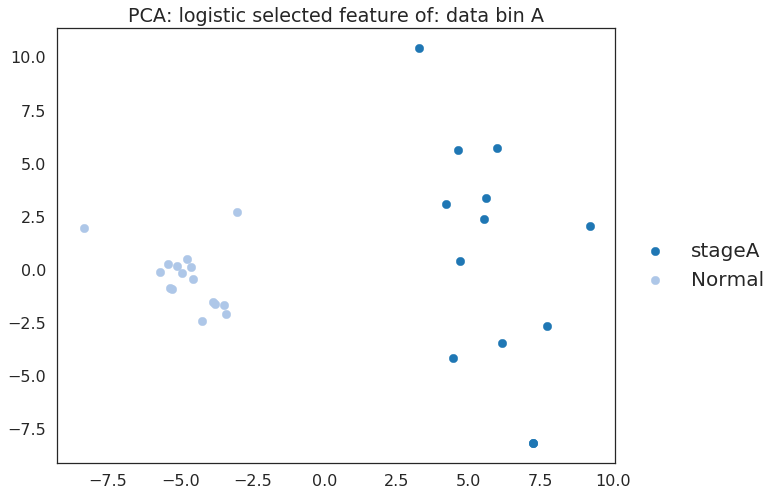

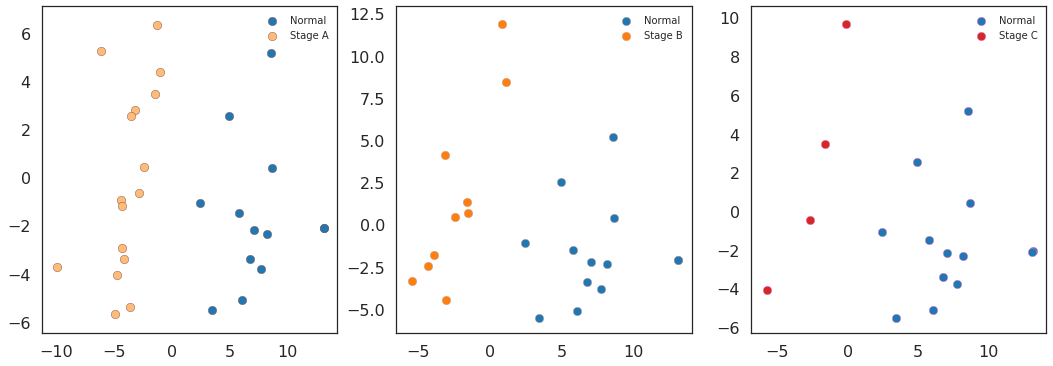

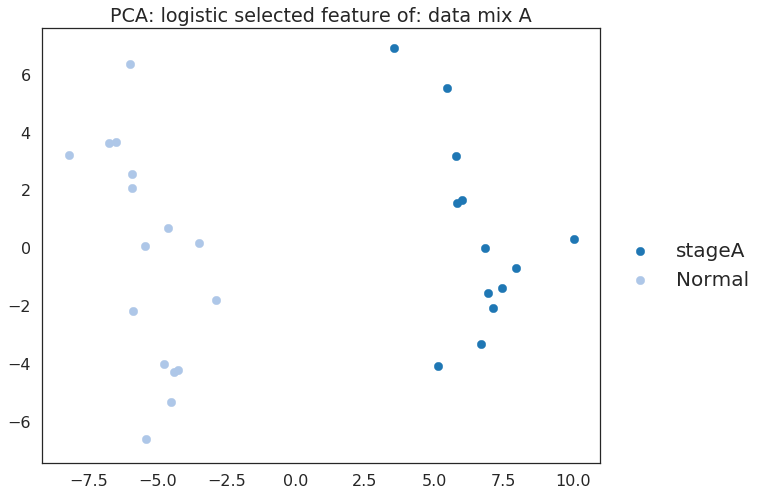

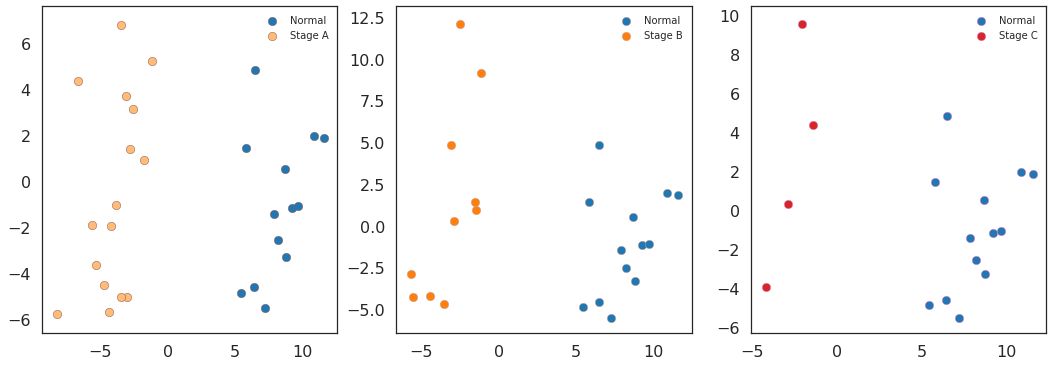

In [470]:
for i in range(3):
    for j in range(2):
        if not j%2:
            m='stage'
            n = labelset[datatype[i]][dataclass[j]]
        else:
            
            m='allstage'
            n = sampleclass
        by_label = plot_PCA(get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]]),
        n ,'PCA: logistic selected feature of: data '+datatype[i]+' '+dataclass[j],m)

In [466]:
get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]]).shape

(43, 88)

In [467]:
sampleclass

array([1, 1, 3, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 3, 2, 1, 2, 3,
       1, 2, 1, 1, 2, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [533]:
samplecolumns = np.ndarray([43,1]).astype('str')
samplecolumns[np.where(sampleclass ==0)] = 'HD'
samplecolumns[np.where(sampleclass ==1)] = 'A'
samplecolumns[np.where(sampleclass ==2)] = 'B'
samplecolumns[np.where(sampleclass ==3)] = 'C'

In [492]:
i = 2
j=1
get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]]).shape

(43, 81)

In [488]:
samplecolumns.ravel()

array(['Stage A', 'Stage A', 'Stage C', 'Stage A', 'Stage B', 'Stage B',
       'Stage B', 'Stage A', 'Stage A', 'Stage B', 'Stage A', 'Stage B',
       'Stage A', 'Stage A', 'Stage B', 'Stage A', 'Stage A', 'Stage C',
       'Stage B', 'Stage A', 'Stage B', 'Stage C', 'Stage A', 'Stage B',
       'Stage A', 'Stage A', 'Stage B', 'Stage C', 'Stage A', 'Stage A',
       'HD', 'HD', 'HD', 'HD', 'HD', 'HD', 'HD', 'HD', 'HD', 'HD', 'HD',
       'HD', 'HD'], dtype='<U32')

In [510]:
get_selected_feature(dataset[datatype[2]][dataclass[1]],labelset[datatype[2]][dataclass[1]])[0].shape

(43, 76)

In [506]:
get_selected_feature(dataset[datatype[2]][dataclass[0]],labelset[datatype[2]][dataclass[0]])[1]

array([  190,   406,   597,   950,  1325,  1619,  1925,  2125,  2407,
        2515,  2617,  3520,  3547,  3568,  3964,  4140,  4412,  4671,
        5084,  5642,  5673,  6440,  6644,  6840,  8026,  8100,  8335,
        8667,  9120,  9429, 10084, 14028, 16464, 16465, 16466, 16467,
       20047, 21135, 21244, 21247, 21248, 21403, 21855, 21856, 21857,
       21858, 21859, 23003, 25674, 25675, 25676, 26288, 26289, 26290,
       29261, 33434, 36583, 38618, 38623, 39235, 40239, 40240, 40243,
       40247, 40249, 40250, 42526, 42530, 44856, 44857, 44918, 44919,
       46309, 47732, 47733, 47734, 50486, 55675])

In [508]:
sns.clustermap(pd.DataFrame(np.concatenate((get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]])[0],
                            dataset[datatype[2]][dataclass[1]][:,get_selected_feature(dataset[datatype[2]][dataclass[0]],
                                                          labelset[datatype[2]][dataclass[0]])[1]]),axis=1).T,columns=samplecolumns.ravel()),
              center=0,cmap="vlag",linewidths=.75, figsize=(13, 13))

(43, 99)

In [538]:
sampleclass

array([1, 1, 3, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 3, 2, 1, 2, 3,
       1, 2, 1, 1, 2, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [521]:
get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]])[0][:,:50].T.shape

(50, 43)

In [541]:
get_selected_feature(dataset[datatype[1]][dataclass[1]],sampleclass)

IndexError: index 46780 is out of bounds for axis 1 with size 45746

In [634]:
def soft_max(feature,label,penalty=0.1):
    logmodel = LogisticRegression(penalty='l1',C=penalty,multi_class='multinomial',solver ='saga')
    logmodel.fit(feature,label)
    return logmodel.coef_
tttfeature = soft_max(dataset[datatype[2]][dataclass[1]],sampleclass)
importancettt = tttfeature[np.where(tttfeature !=0)].reshape(-1,1)
testsoft = np.concatenate((dataset[datatype[2]][dataclass[1]][:,np.where(tttfeature[0] !=0)[0]],
     dataset[datatype[2]][dataclass[1]][:,np.where(tttfeature[1] !=0)[0]],
      dataset[datatype[2]][dataclass[1]][:,np.where(tttfeature[2] !=0)[0]],
      dataset[datatype[2]][dataclass[1]][:,np.where(tttfeature[3] !=0)[0]]),axis=1)


In [655]:
pd.DataFrame(np.concatenate((testsoft.T,importancettt),axis=1),columns=np.concatenate((samplecolumns.ravel(),np.array(['importance']) ))).to_csv('forcluster.csv')

In [562]:
/home/chenxupeng/projects/training/forcluster.csv

'/home/chenxupeng/projects/training'

In [657]:
pd.read_table('/home/chenxupeng/projects/training/forcluster.csv',sep=',')

,Unnamed: 0,A,A.1,C,A.2,B,B.1,B.2,A.3,A.4,...,HD.4,HD.5,HD.6,HD.7,HD.8,HD.9,HD.10,HD.11,HD.12,importance
0,0,-0.826845,1.484728,-0.914825,0.280719,0.152354,1.634993,-0.241918,1.431475,-0.793273,...,-0.006238,-1.138205,-1.138205,-1.138205,-0.580402,-0.508730,-0.248746,-1.138205,-1.138205,-0.000195
1,1,-0.635322,-0.188970,-0.660799,-0.637850,0.443984,1.456324,-0.070205,1.857073,-0.426154,...,-0.853559,-0.853559,-0.853559,-0.853559,-0.853559,-0.345075,-0.853559,-0.853559,-0.853559,-0.000393
2,2,-0.952742,-0.391658,1.063404,-0.815840,-0.567604,0.426535,1.324619,2.030802,-0.225656,...,-1.011879,-1.011879,-1.011879,-1.011879,-1.011879,-1.011879,-0.358902,-1.011879,-1.011879,-0.004077
3,3,0.078486,0.305597,0.773008,-1.595444,0.146864,1.402746,0.898105,0.284779,1.341386,...,-0.773339,-1.003260,-1.595444,0.186006,-0.931010,0.777758,0.076323,-1.595444,-1.595444,-0.000264
4,4,-0.415388,0.092073,-0.322123,-1.059398,-0.032302,-1.059398,0.434431,-1.059398,0.673334,...,1.099885,-1.059398,-1.059398,-1.059398,-0.233063,-1.059398,-1.059398,-1.059398,-1.059398,-0.000743
5,5,-0.310498,-0.265945,-1.157791,1.438924,0.890154,-0.288760,0.393553,-0.103214,0.814512,...,-0.960150,-1.205023,1.045928,-0.396376,-1.276104,-1.236664,-1.093599,-1.583055,-0.407971,-0.002203
6,6,-0.528461,-0.850654,-0.655406,0.332128,-0.764500,-0.704534,2.256091,2.361885,0.869740,...,-0.759066,-1.257045,-1.257045,-0.564672,-0.854573,-1.257045,-0.615273,-1.257045,-0.675728,-0.004902
7,7,0.104921,-0.201394,-0.101191,0.950835,0.005629,0.203503,0.100225,-1.435589,0.514104,...,-1.435589,-1.435589,-1.435589,-0.490091,-1.435589,0.680919,-0.559191,-1.435589,-1.435589,-0.000272
8,8,0.042128,-0.027917,-1.228034,1.395505,1.658801,0.249025,-0.456912,-0.734611,1.347849,...,-0.415151,-1.364016,0.625491,-1.364016,-1.364016,-1.364016,-1.364016,-1.364016,-1.364016,-0.000393
9,9,-0.959715,-0.822234,-1.050939,1.219058,0.609883,-0.430759,0.035642,-0.000988,0.802773,...,-1.143737,-1.382113,1.585256,-0.989726,-0.999827,-0.940381,-0.528479,-1.538270,-0.800148,-0.000469


In [664]:
sampleclass

array([1, 1, 3, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 3, 2, 1, 2, 3,
       1, 2, 1, 1, 2, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

(array([0.14059771, 0.3801621 , 0.61972649, 0.85929088]),
 <a list of 4 Text yticklabel objects>)

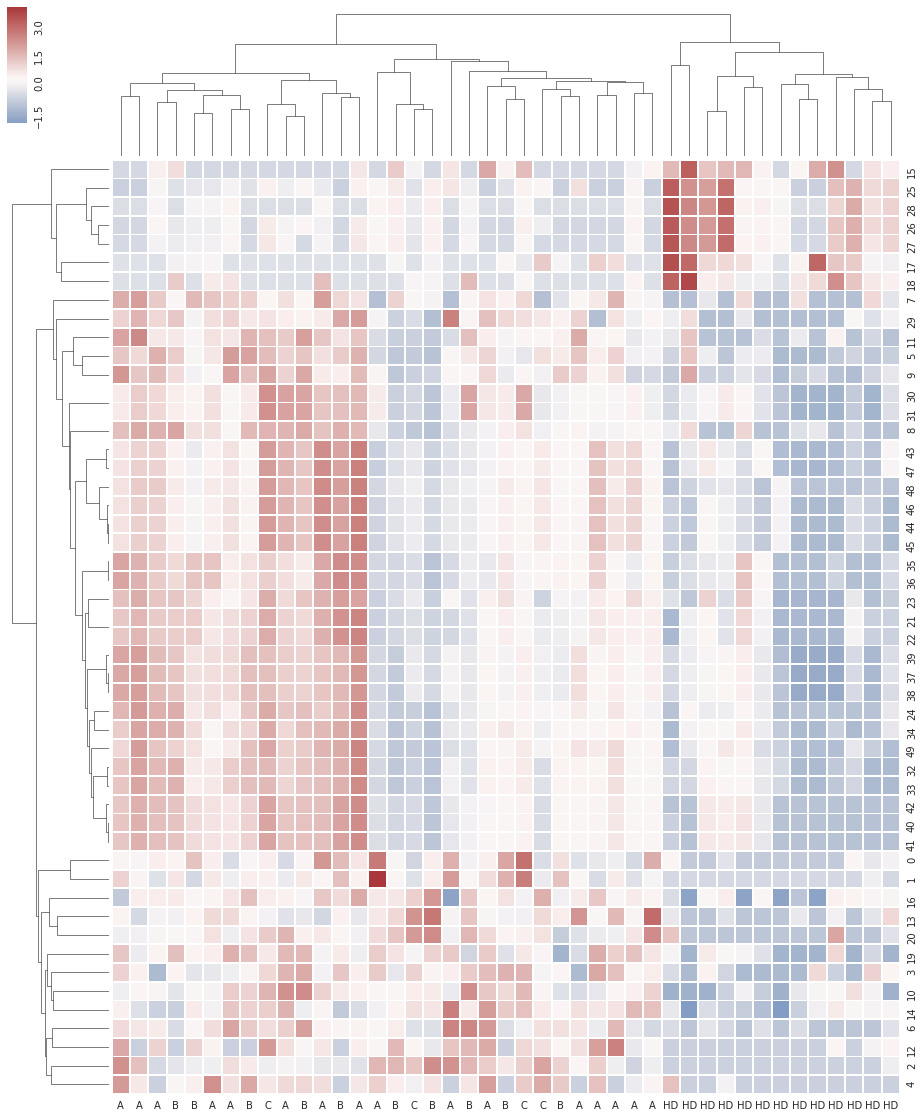

In [663]:
sns.set(font_scale=1)
cg = sns.clustermap(pd.DataFrame(testsoft.T[:50,:],
                            columns=samplecolumns.ravel()),
              center=0,cmap="vlag",linewidths=.75, figsize=(16,20)
             )
plt.xticks(rotation=0) 
plt.yticks(rotation='vertical')

In [148]:
from sklearn.manifold import TSNE
def plot_tsne(data_whole,labels,title,dataclass='stage'):
    tsne = TSNE(n_components=2, random_state=0)
    x_2d = tsne.fit_transform(data_whole)
    plt.figure(figsize=(10,8))
    if dataclass=='stage':
        labs = ['stageA','Normal']
    elif dataclass=='hcc':
        labs = ['HCC','Normal']
    elif dataclass =='allstage':
        labs = ['Normal','stageA','stageB','stageC']
    for i, c, label in zip(np.arange(0,len(labs)), tableau20[:len(labs)], labs):
        plt.scatter(x_2d[labels == i, 0], x_2d[labels == i, 1], c=c, label=label,s=70)
    plt.legend(bbox_to_anchor=(1.3,0.55),fontsize=20)
    plt.title(title)
    plt.show()

In [1]:
labelset[datatype[i]][dataclass[j]]

NameError: name 'labelset' is not defined

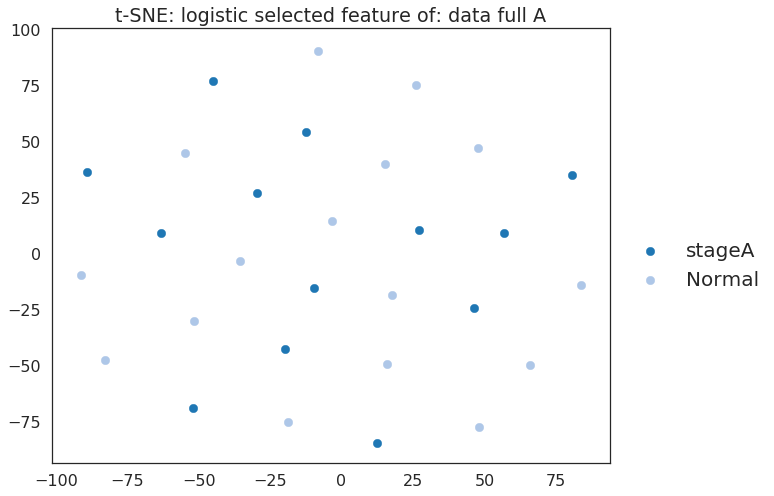

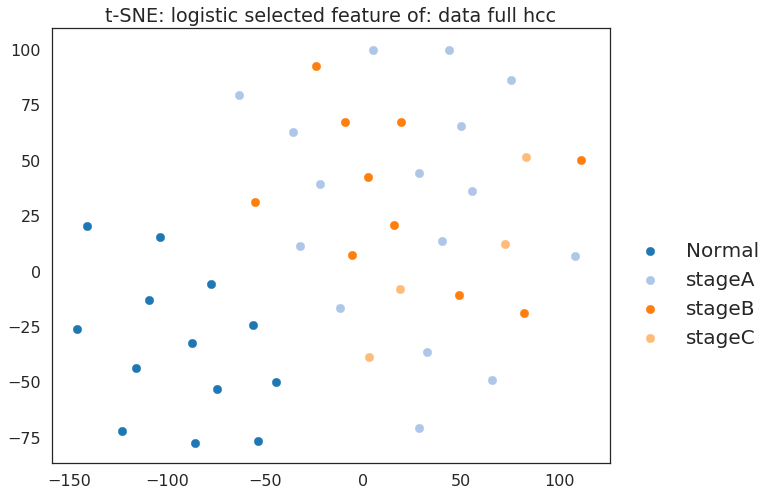

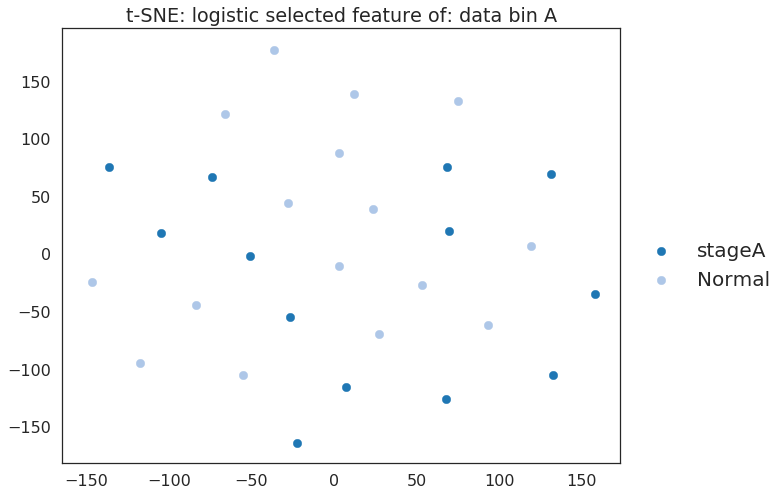

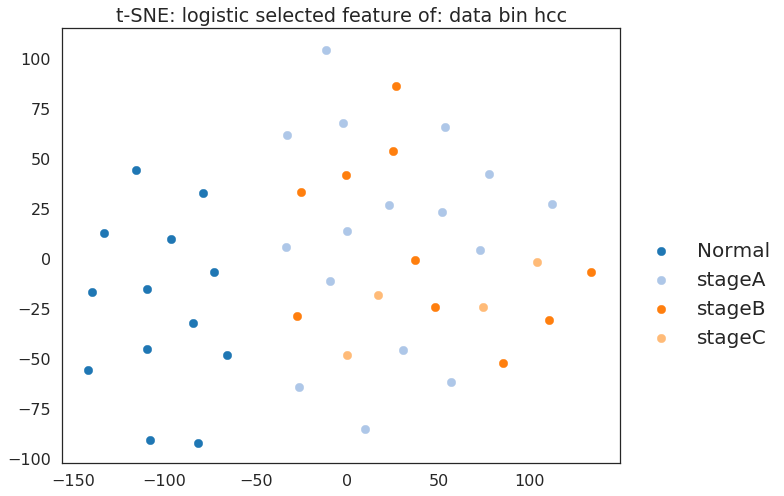

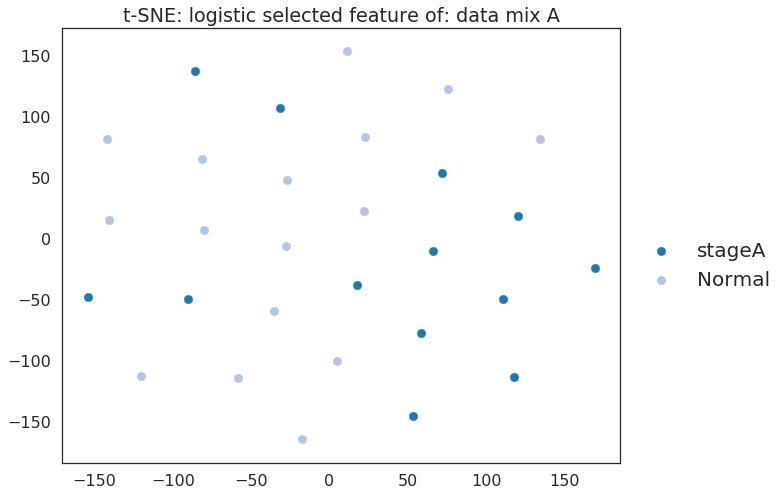

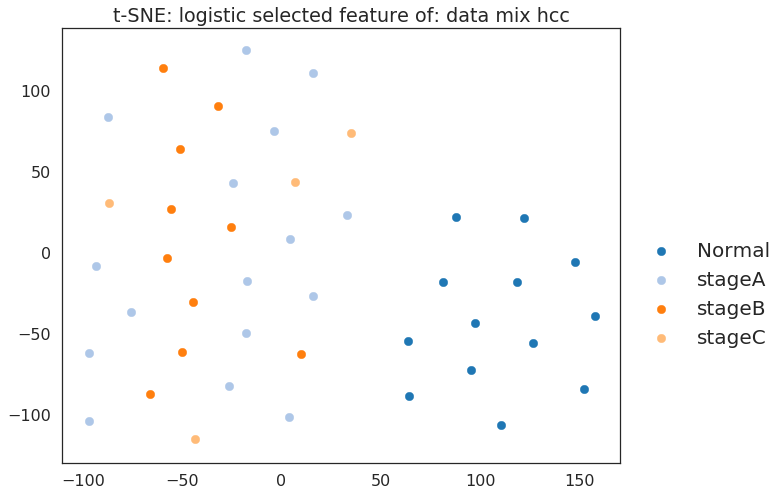

In [192]:
for i in range(3):
    for j in range(2):
        if not j%2:
            m='stage'
            n = labelset[datatype[i]][dataclass[j]]
        else:
            m='allstage'
            n = sampleclass
        plot_tsne(get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]]),
         n,'t-SNE: logistic selected feature of: data '+datatype[i]+' '+dataclass[j],m)


### 2，用tree based

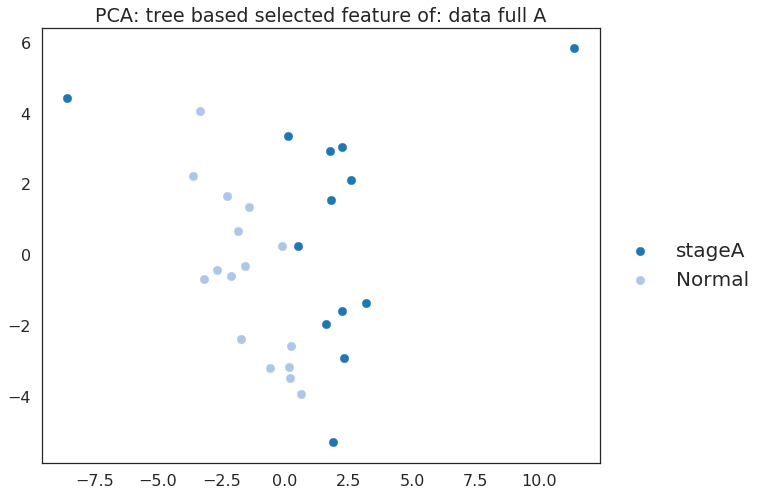

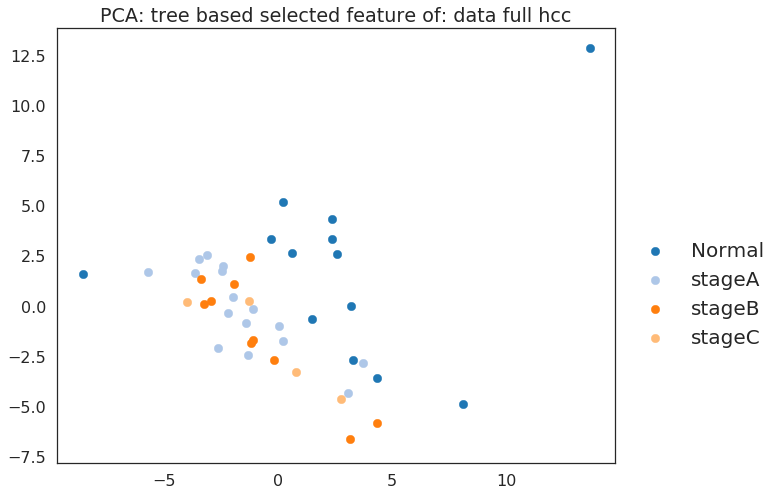

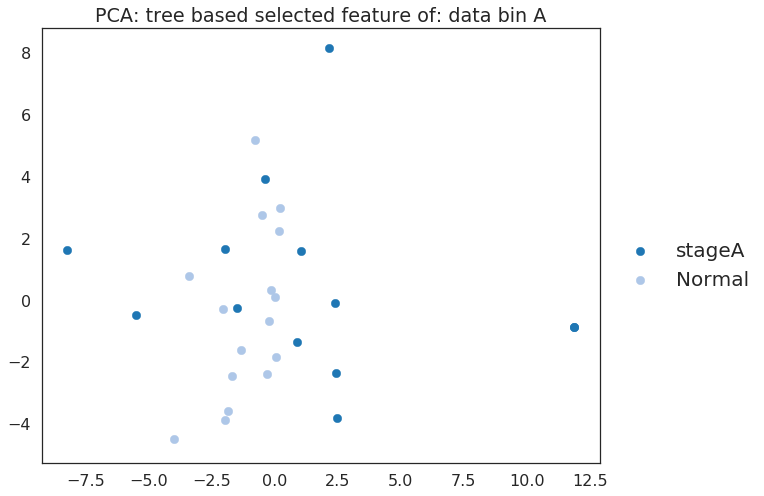

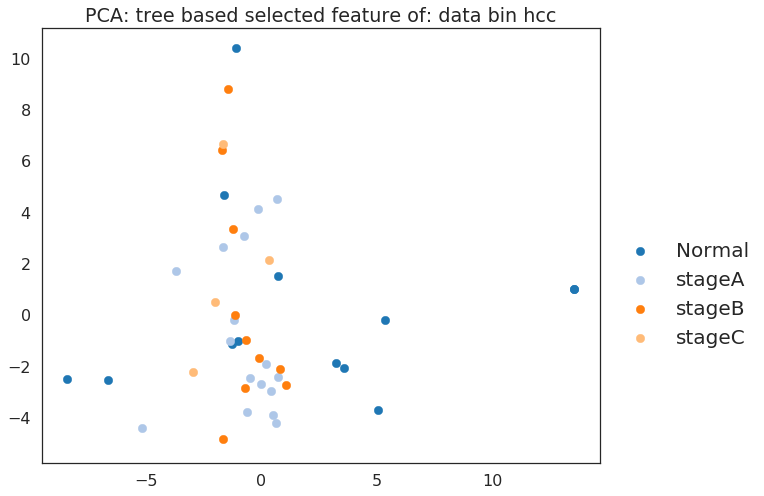

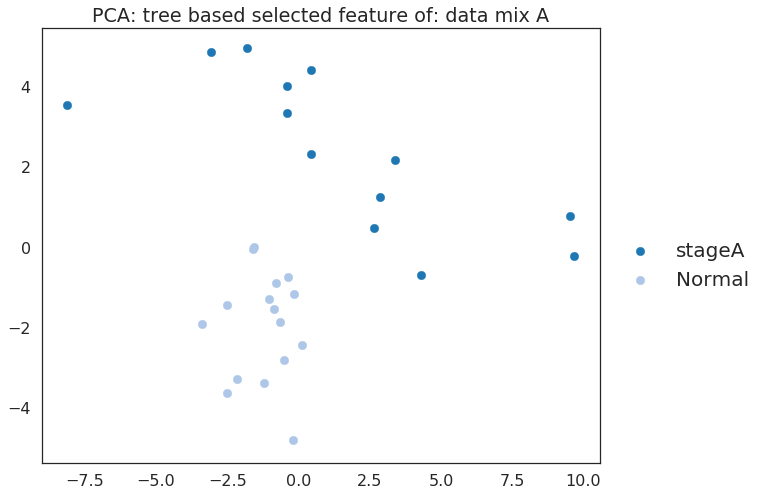

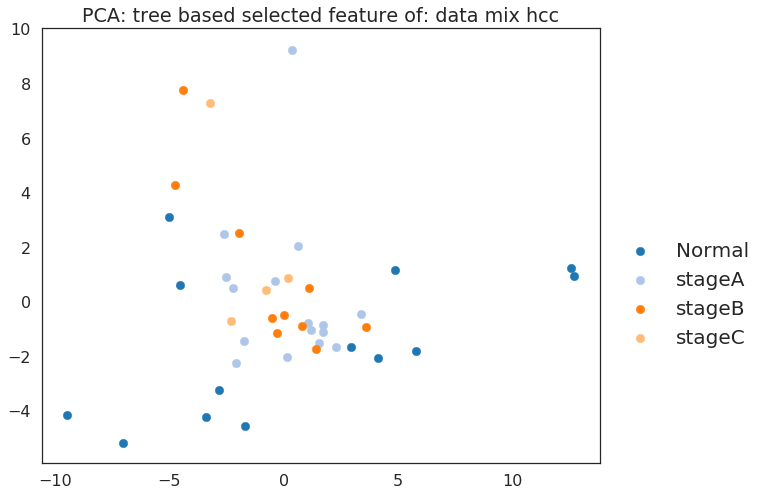

In [247]:
for i in range(3):
    for j in range(2):
        if not j%2:
            m='stage'
            n = labelset[datatype[i]][dataclass[j]]
        else:
            m='allstage'
            n = sampleclass
        plot_PCA(get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]],'tree'),
         n,'PCA: tree based selected feature of: data '+datatype[i]+' '+dataclass[j],m)

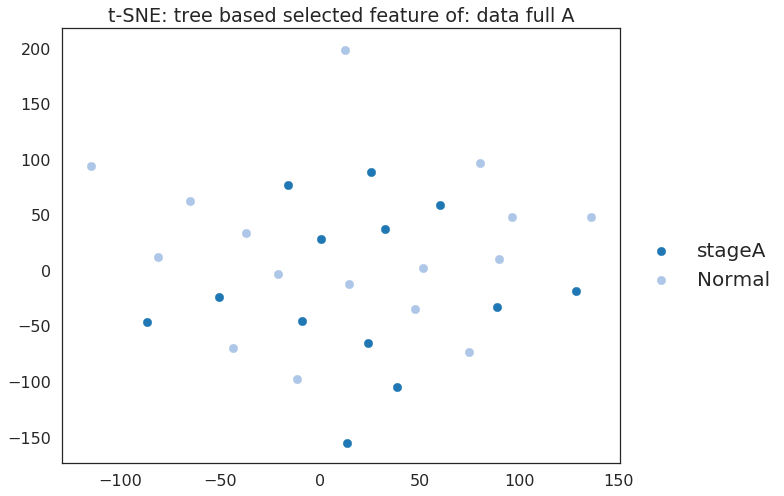

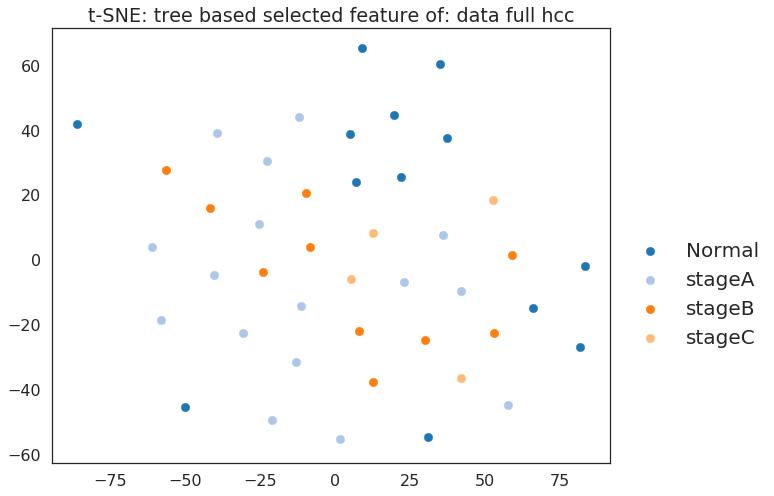

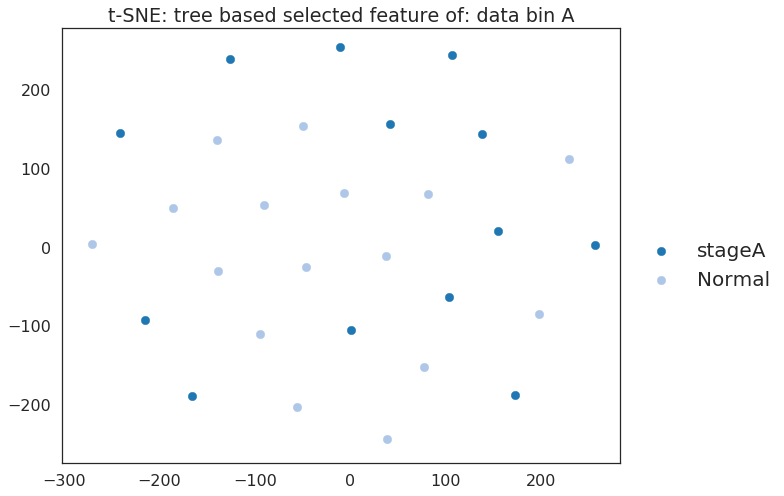

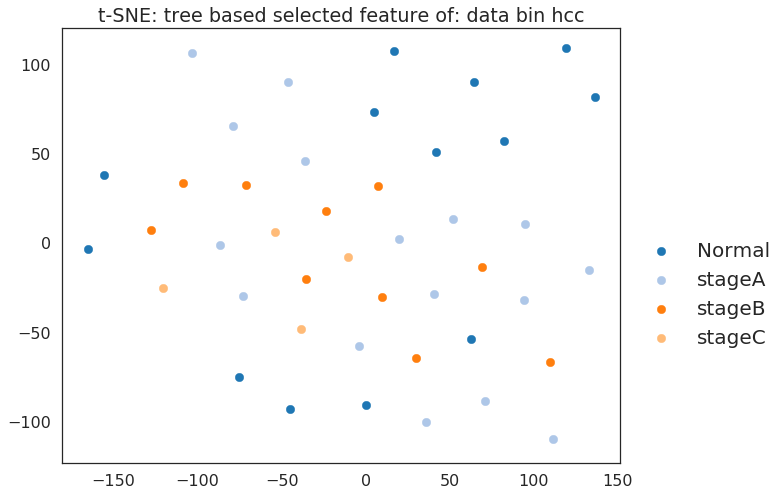

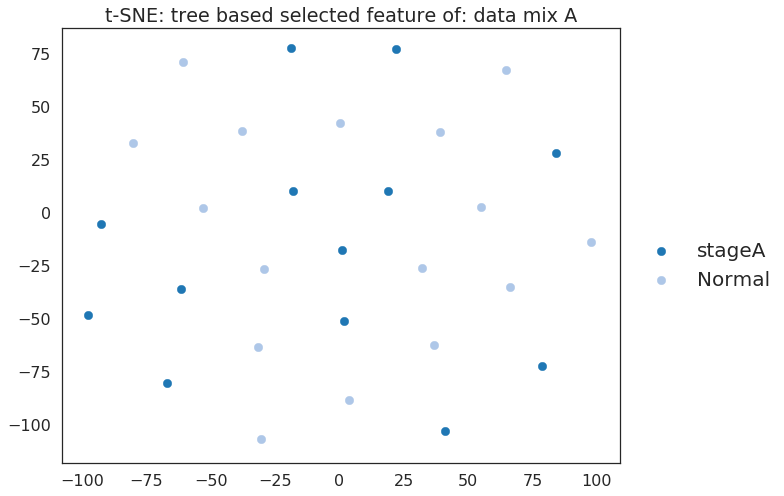

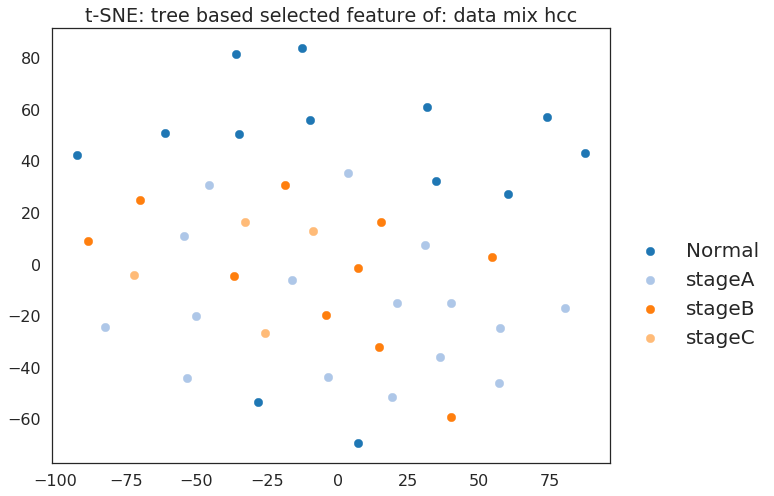

In [248]:
for i in range(3):
    for j in range(2):
        if not j%2:
            m='stage'
            n = labelset[datatype[i]][dataclass[j]]
        else:
            m='allstage'
            n = sampleclass
        plot_tsne(get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]],'tree'),
         n,'t-SNE: tree based selected feature of: data '+datatype[i]+' '+dataclass[j],m)


In [361]:
get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]],'tree').shape

(43, 77)

Text(0.5,1,'Receiver operating characteristic example')

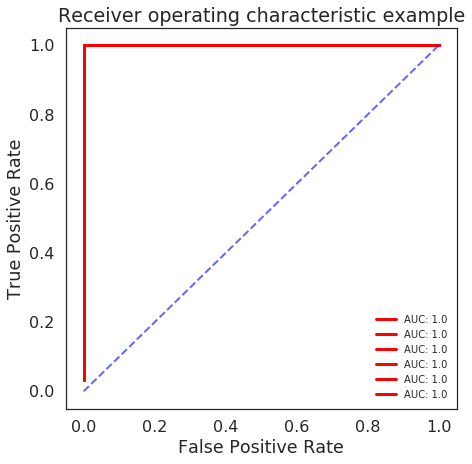

In [249]:
def tree_roc(feature,label,penalty=2):
    logmodel = LogisticRegression()
    y_score = logmodel.fit(feature,label).decision_function(feature)
    fpr, tpr, _ = roc_curve(label, y_score)
    roc_auc = auc(fpr, tpr)
    return roc_auc,fpr, tpr,logmodel.predict(feature)
roc,fpr,tpr,predict = {},{},{},{}
for i in range(3):
    for j in range(2):
        roc[i*2+j],fpr[i*2+j],tpr[i*2+j],predict[i*2+j]= \
        tree_roc(get_selected_feature(dataset[datatype[i]][dataclass[j]],labelset[datatype[i]][dataclass[j]],'tree'),labelset[datatype[i]][dataclass[j]])
fig,ax=plt.subplots(1,figsize=(7,7))
for i in range(3):
    for j in range(2):
        ax.plot(fpr[i*2+j],tpr[i*2+j],linewidth=3,color='r',label='AUC: '+str(roc[i*2+j]))
ax.legend(prop={'size': 10})
ax.plot([0,1],[0,1], linewidth=2,alpha=0.6,color='b',linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')

### MRMR

In [355]:
dataset[datatype[i]][dataclass[j]][:,indfrommrmr[i][j]].shape

(43, 100)

In [356]:
datatype

['full', 'bin', 'mix']

In [357]:
dataclass

['A', 'hcc']

In [384]:
indfrommrmr[i][j]

array([43815, 25830, 23831,  4517,  3808, 24338, 23815, 23741, 42532,
        4498,  3819,  4362,  3860,  3835,  4547, 24394, 26188,  4957,
       25593,  4303, 26680,  3838,  4426,  4503, 24207, 42031, 23770,
       45343, 44226, 11412,  4424,  5142, 10529, 23976,  4137,  4432,
        4410, 10565, 44054,  4229, 11146, 42569, 24461, 44188, 45447,
       26404,  5166, 45470,  5249, 24107, 24731, 26449, 44588, 10444,
       23757, 24789, 11044, 25061, 44562, 24296, 43683,  5031, 24153,
        5242,  5133,  4002, 24432, 42470,  4369,  5024, 45171, 25252,
       45040, 41993, 44195, 45313, 23791, 25105, 42544, 24000,  4112,
       42572, 24466,  5145, 26284,  4359, 11478, 26558, 25697, 26406,
       25084, 11115, 25280, 23712,  5164, 44756, 23968, 23563,  4684,
       11580])

In [386]:
tttmrmrind

1

In [ ]:
i=0
j=1
plot_PCA(dataset[datatype[i]][dataclass[j]][:,tttmrmrind[:50]-2],
        sampleclass,'PCA: MRMR selected feature of: data '+datatype[i]+' '+dataclass[j],'allstage')

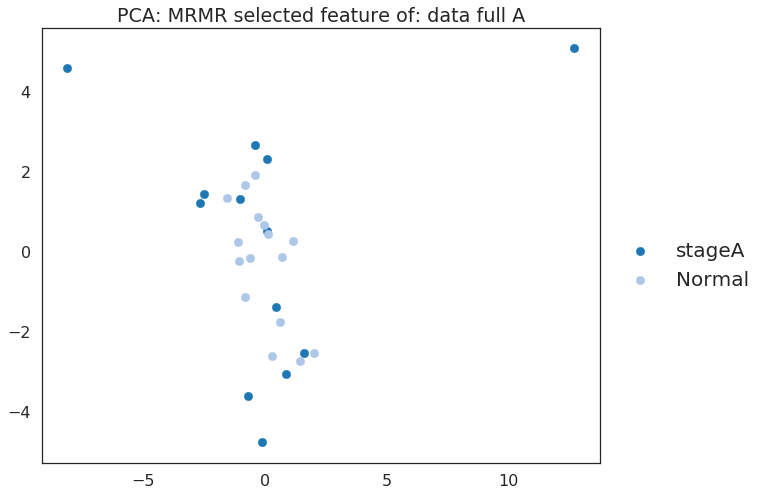

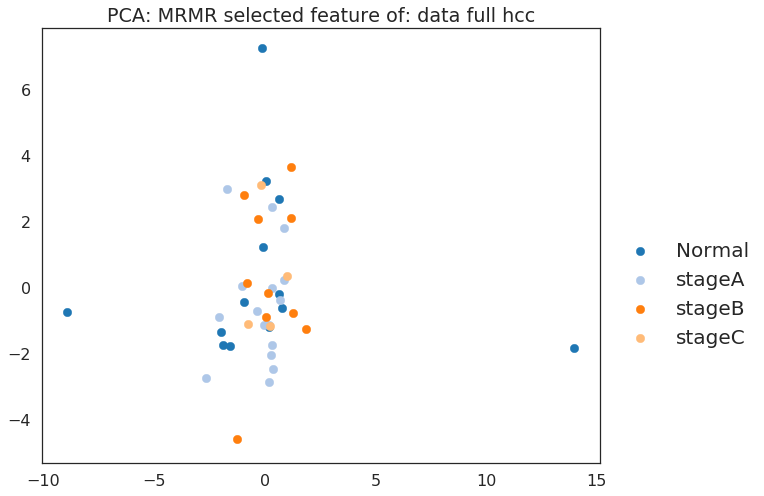

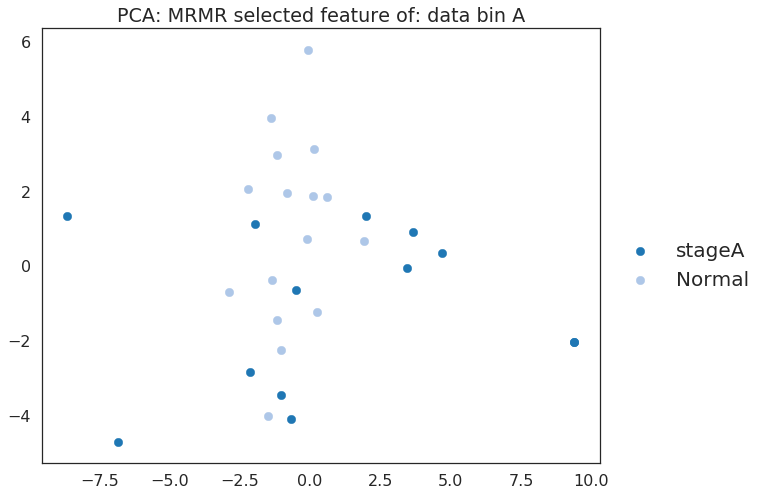

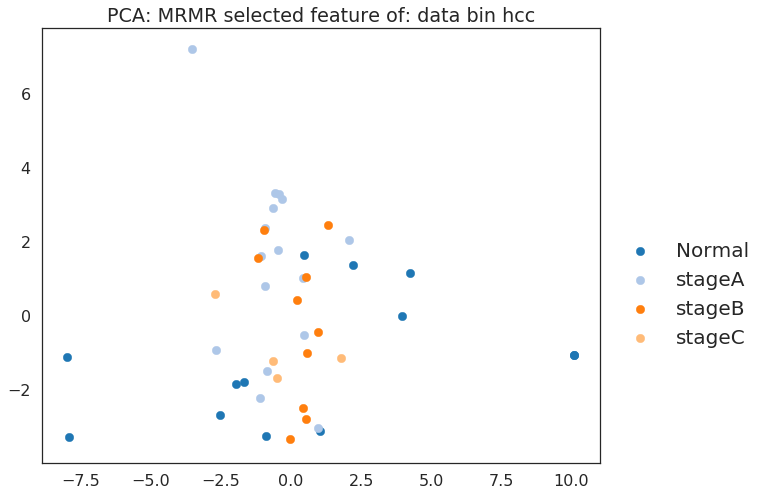

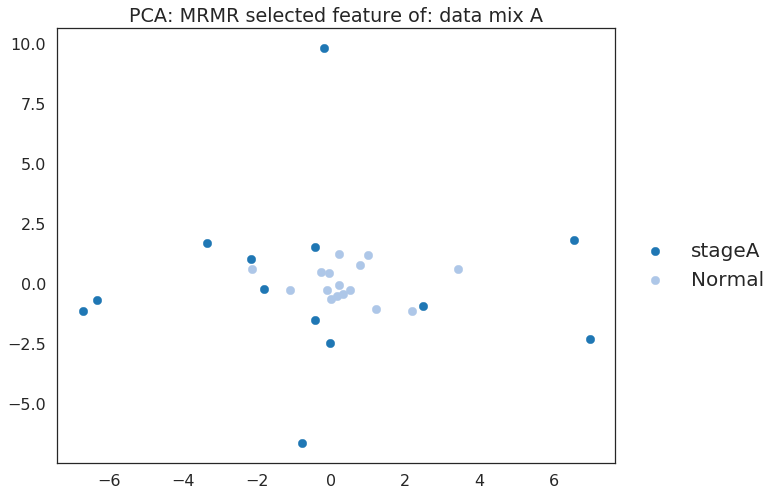

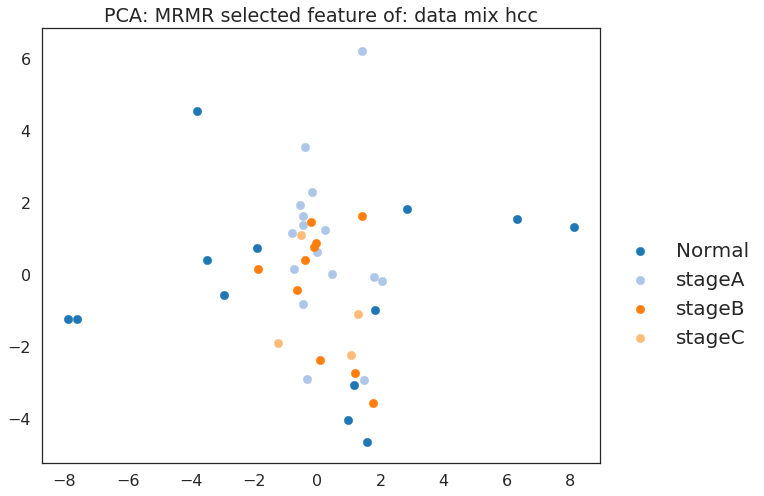

In [389]:
for i in range(3):
    for j in range(2):
        if not j%2:
            m='stage'
            n = labelset[datatype[i]][dataclass[j]]
        else:
            m='allstage'
            n = sampleclass
        plot_PCA(dataset[datatype[i]][dataclass[j]][:,indfrommrmr[i][j][:50]-2],
        n,'PCA: MRMR selected feature of: data '+datatype[i]+' '+dataclass[j],m)

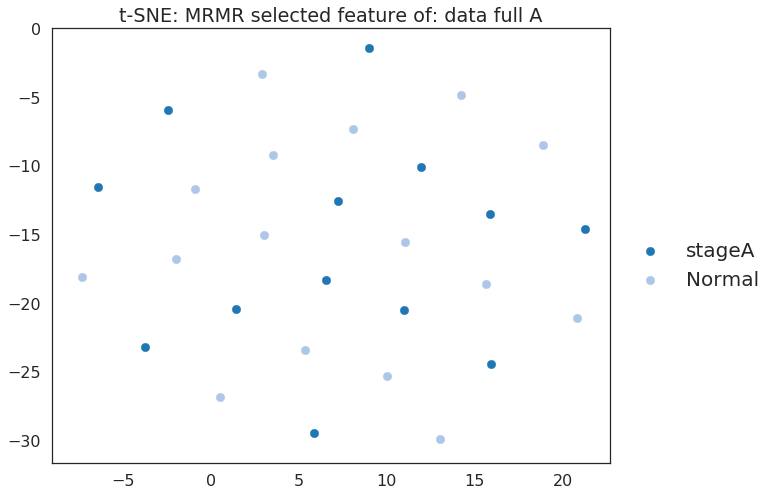

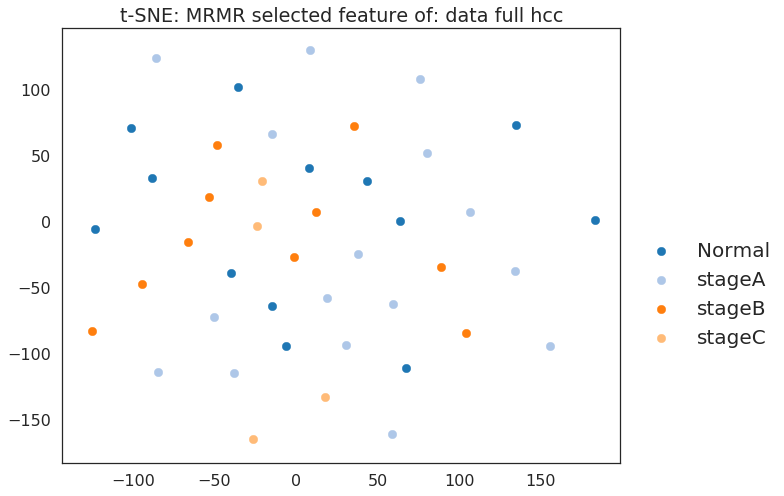

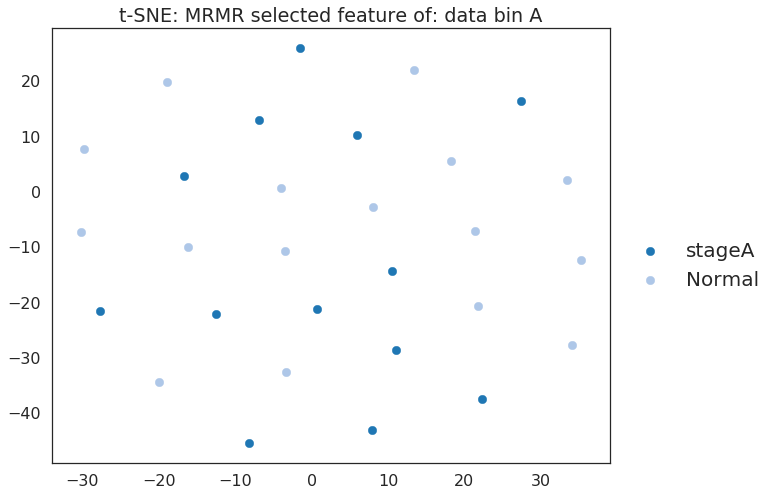

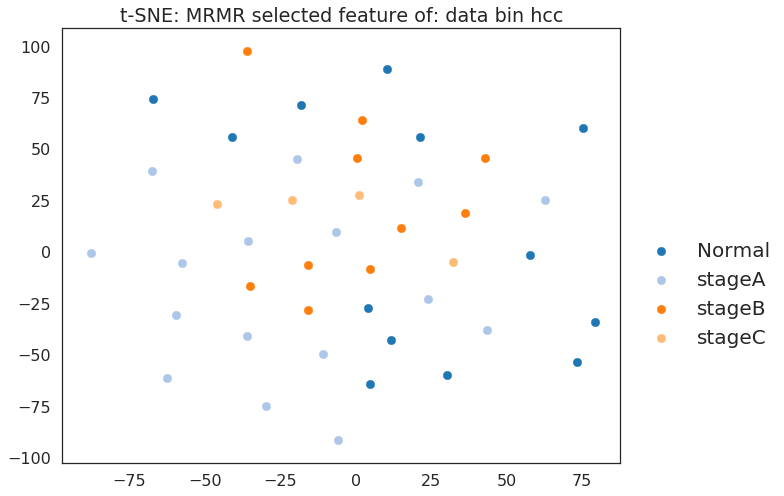

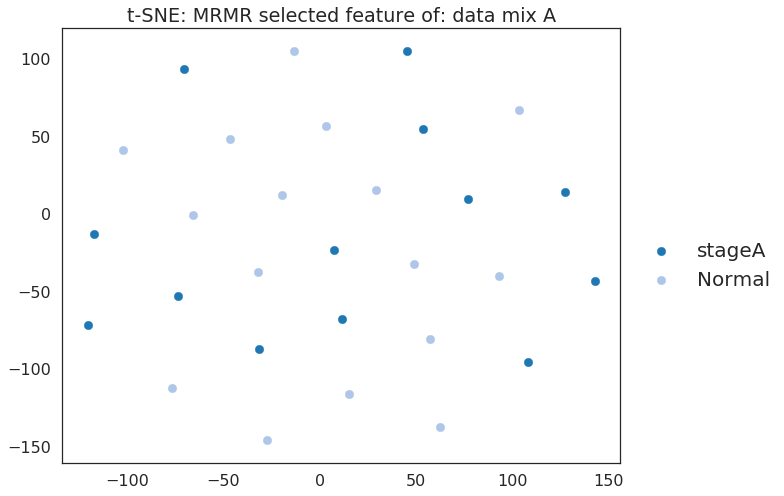

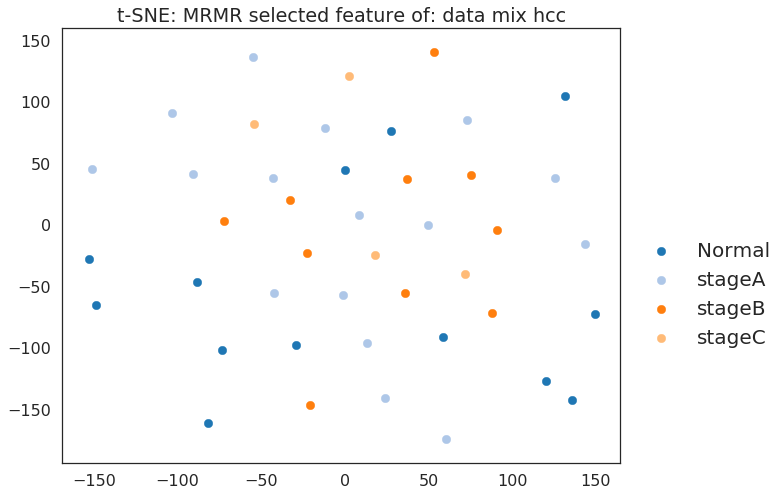

In [360]:
for i in range(3):
    for j in range(2):
        if not j%2:
            m='stage'
            n = labelset[datatype[i]][dataclass[j]]
        else:
            m='allstage'
            n = sampleclass
        plot_tsne(dataset[datatype[i]][dataclass[j]][:,indfrommrmr[i][j]-2],
         n,'t-SNE: MRMR selected feature of: data '+datatype[i]+' '+dataclass[j],m)

In [367]:
indfrommrmr[i][j][0]

1629

In [368]:
dataset[datatype[i]][dataclass[j]][:,indfrommrmr[i][j][0]  ].shape

(29,)

Text(0.5,1,'Receiver operating characteristic example')

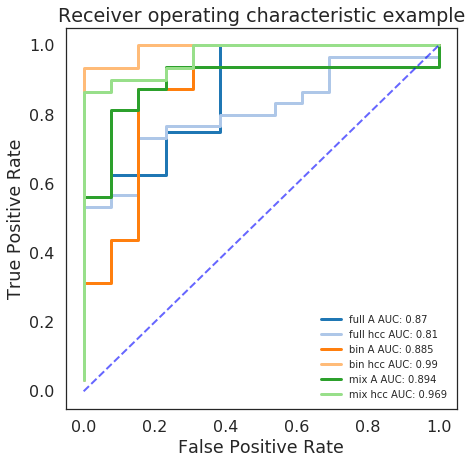

In [499]:
def mrmr_roc(feature,label,penalty=2):
    logmodel = LogisticRegression()
    y_score = logmodel.fit(feature,label).decision_function(feature)
    fpr, tpr, _ = roc_curve(label, y_score)
    roc_auc = auc(fpr, tpr)
    return roc_auc,fpr, tpr,logmodel.predict(feature)
roc,fpr,tpr,predict = {},{},{},{}
for i in range(3):
    for j in range(2):
        roc[i*2+j],fpr[i*2+j],tpr[i*2+j],predict[i*2+j]= \
        mrmr_roc(dataset[datatype[i]][dataclass[j]][:,indfrommrmr[i][j][0:10]  ] ,labelset[datatype[i]][dataclass[j]])
fig,ax=plt.subplots(1,figsize=(7,7))
for i in range(3):
    for j in range(2):
        ax.plot(fpr[i*2+j],tpr[i*2+j],linewidth=3,color=tableau20[i*2+j],label=datatype[i]+' '+dataclass[j]+' AUC: '+str(np.round(roc[i*2+j],3)))
ax.legend(prop={'size': 10})
ax.plot([0,1],[0,1], linewidth=2,alpha=0.6,color='b',linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')

## 画一个AUC与feature importance结合的图

In [727]:
coeffrommrmr[2][1]

array([ 1.74 ,  1.737,  1.737,  1.737,  1.737,  1.731,  1.721,  1.717,
        1.717,  1.717,  1.717,  1.717,  1.717,  1.717,  1.717,  1.717,
        1.717,  1.717,  1.717,  1.717,  1.717,  1.717,  1.715,  1.713,
        1.713,  1.713,  1.713,  1.713,  1.713,  1.705,  1.705,  1.705,
        1.705,  1.705,  1.705,  1.705,  1.705,  1.693,  1.693,  1.693,
        1.693,  1.693,  1.691,  1.691,  1.691,  1.691,  1.691,  1.691,
        1.691,  1.691,  1.691,  1.691,  1.691,  1.691,  1.691,  1.691,
        1.691,  1.691,  1.691,  1.691,  1.691,  1.691,  1.691,  1.691,
        1.691,  1.691,  1.691,  1.691,  1.691,  1.69 ,  1.69 ,  1.69 ,
        1.69 ,  1.69 ,  1.69 ,  1.69 ,  1.69 ,  1.69 ,  1.69 ,  1.689,
        1.689,  1.689,  1.689,  1.689,  1.689,  1.689,  1.689,  1.689,
        1.689,  1.689,  1.689,  1.689,  1.689,  1.689,  1.689,  1.689,
        1.689,  1.756, 27.076, 18.166, 18.1  , 16.265, 14.297, 13.837,
       13.423, 12.878, 12.877, 12.181, 11.897, 11.886, 11.461, 10.98 ,
      

In [ ]:
def mrmr_roc(feature,label,penalty=2):
    logmodel = LogisticRegression()
    y_score = logmodel.fit(feature,label).decision_function(feature)
    fpr, tpr, _ = roc_curve(label, y_score)
    roc_auc = auc(fpr, tpr)

In [748]:
mrmrpickind = np.arange(98,196)

In [749]:
roc,fpr,tpr,predict ={},{},{},{}
for k in range(20):
    roc[k],fpr[k],tpr[k],predict[k] ={},{},{},{}
    for i in range(2,3):
        for j in range(1,2):
            roc[k][i*2+j],fpr[k][i*2+j],tpr[k][i*2+j],predict[k][i*2+j]= mrmr_roc(dataset[datatype[i]][dataclass[j]][:,indfrommrmr[i][j][mrmrpickind][np.argsort(-coeffrommrmr[i][j][mrmrpickind])[0:(k+1)]]  ] ,labelset[datatype[i]][dataclass[j]])
            
            

In [750]:
for i in range(20):
    print (roc[i][5])

0.6102564102564102
0.6743589743589745
0.6871794871794872
0.6871794871794872
0.6897435897435897
0.6948717948717948
0.7102564102564103
0.7384615384615385
0.8743589743589744
0.9282051282051282
0.9564102564102563
0.9564102564102563
0.9692307692307693
0.9743589743589742
0.9692307692307693
0.9743589743589742
0.9794871794871794
0.9717948717948717
0.9769230769230768
0.9923076923076923


In [751]:
coeffrommrmr[2][1][mrmrpickind][np.argsort(-coeffrommrmr[2][1][mrmrpickind])]

array([27.076, 18.166, 18.1  , 16.265, 14.297, 13.837, 13.423, 12.878,
       12.877, 12.181, 11.897, 11.886, 11.461, 11.426, 11.054, 11.052,
       11.003, 10.994, 10.98 , 10.927, 10.896, 10.859, 10.681, 10.663,
       10.638, 10.622, 10.603, 10.584, 10.577, 10.564, 10.56 , 10.555,
       10.492, 10.462, 10.4  , 10.373, 10.357, 10.35 , 10.346, 10.313,
       10.239, 10.208, 10.208, 10.202, 10.121, 10.107, 10.103, 10.059,
       10.027,  9.993,  9.879,  9.866,  9.809,  9.787,  9.782,  9.772,
        9.763,  9.76 ,  9.724,  9.716,  9.697,  9.692,  9.691,  9.682,
        9.68 ,  9.678,  9.675,  9.659,  9.658,  9.649,  9.64 ,  9.623,
        9.621,  9.621,  9.619,  9.616,  9.613,  9.613,  9.604,  9.591,
        9.57 ,  9.531,  9.503,  9.485,  9.47 ,  9.445,  9.434,  9.425,
        9.419,  9.369,  9.366,  9.353,  9.352,  9.35 ,  9.346,  9.327,
        9.316,  9.292])

In [756]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [766]:
np.array([roc[i][5] for i in range(10)])

array([0.61025641, 0.67435897, 0.68717949, 0.68717949, 0.68974359,
       0.69487179, 0.71025641, 0.73846154, 0.87435897, 0.92820513])

In [783]:
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_style(styles[0])
sns.set_context(contexts[0])

Text(0,0.5,'AUC')

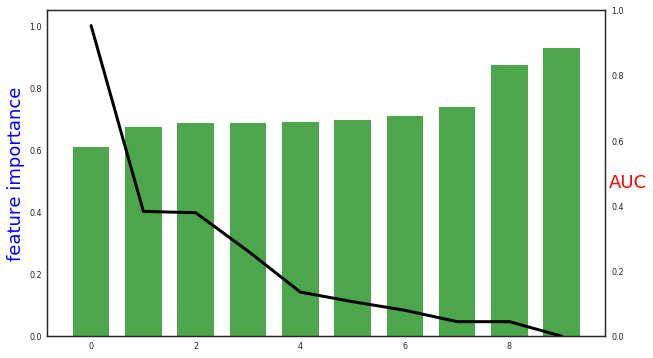

In [787]:
fig,ax=plt.subplots(1,figsize=(10,6))
ax.plot(scaler.fit_transform(coeffrommrmr[2][1][mrmrpickind][np.argsort(-coeffrommrmr[2][1][mrmrpickind])][:10].reshape(-1,1)).ravel(),
       color='black',linewidth=3.0)
ax.set_ylabel('feature importance', color='b',fontsize=18)
ax2 = ax.twinx()
ax.bar(range(10),np.array([roc[i][5] for i in range(10)]),0.7,color='g',alpha=0.7)
ax2.set_ylabel('AUC', color='r',rotation=0,fontsize=18)

In [790]:
np.array([roc[i][5] for i in range(11)])[1:] - np.array([roc[i][5] for i in range(10)])

array([0.06410256, 0.01282051, 0.        , 0.0025641 , 0.00512821,
       0.01538462, 0.02820513, 0.13589744, 0.05384615, 0.02820513])

Text(0,0.5,'AUC improvement')

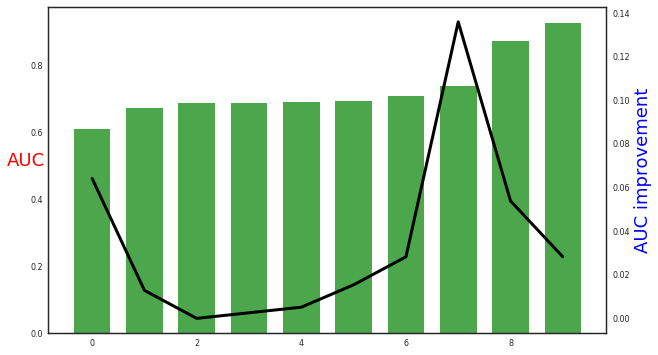

In [793]:
fig,ax=plt.subplots(1,figsize=(10,6))
ax.bar(range(10),np.array([roc[i][5] for i in range(10)]),0.7,color='g',alpha=0.7)
ax.set_ylabel('AUC', color='r',rotation=0,fontsize=18)
ax2 = ax.twinx()
ax2.plot(np.array([roc[i][5] for i in range(11)])[1:] - np.array([roc[i][5] for i in range(10)]),
       color='black',linewidth=3.0)
ax2.set_ylabel('AUC improvement', color='b',fontsize=18)



Text(0,0.5,'AUC improvement')

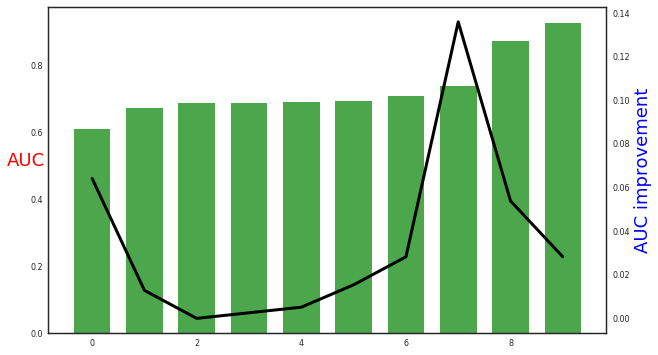

In [793]:
fig,ax=plt.subplots(1,figsize=(10,6))
ax.bar(range(10),np.array([roc[i][5] for i in range(10)]),0.7,color='g',alpha=0.7)
ax.set_ylabel('AUC', color='r',rotation=0,fontsize=18)
ax2 = ax.twinx()
ax2.plot(np.array([roc[i][5] for i in range(11)])[1:] - np.array([roc[i][5] for i in range(10)]),
       color='black',linewidth=3.0)
ax2.set_ylabel('AUC improvement', color='b',fontsize=18)



In [ ]:
#forward and RFE

In [ ]:
forward:每次找最高的，然后选出来  另用一个range来保证取的feature总是在总index
    

In [821]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Load the digits dataset
digits = load_digits()
X = dataset[datatype[0]][dataclass[1]]
y = labelset[datatype[0]][dataclass[1]]

# Create the RFE object and rank each pixel
logistic = LogisticRegression(penalty='l1',C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=2)
rfe.fit(X, y)

RFE(estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
  n_features_to_select=1, step=2, verbose=0)

In [826]:
rfe.support_.shape

(10289,)

In [819]:
np.unique(rfe.ranking_,return_counts=True)[1]!=1

(array([], dtype=int64),)

In [822]:
rfe.n_features_

1

# RFE
设置一个step，每次去掉step个排名最低的特征
然后在RFE筛出来的feature的基础上再正着做forward

In [ ]:
def RFE_logistic():
    

In [812]:
roc,fpr,tpr,predict ={},{},{},{}
for k in range(20):
    roc[k],fpr[k],tpr[k],predict[k] ={},{},{},{}
    for i in range(0,1):
        for j in range(1,2):
            roc[k][i*2+j],fpr[k][i*2+j],tpr[k][i*2+j],predict[k][i*2+j]= mrmr_roc(dataset[datatype[i]][dataclass[j]][:, rfe.ranking_[0:(k+1)] ] ,labelset[datatype[i]][dataclass[j]])
            
    

Text(0,0.5,'AUC improvement')

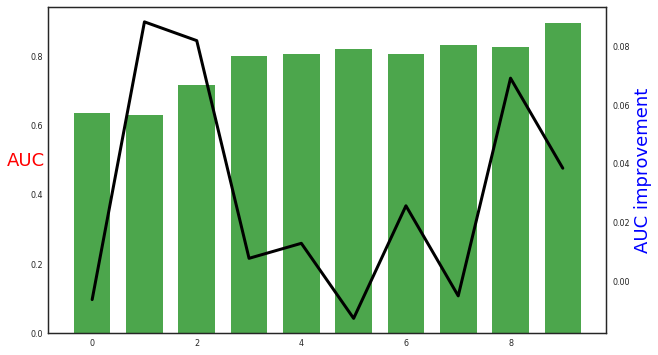

In [815]:
fig,ax=plt.subplots(1,figsize=(10,6))
ax.bar(range(10),np.array([roc[i][1] for i in range(10)]),0.7,color='g',alpha=0.7)
ax.set_ylabel('AUC', color='r',rotation=0,fontsize=18)
ax2 = ax.twinx()
ax2.plot(np.array([roc[i][1] for i in range(11)])[1:] - np.array([roc[i][1] for i in range(10)]),
       color='black',linewidth=3.0)
ax2.set_ylabel('AUC improvement', color='b',fontsize=18)



In [ ]:
ranking = rfe.ranking_.reshape(digits.images[0].shape)

# Plot pixel ranking
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()

## 所有feature的效果

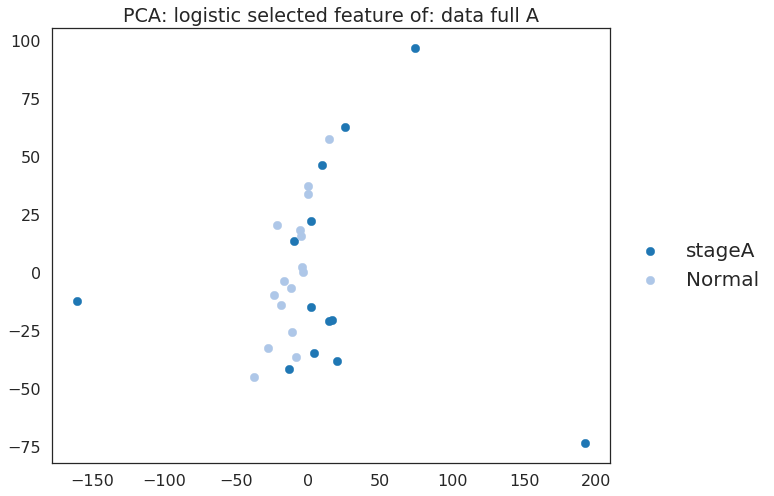

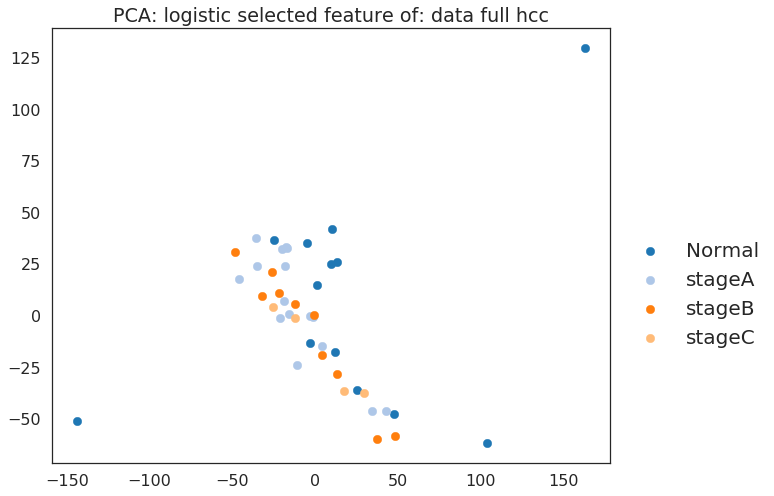

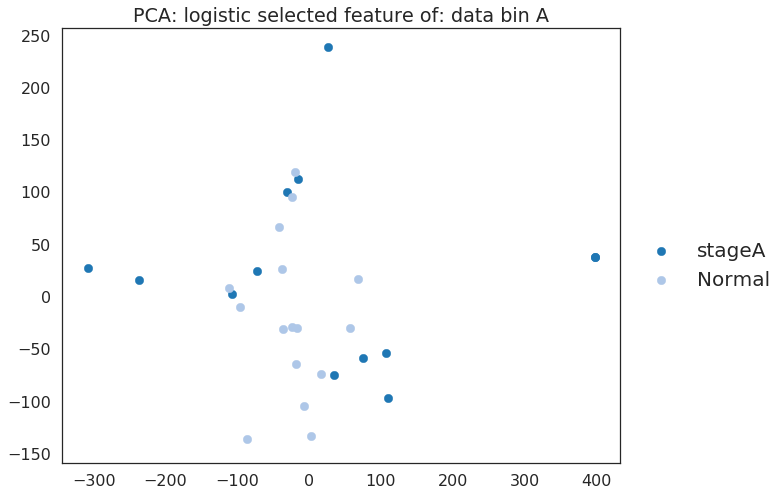

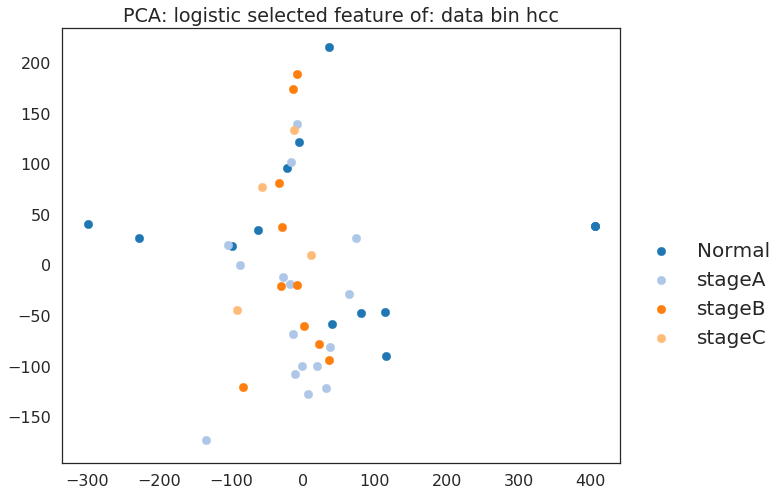

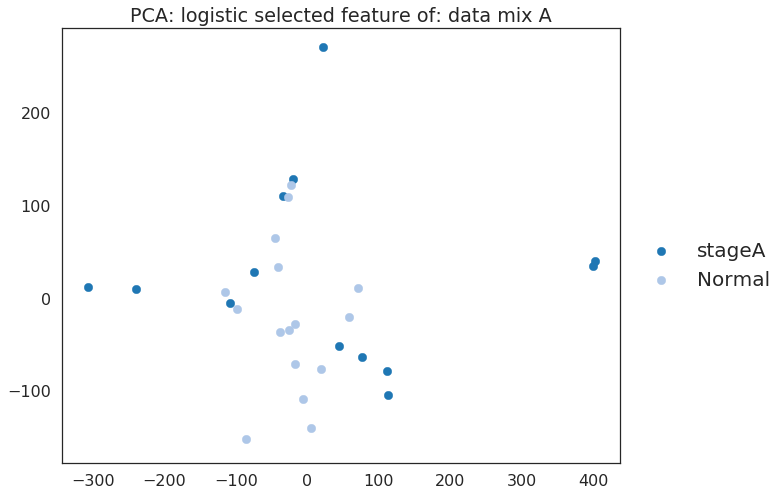

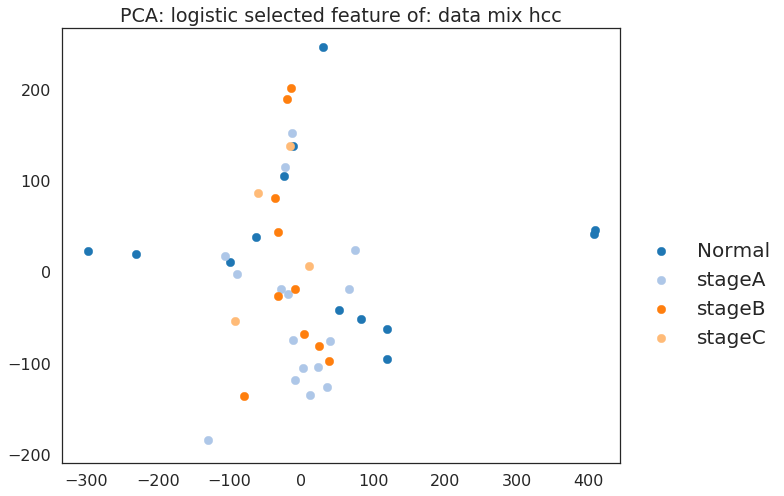

In [245]:
for i in range(3):
    for j in range(2):
        if not j%2:
            m='stage'
            n = labelset[datatype[i]][dataclass[j]]
        else:
            m='allstage'
            n = sampleclass
        plot_PCA(dataset[datatype[i]][dataclass[j]],
        n ,'PCA: logistic selected feature of: data '+datatype[i]+' '+dataclass[j],m)

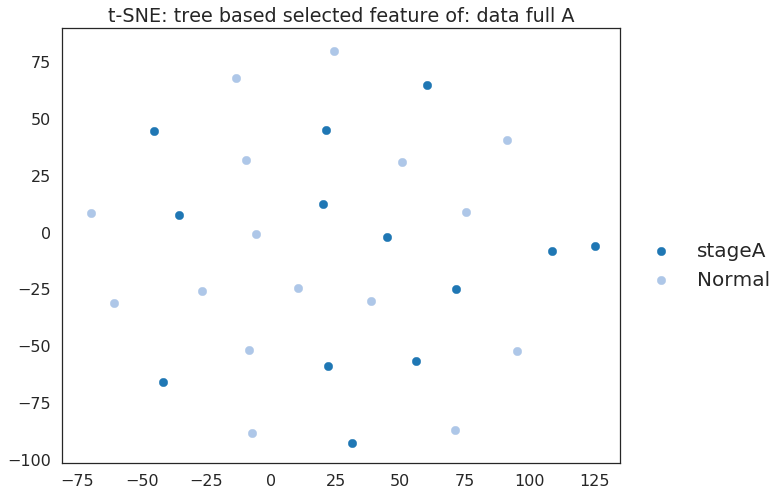

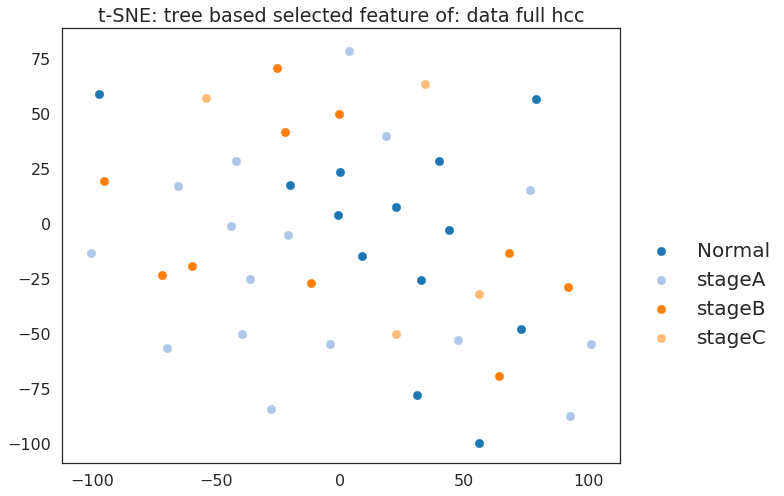

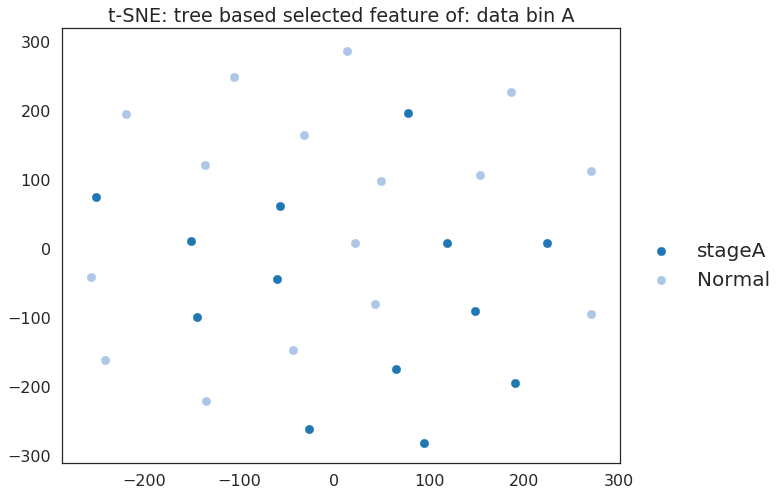

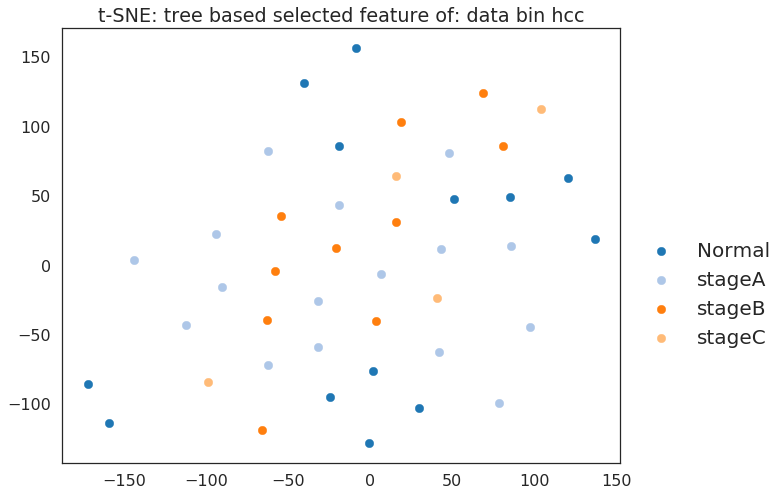

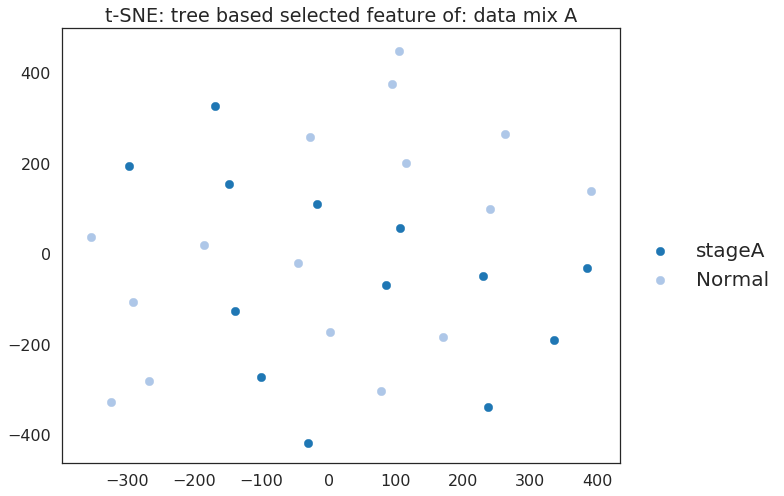

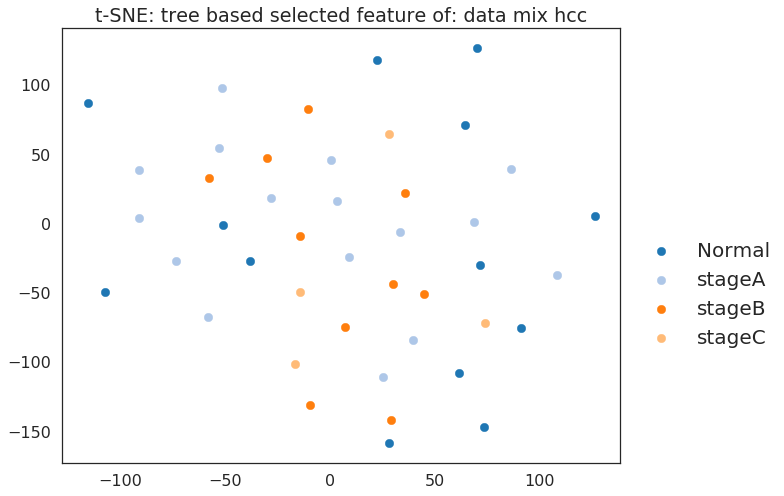

In [246]:
for i in range(3):
    for j in range(2):
        if not j%2:
            m='stage'
            n = labelset[datatype[i]][dataclass[j]]
        else:
            m='allstage'
            n = sampleclass
        plot_tsne(dataset[datatype[i]][dataclass[j]],
         n,'t-SNE: tree based selected feature of: data '+datatype[i]+' '+dataclass[j],m)

In [ ]:
tableroc = pd.DataFrame(roctable,
             columns=['StageA vs Control','StageB vs Control','StageC vs Control'],
            index=['full','','','binned','','','mixed','','','miRNA','',''])
tableroc['cv'] = np.repeat(['cv1','cv2','cv3'],4).reshape(-1,4).T.ravel()
tableroc

In [197]:
mrmrmixAtable['ID']

0     lncRNA_ENSG00000280156.1
1     lncRNA_ENSG00000281344.1
2      miRNA_ENSG00000266531.1
3     srpRNA_ENSG00000242509.3
4     lncRNA_ENSG00000280623.1
5      miRNA_ENSG00000221410.1
6     srpRNA_ENSG00000244642.3
7                   tRNA_35946
8     srpRNA_ENSG00000239702.3
9     lncRNA_ENSG00000279789.1
10     miRNA_ENSG00000272458.1
11    srpRNA_ENSG00000242863.3
12     miRNA_ENSG00000266148.1
13    lncRNA_ENSG00000259460.1
14     miRNA_ENSG00000278223.1
15    lncRNA_ENSG00000276216.1
16    lncRNA_ENSG00000280156.1
17    lncRNA_ENSG00000234715.1
18                  tRNA_26644
19    srpRNA_ENSG00000243366.3
20    lncRNA_ENSG00000283265.1
21     miRNA_ENSG00000264314.1
22    lncRNA_ENSG00000237513.1
23                  tRNA_25611
24    lncRNA_ENSG00000273284.1
25    lncRNA_ENSG00000281344.1
26    lncRNA_ENSG00000220891.1
27    lncRNA_ENSG00000240990.9
28    lncRNA_ENSG00000280156.1
29                  tRNA_36393
                ...           
70    lncRNA_ENSG00000276166.1
71    ln

In [198]:
wholetables = [
logfullAtable,  treefullAtable,   mrmrfullAtable,
logfullhcctable,treefullhcctable, mrmrfullhcctable,
logbinAtable,   treebinAtable,    mrmrbinAtable,
logbinhcctable, treebinhcctable,  mrmrbinhcctable,
logmixAtable,   treemixAtable,    mrmrmixAtable,
logmixhcctable, treemixhcctable,  mrmrmixhcctable]

In [199]:
np.intersect1d(wholetables[0]['ID'],wholetables[1]['ID'])

array(['Y_RNA_ENSG00000202255.1', 'lncRNA_ENSG00000256642.1',
       'miRNA_ENSG00000211583.3', 'piRNA_piR.hsa.20664_50', 'tRNA_12975',
       'tRNA_26898'], dtype=object)

In [200]:
np.intersect1d(wholetables[1]['ID'],wholetables[2]['ID'])

array(['Y_RNA_ENSG00000206690.1', 'lncRNA_ENSG00000175147.11'],
      dtype=object)

In [201]:
np.intersect1d(wholetables[3]['ID'],wholetables[4]['ID'])

array(['Y_RNA_ENSG00000202255.1', 'lncRNA_ENSG00000226240.1',
       'lncRNA_ENSG00000255202.1', 'lncRNA_ENSG00000279302.3',
       'srpRNA_ENSG00000243420.3'], dtype=object)

In [202]:
np.intersect1d(wholetables[6]['ID'],wholetables[7]['ID'])

array(['lncRNA_ENSG00000229807.10', 'lncRNA_ENSG00000277837.1',
       'lncRNA_ENSG00000277954.1', 'lncRNA_ENSG00000280614.1',
       'piRNA_piR.hsa.20572_3700'], dtype=object)

In [203]:
np.where(wholetables[6]['ID'] =='miRNA_MIR21')

(array([], dtype=int64),)

In [204]:
np.intersect1d(wholetables[7]['ID'],wholetables[8]['ID'])

array(['lncRNA_ENSG00000263938.1', 'piRNA_piR.hsa.30937_27091'],
      dtype=object)

In [205]:
np.intersect1d(wholetables[9]['ID'],wholetables[10]['ID'])

array(['lncRNA_ENSG00000279738.1', 'lncRNA_ENSG00000281181.1',
       'piRNA_piR.hsa.20572_3700', 'snoRNA_ENSG00000201025.1',
       'snoRNA_ENSG00000252337.1', 'srpRNA_ENSG00000241789.3'],
      dtype=object)

In [206]:
np.intersect1d(wholetables[9]['ID'],wholetables[11]['ID'])

array(['lncRNA_ENSG00000245532.7', 'lncRNA_ENSG00000248360.7',
       'piRNA_piR.hsa.20572_3700'], dtype=object)

In [207]:
np.intersect1d(wholetables[10]['ID'],wholetables[11]['ID'])

array(['lncRNA_ENSG00000197099.8', 'lncRNA_ENSG00000225914.1',
       'lncRNA_ENSG00000281344.1', 'piRNA_piR.hsa.20572_3700'],
      dtype=object)

In [208]:
np.intersect1d(wholetables[12]['ID'],wholetables[13]['ID'])

array(['lncRNA_ENSG00000277837.1', 'lncRNA_ENSG00000281344.1',
       'miRNA_ENSG00000207954.1', 'piRNA_piR.hsa.20572_3700',
       'piRNA_piR.hsa.21148_60'], dtype=object)

In [209]:
np.intersect1d(wholetables[13]['ID'],wholetables[14]['ID'])

array(['lncRNA_ENSG00000281344.1'], dtype=object)

In [210]:
np.intersect1d(wholetables[15]['ID'],wholetables[16]['ID'])

array(['lncRNA_ENSG00000280800.1', 'lncRNA_ENSG00000281181.1',
       'piRNA_piR.hsa.20572_3700', 'snoRNA_ENSG00000206688.1'],
      dtype=object)

In [211]:
np.intersect1d(wholetables[16]['ID'],wholetables[17]['ID'])

array(['lncRNA_ENSG00000227195.10', 'srpRNA_ENSG00000265052.2',
       'tRNA_20655'], dtype=object)

In [212]:
tmptable = wholetables[0]
for i in np.arange(1,18):
    tmptable = pd.concat((tmptable,wholetables[i]),axis=1)

In [213]:
tmptable.columns = ['fullA','logistic','fullA','tree','fullA','MRMR',
                   'fullhcc','logistic','fullhcc','tree','fullhcc','MRMR',
                   'binA','logistic','binA','tree','binlA','MRMR',
                   'binhcc','logistic','binhcc','tree','binhcc','MRMR',
                   'mixA','logistic','mixA','tree','mixA','MRMR',
                   'mixhcc','logistic','mixhcc','tree','mixhcc','MRMR',]

In [215]:
tmptable.to_csv('selected_feature_by_three_methods7.23.csv')

In [216]:
pd.concat((wholetables[0],wholetables[1]),axis=1).head()

,ID,importance,ID,importance
0,piRNA_piR.hsa.21148_60,0.560251,miRNA_ENSG00000211583.3,0.0557692
1,Y_RNA_ENSG00000201676.1,0.510644,tRNA_26898,0.0380114
2,miRNA_ENSG00000221586.1,0.474859,Y_RNA_ENSG00000202255.1,0.0365625
3,lncRNA_ENSG00000256642.1,-0.462682,piRNA_piR.hsa.21148_67,0.0338092
4,lncRNA_ENSG00000280059.1,0.458492,snRNA_ENSG00000251748.1,0.0315559


In [217]:
tmptable_ = wholetables[0]['ID']
for i in np.arange(1,18):
    tmptable_ = pd.concat((tmptable_,wholetables[i]['ID']),axis=1)

In [218]:
tmptable_.columns = ['fullA: logistic','fullA: tree','fullA: MRMR',
                   'fullhcc: logistic','fullhcc: tree','fullhcc: MRMR',
                   'binA: logistic','binA: tree','binlA: MRMR',
                   'binhcc: logistic','binhcc: tree','binhcc: MRMR',
                   'mixA: logistic','mixA: tree','mixA: MRMR',
                   'mixhcc: logistic','mixhcc: tree','mixhcc: MRMR',]

In [219]:
tmptable_.to_csv('selected_feature_by_three_methods7.23_id.csv')

In [626]:
pwd

'/home/chenxupeng/projects/training'

## 查看重复的gene

In [234]:
tmparr = np.array(wholetables[0]['ID'])
for i in np.arange(1,18):
    tmparr = np.concatenate((tmparr,np.array(wholetables[i]['ID'])))
nameforgene,countforgene = np.unique(tmparr,return_counts=True)

In [235]:
countforrepeat = countforgene[np.where(countforgene>2)][np.argsort(-countforgene[np.where(countforgene>2)])]

In [236]:
nameforrepeat = nameforgene[np.where(countforgene>2)][np.argsort(-countforgene[np.where(countforgene>2)])]

In [237]:
nameandcounttable = pd.DataFrame(np.concatenate((nameforrepeat.reshape(-1,1),
                            countforrepeat.reshape(-1,1)),axis=1),columns=['ID','Counts'])

In [241]:
listnameandcount = []
for i in range(nameandcounttable.shape[0]):
    listnameandcount.append(nameandcounttable.iloc[i,0]+': '+str(nameandcounttable.iloc[i,1]))
display(pd.DataFrame(np.array(listnameandcount).reshape(-1,3)))

,0,1,2
0,piRNA_piR.hsa.20572_3700: 41,lncRNA_ENSG00000277837.1: 33,lncRNA_ENSG00000229807.10: 21
1,lncRNA_ENSG00000280156.1: 18,snoRNA_ENSG00000206688.1: 17,lncRNA_ENSG00000280800.1: 16
2,lncRNA_ENSG00000281344.1: 15,snoRNA_ENSG00000201025.1: 14,lncRNA_ENSG00000279738.1: 12
3,tRNA_12975: 10,lncRNA_ENSG00000226674.8: 9,lncRNA_ENSG00000280614.1: 8
4,lncRNA_ENSG00000281181.1: 8,snoRNA_ENSG00000252337.1: 8,lncRNA_ENSG00000230606.10: 8
5,lncRNA_ENSG00000245532.7: 8,lncRNA_ENSG00000223387.6: 7,snoRNA_ENSG00000207421.1: 7
6,lncRNA_ENSG00000280184.2: 7,lncRNA_ENSG00000260793.2: 6,lncRNA_ENSG00000187621.14: 6
7,Y_RNA_ENSG00000202255.1: 6,tRNA_22351: 5,snoRNA_ENSG00000281859.1: 5
8,srpRNA_ENSG00000242158.3: 5,lncRNA_ENSG00000277954.1: 5,snoRNA_ENSG00000239002.3: 5
9,lncRNA_ENSG00000280136.2: 5,srpRNA_ENSG00000264573.2: 5,lncRNA_ENSG00000230424.1: 5


In [242]:
pd.DataFrame(np.array(listnameandcount).reshape(-1,3)).to_csv('repeated_genes7.23.csv')